***
## Table of Contents
<br>
<ol>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;"> 70:30 Uninfected:Infected Users</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. 80:20 Train Test Split </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. 70:30 Train Test Split </h3></a>
            </ul>
        <ul>
            <a href='#1.C' style="text-decoration : none; color : #000000;"><h3>C. 80:20 Train Test Split with PCA </h3></a>
        </ul>
        <ul>
            <a href='#1.D' style="text-decoration : none; color : #000000;"><h3>D. 70:30 Train Test Split with PCA </h3></a>
           </ul>
     </ol>
<br>

In [1]:
### Import Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pprint
from tabulate import tabulate
import warnings

%matplotlib inline
pd.set_option("display.max_columns",40)
warnings.filterwarnings("ignore")

from IPython.display import HTML


import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier


from sklearn.metrics import confusion_matrix,accuracy_score,auc,roc_curve
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,binarize



Using TensorFlow backend.


In [2]:
from pandas_ml import ConfusionMatrix

### Function get_params takes as input a grid search model and prints out the best parameters for the model and 
### prints the best accuracy of the model
def get_params(grid,model_name=''):
    print("Best Parameters are :")
    display(pd.DataFrame.from_dict(grid.best_params_, orient='index').reset_index().transpose())

### The function takes as input the model, X and Y data to generate the confusion matrix  
def get_cm(model,a,b):
    y_pred=model.predict(a)
    cm=ConfusionMatrix(b,y_pred)
    display(cm)
    return cm
 
### The get accuracy plot takes as input a dataframe and a string for the title of the plot and displays a plot
### The function is primarily for plotting of accuracies for various classifiers for the same split.
def get_accuracy_plot(data,title=''):
    plt.figure(figsize=(12,8))
    plt.plot(data['accuracy'].values, '--o')
    plt.ylabel('Accuracy', fontsize=20)
    plt.xlabel('Classifier', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xlim([0, 9])
    plt.title(title,size=18,y=1.05)
    plt.xticks(np.arange(10),data.index.get_values(),rotation=90)
    plt.legend(loc='upper right', fontsize=18)
    plt.show()

### Function grid takes as input an estimator, X_train,Y_Train,X_test and Y_test and a string represetning the name of the model
### We perform StratifiedKFold cross validation and grid search to hypertune the parameters of the model     
def grid_acc(kernel,params,x,y,x_test,y_test,model_name=''):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    grid_search=GridSearchCV(estimator=kernel,param_grid=parameters,scoring='accuracy',cv=kfold,n_jobs=-1)
    grid_search.fit(x,y)
    get_params(grid_search,model_name)
    acc_train=accuracy_score(y,grid_search.predict(x))
    print("Accuracy of the ",model_name," model for the training data is:",acc_train)
    print("\nConfusion Matrix for Training data is:")
    cm_train=get_cm(grid_search,x,y)
    acc_test=accuracy_score(y_test,grid_search.predict(x_test))
    print("Accuracy of the ",model_name," model for test data is:",acc_test)
    print("\nConfusion Matrix for test data is:")
    cm_test=get_cm(grid_search,x_test,y_test)
    return grid_search,cm_train,cm_test,acc_train,acc_test    

### Plot roc curve
def get_roc_curve(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy of Logistic Model on training data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

def get_roc_curve_deep_learning(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy of Logistic Model on training data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

### <a id='1.A' style="text-decoration : none; color : #000000;">A. 80:20 Train Test split </a>

#### Random State 0

In [3]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_0.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC        PAR  \
Source_User                                                           
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  4607  77.507923   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   169   5.840237   

                                                          PAS         LEN  \
Source_User                                                                 
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  40.245713  100.283265   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   5.597633  149.763314   

                                                            BYS           BYR  \
Source_User                                                                     
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  6930.568483  89947.788800   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...  1016.976331   3222.147929   

                                                        SP     DP  NAPP  SIP  \
Source_User                                                                    
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  3901.0  113.0    58   86   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   168.0    4.0     9   11   

                                                     DIP          TDIF  0000  \
Source_User                                                                    
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  1116   1646.597569   167   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...    16  40005.674556     0   

                                                    0100  0200  0300  0400  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   295   328   198   223   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0     0   

                                                    0500  0600  0700  0800  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   135   144   145   194   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0     8   

                                                    0900  1000  1100  1200  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   197   196   178   120   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     8     0     0    39   

                                                    1300  1400  1500  1600  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   145   118   224   172   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...    48    40    10     4   

                                                    1700  1800  1900  2000  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   241   246   151   165   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     4     2     6     0   

                                                    2100  2200  2300  
Source_User                                                           
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   177   134   314  
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0

In [4]:
### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

1 -> Infected
0 -> Uninfected


Source_User
bb98d45a9bd0c40362a3ec37503c10b8238194752d355742cd3ea35221dc98b1    1
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e215137c4ad8c46fc5    0
56a003f863f8cc9342216fa01a3ab0aebf4a04ed0dd8d5b89a95f779cc707dd5    1
f894aec69ce612e29505d6d3cd9112bbe39d6a46e7da2682d14a1cbd9c4cd297    0
9aadb359b9763e3d68e62ad3c406245fcf0bc4919395dbf42532e49d8b5aa02d    1
dbea3804991397c518e0198f2b63ecab35cbf38083cb5e19bb9d4b4f4bacaa2d    1
f2327a8577d940bf7100353fce41bbde184c6e4ead193ab60986bb3ef2551718    1
d815eb7ef3af2a56e8260b0b3a6bb3c1bf70c625619caa930cff27beced41ea1    1
ae3fe786080d0c4a0d3520152bb59d60836d2ae6fdb4870a1879b98ea7ec02fc    1
45b5cf89d8e8ff70ce05570a97d5ff05783283281eade7d8b736c94a24cfb16c    1
Name: Target, dtype: int64

In [5]:
### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [6]:
## Table to store training and test measures
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [7]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  euclidean           50  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4643     0     4643
1             0  1973     1973
__all__    4643  1973     6616

Accuracy of the  KNN  model for test data is: 0.800483675937

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           996  150     1146
1           180  328      508
__all__    1176  478     1654

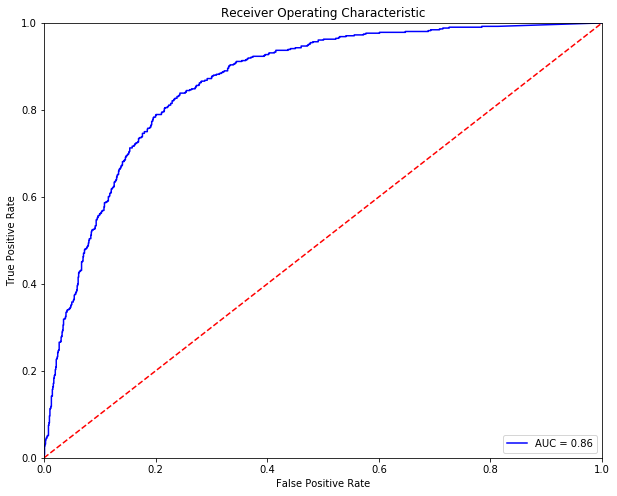

Optimal Threshold is 0.327979384477
Accuracy of Logistic Model on training data is: 0.790205562273


Predicted   0.0  1.0  __all__
Actual                       
0.0         906  240     1146
1.0         107  401      508
__all__    1013  641     1654

In [8]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [9]:
table_80_70_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [10]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.3  False          False                0.7       100  multinomial   

             6       7    8  
index  penalty  solver  tol  
0           l2     sag  0.1

Accuracy of the  Logistic  model for the training data is: 0.799576783555

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3740   903     4643
1           423  1550     1973
__all__    4163  2453     6616

Accuracy of the  Logistic  model for test data is: 0.798669891173

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           925  221     1146
1           112  396      508
__all__    1037  617     1654

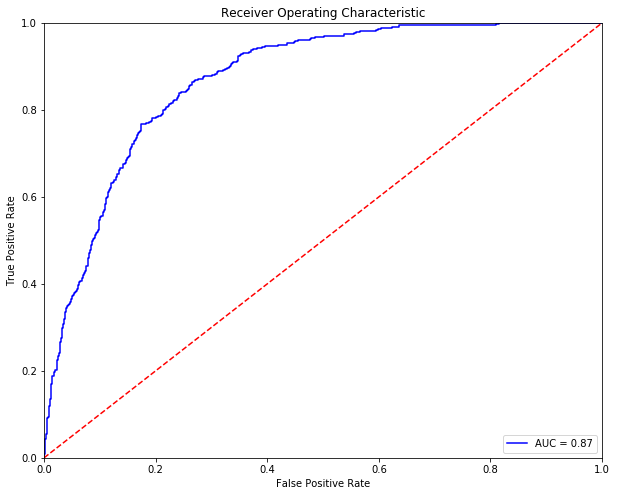

Optimal Threshold is 0.479227657812
Accuracy of Logistic Model on training data is: 0.78899637243


Predicted   0.0  1.0  __all__
Actual                       
0.0         905  241     1146
1.0         108  400      508
__all__    1013  641     1654

In [11]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [12]:
table_80_70_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [13]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[10000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1         10000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.807587666264

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3852   791     4643
1           482  1491     1973
__all__    4334  2282     6616

Accuracy of the  Random Forest Trees  model for test data is: 0.801088270859

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           949  197     1146
1           132  376      508
__all__    1081  573     1654

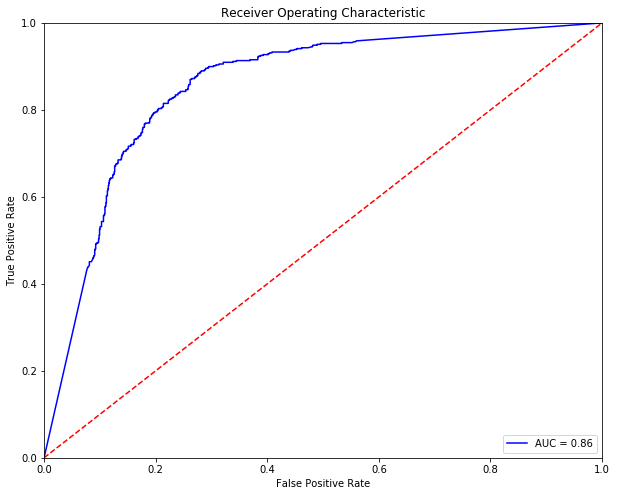

Optimal Threshold is 0.340085861062
Accuracy of Logistic Model on training data is: 0.796856106409


Predicted   0.0  1.0  __all__
Actual                       
0.0         914  232     1146
1.0         104  404      508
__all__    1018  636     1654

In [14]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [15]:
table_80_70_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

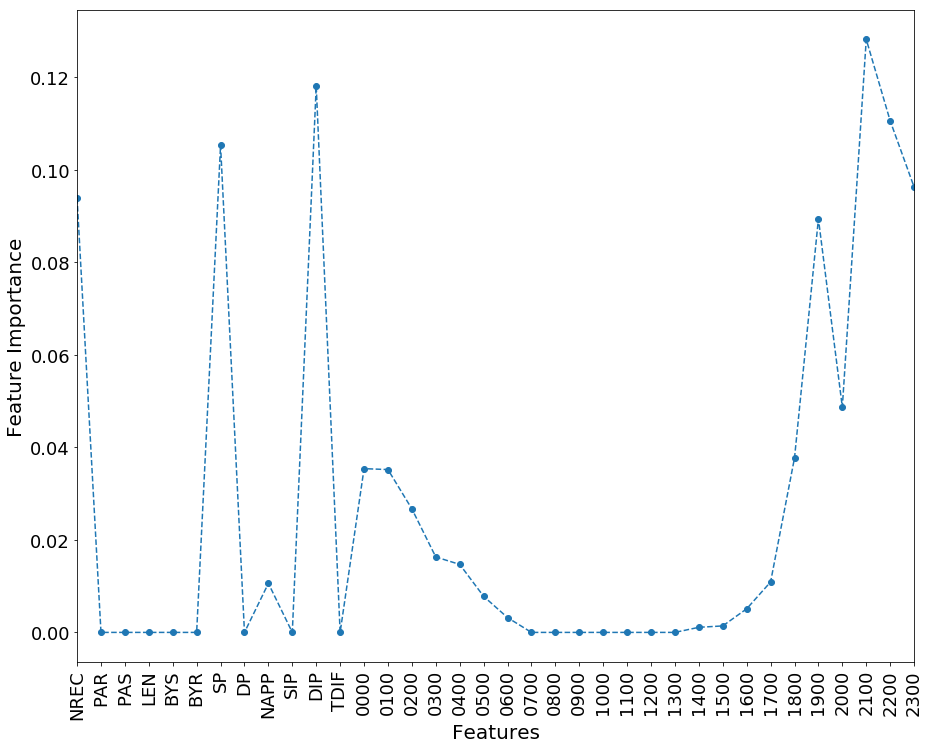

In [16]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [17]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0        SAMME.R            0.5           150             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.814087061669

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4009   634     4643
1           596  1377     1973
__all__    4605  2011     6616

Accuracy of the  AdaBoostClassifier  model for test data is: 0.807134220073

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           986  160     1146
1           159  349      508
__all__    1145  509     1654

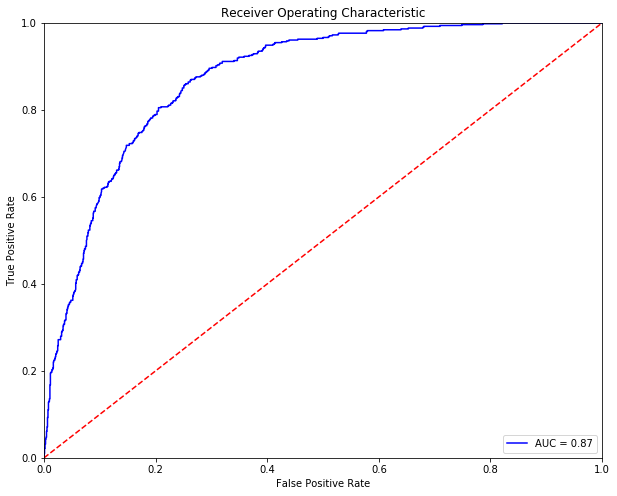

Optimal Threshold is 0.498636045028
Accuracy of Logistic Model on training data is: 0.796856106409


Predicted   0.0  1.0  __all__
Actual                       
0.0         914  232     1146
1.0         104  404      508
__all__    1018  636     1654

In [18]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [19]:
table_80_70_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

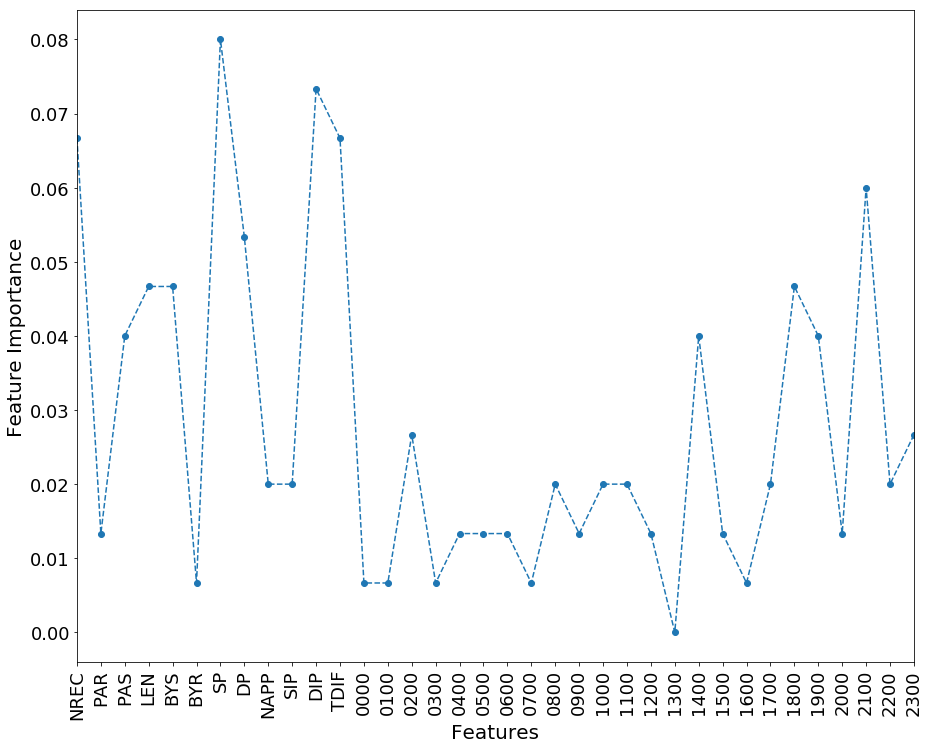

In [20]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [21]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse            0.1  exponential                10   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.2           100             0        0.7

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.824365175333

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4047   596     4643
1           566  1407     1973
__all__    4613  2003     6616

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.812575574365

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           996  150     1146
1           160  348      508
__all__    1156  498     1654

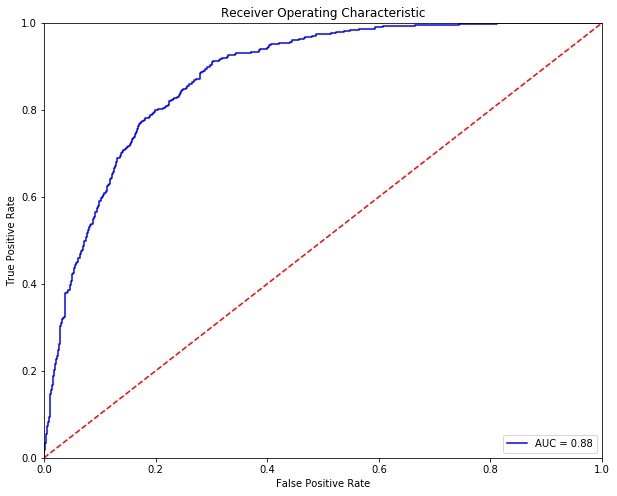

Optimal Threshold is 0.362099948659
Accuracy of Logistic Model on training data is: 0.799879081016


Predicted   0.0  1.0  __all__
Actual                       
0.0         918  228     1146
1.0         103  405      508
__all__    1021  633     1654

In [22]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [23]:
table_80_70_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

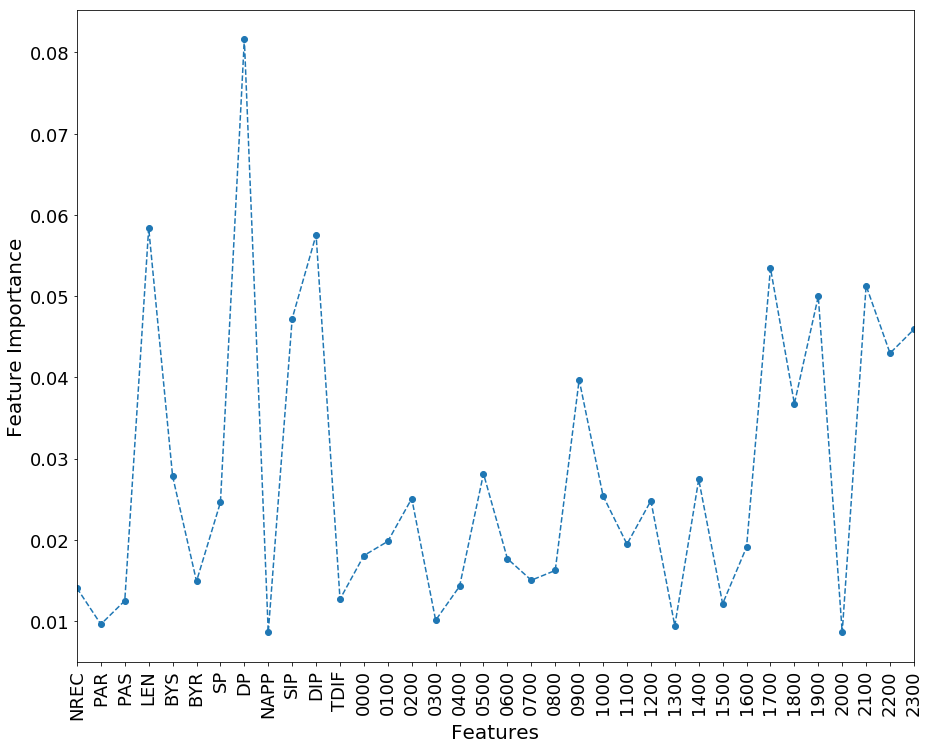

In [24]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [25]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0           gini         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.808494558646

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3968   675     4643
1           592  1381     1973
__all__    4560  2056     6616

Accuracy of the  Extra Decision Tree  model for test data is: 0.805320435308

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           988  158     1146
1           164  344      508
__all__    1152  502     1654

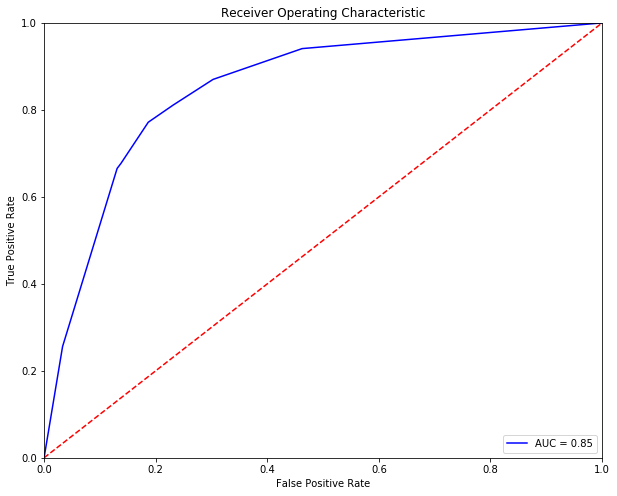

Optimal Threshold is 0.448453608247
Accuracy of Logistic Model on training data is: 0.805320435308


Predicted   0.0  1.0  __all__
Actual                       
0.0         988  158     1146
1.0         164  344      508
__all__    1152  502     1654

In [26]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [27]:
table_80_70_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [28]:
%%capture
table_80_70_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

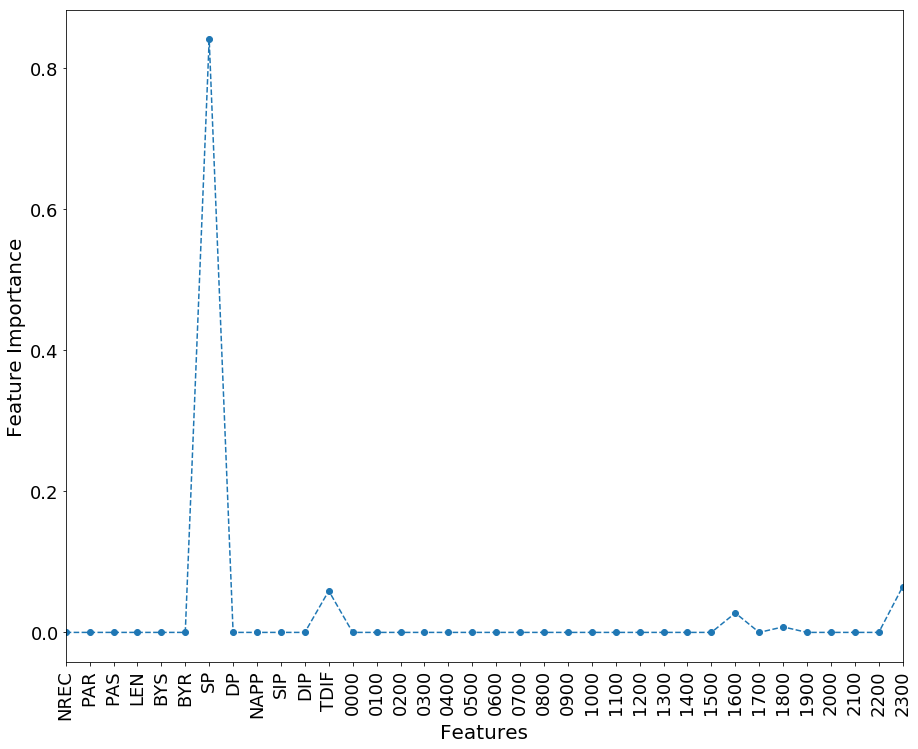

In [29]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [30]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.6          1000   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.990931076179

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4640     3     4643
1            57  1916     1973
__all__    4697  1919     6616

Accuracy of the  Bagging  model for test data is: 0.811366384522

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           988  158     1146
1           154  354      508
__all__    1142  512     1654

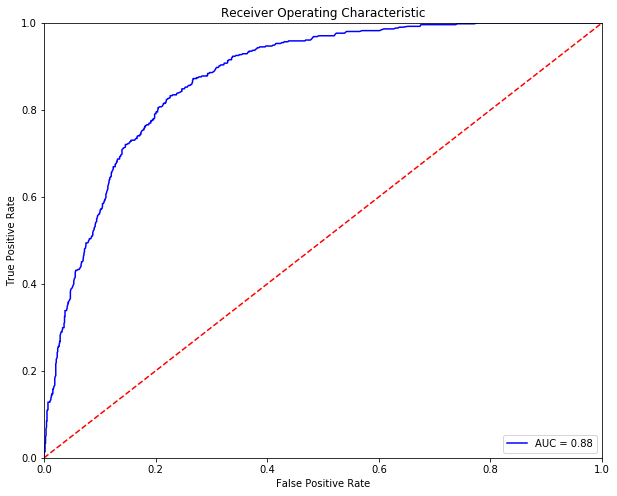

Optimal Threshold is 0.36
Accuracy of Logistic Model on training data is: 0.796251511487


Predicted   0.0  1.0  __all__
Actual                       
0.0         913  233     1146
1.0         104  404      508
__all__    1017  637     1654

In [31]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [32]:
table_80_70_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [33]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.934703748489


Predicted     0     1  __all__
Actual                        
0          4532   111     4643
1           321  1652     1973
__all__    4853  1763     6616

The test accuracy is: 0.799879081016


Predicted     0    1  __all__
Actual                       
0           991  155     1146
1           176  332      508
__all__    1167  487     1654

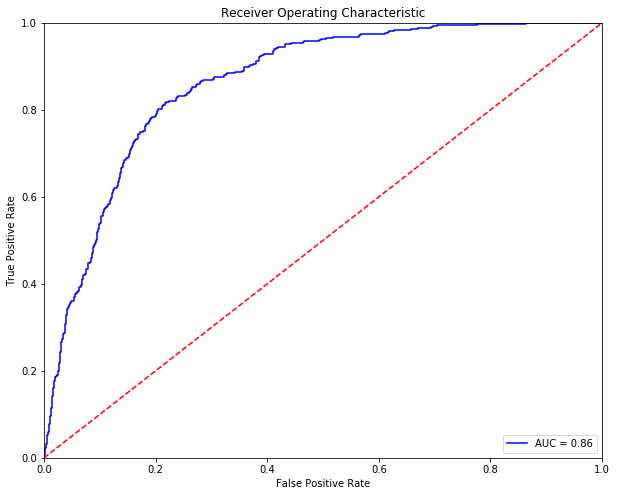

Optimal Threshold is 0.374420041963
Accuracy of Logistic Model on training data is: 0.79746070133


Predicted   0.0  1.0  __all__
Actual                       
0.0         915  231     1146
1.0         104  404      508
__all__    1019  635     1654

In [34]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [35]:
table_80_70_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [36]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.925181378548


Predicted     0     1  __all__
Actual                        
0          4432   211     4643
1           284  1689     1973
__all__    4716  1900     6616

The accuracy of the model on test data is: 0.746674727932


Predicted     0    1  __all__
Actual                       
0           946  200     1146
1           219  289      508
__all__    1165  489     1654

1654/1654 [==============================] - 0s     


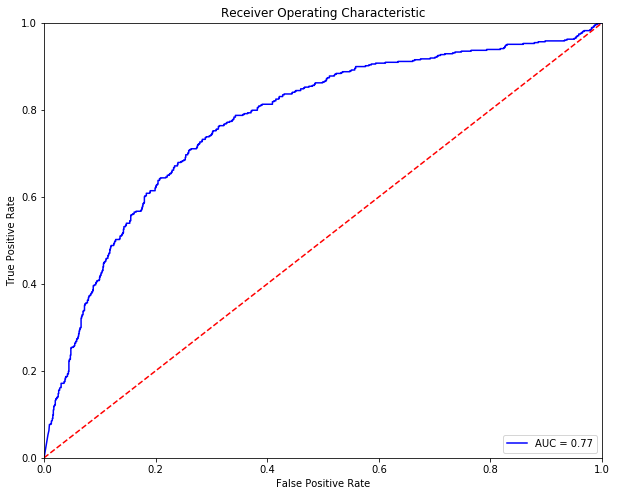

Optimal Threshold is 0.243852
Accuracy of Logistic Model on training data is: 0.721886336155


Predicted  0.0  1.0  __all__
Actual                      
0.0        828  318     1146
1.0        142  366      508
__all__    970  684     1654

In [37]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [38]:
table_80_70_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [39]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.5min finished


The accuracy of the model on training data is: 0.822853688029


Predicted     0     1  __all__
Actual                        
0          3926   717     4643
1           455  1518     1973
__all__    4381  2235     6616

The accuracy of the model on test data is: 0.805320435308


Predicted     0    1  __all__
Actual                       
0           960  186     1146
1           136  372      508
__all__    1096  558     1654

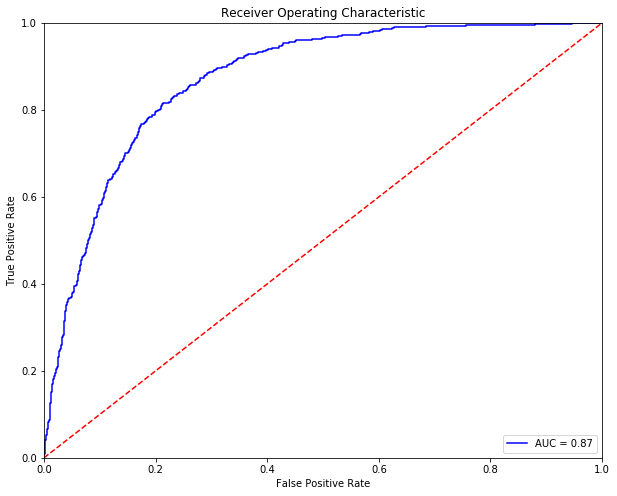

Optimal Threshold is 0.3536
Accuracy of Logistic Model on training data is: 0.796856106409


Predicted   0.0  1.0  __all__
Actual                       
0.0         913  233     1146
1.0         103  405      508
__all__    1016  638     1654

In [40]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [41]:
table_80_70_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [42]:
table_80_70_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)
table_80_70_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_70_train)

print("Comparision Table for Test Accuracies:")
display(table_80_70_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_70_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1973.0  4643.0    0.0    0.0  0.000000   
LogisticRegression          0.799577  1550.0  3740.0  903.0  423.0  0.194486   
RandomForestClassifier      0.807588  1491.0  3852.0  791.0  482.0  0.170364   
AdaBoostClassifier          0.814087  1377.0  4009.0  634.0  596.0  0.136550   
GradientBoostingClassifier  0.824365  1407.0  4047.0  596.0  566.0  0.128365   
ExtraTreeClassifier         0.808495  1381.0  3968.0  675.0  592.0  0.145380   
BaggingClassifier           0.990931  1916.0  4640.0    3.0   57.0  0.000646   
VotingClassifier            0.934704  1652.0  4532.0  111.0  321.0  0.023907   
Neural Network-1            0.925181  1689.0  4432.0  211.0  284.0  0.045445   
Neural-Network-2            0.822854  1518.0  3926.0  717.0  455.0  0.154426   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.214394  
RandomForestClassifier      0.244298  
AdaBoostClassifier          0.302078  
GradientBoostingClassifier  0.286873  
ExtraTreeClassifier         0.300051  
BaggingClassifier           0.028890  
VotingClassifier            0.162696  
Neural Network-1            0.143943  
Neural-Network-2            0.230613

Comparision Table for Test Accuracies:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.800484  328.0  996.0  150.0  180.0  0.130890   
LogisticRegression          0.798670  396.0  925.0  221.0  112.0  0.192845   
RandomForestClassifier      0.801088  376.0  949.0  197.0  132.0  0.171902   
AdaBoostClassifier          0.807134  349.0  986.0  160.0  159.0  0.139616   
GradientBoostingClassifier  0.812576  348.0  996.0  150.0  160.0  0.130890   
ExtraTreeClassifier         0.805320  344.0  988.0  158.0  164.0  0.137871   
BaggingClassifier           0.811366  354.0  988.0  158.0  154.0  0.137871   
VotingClassifier            0.799879  332.0  991.0  155.0  176.0  0.135253   
Neural Network-1            0.746675  289.0  946.0  200.0  219.0  0.174520   
Neural-Network-2            0.805320  372.0  960.0  186.0  136.0  0.162304   

                                 FNR  
index                                 
KNeighborsClassifier        0.354331  
LogisticRegression          0.220472  
RandomForestClassifier      0.259843  
AdaBoostClassifier          0.312992  
GradientBoostingClassifier  0.314961  
ExtraTreeClassifier         0.322835  
BaggingClassifier           0.303150  
VotingClassifier            0.346457  
Neural Network-1            0.431102  
Neural-Network-2            0.267717

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.790206  401.0  906.0  240.0  107.0  0.209424   
LogisticRegression          0.788996  400.0  905.0  241.0  108.0  0.210297   
RandomForestClassifier      0.796856  404.0  914.0  232.0  104.0  0.202443   
AdaBoostClassifier          0.796856  404.0  914.0  232.0  104.0  0.202443   
GradientBoostingClassifier  0.799879  405.0  918.0  228.0  103.0  0.198953   
ExtraTreeClassifier         0.805320  344.0  988.0  158.0  164.0  0.137871   
BaggingClassifier           0.796252  404.0  913.0  233.0  104.0  0.203316   
VotingClassifier            0.797461  404.0  915.0  231.0  104.0  0.201571   
Neural Network-1            0.721886  366.0  828.0  318.0  142.0  0.277487   
Neural-Network-2            0.796856  405.0  913.0  233.0  103.0  0.203316   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.210630   0.327979  0.864256  
LogisticRegression          0.212598   0.479228  0.870132  
RandomForestClassifier      0.204724   0.340086  0.855453  
AdaBoostClassifier          0.204724   0.498636  0.874723  
GradientBoostingClassifier  0.202756   0.362100  0.878697  
ExtraTreeClassifier         0.322835   0.448454  0.850954  
BaggingClassifier           0.204724   0.360000  0.875368  
VotingClassifier            0.204724   0.374420  0.862895  
Neural Network-1            0.279528   0.243852  0.774104  
Neural-Network-2            0.202756   0.353600  0.871585

#### Random State 10

In [43]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_10.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  3030  230.950495   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...   599  158.008347   

                                                          PAS        LEN  \
Source_User                                                                
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  80.524092  84.155116   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  57.856427  82.028381   

                                                            BYS  \
Source_User                                                       
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  9686.861716   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  6161.512521   

                                                              BYR      SP  \
Source_User                                                                 
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  287727.528383  2741.0   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  198461.532554   587.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  11.0    40   63  820   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  12.0    30   70  210   

                                                            TDIF  0000  0100  \
Source_User                                                                    
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   2395.224422   195   256   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  12098.198664     0     3   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   110    55    63    53   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     3     2     4     2   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...    56    31    79    81   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     0    34    70    92   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...    39    75    98    81   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...   117    30    10    14   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   159   264   181   142   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     7     5    25    37   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   177   135   120   184   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...    61    27    27    25   

                                                    2200  2300  
Source_User                                                     
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   240   156  
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     1     3

In [44]:
### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

1 -> Infected
0 -> Uninfected


Source_User
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3449af4e82e30f9f87    0
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce851fca5724939971862    1
06fe39332e5261ed8a5f1bb9d62559deb0de1620963ebbded14eecf78b8a0a20    0
5455eddbb8ee814c41a27e8676a6cc34faa6fc295c6e92588fc75dbe7f61369b    0
47a99c45d555e42658dbf94be7417ec6c327ecfc05ed5c57eaac1de3bd43bb86    1
60ff3ff13bb2e6a16dc866bc314964cc6d60b1e9891d805e7d9e99b1864ae896    1
a4244338cc086f69de152063f5b11482be2d007a5da089331dc2fe778e459e26    1
70de2ff22d8dd1433aa38947470f94f455bcbdabb1789e81332ba5c390408acc    1
6c49763f6a507ebf7aff12e40a61cfe3624fca5d5ac9dc1b86ac38c68ca4b1ba    0
ab60d8ea5924263ddfde9661ee4a4081f95679c77492da4479cd0350f56c7de3    0
Name: Target, dtype: int64

In [45]:
### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [46]:
## Table to store training and test measures
table_80_70_10_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_10_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_10_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [47]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  manhattan           50  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4647     0     4647
1             0  1969     1969
__all__    4647  1969     6616

Accuracy of the  KNN  model for test data is: 0.809552599758

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           988  154     1142
1           161  351      512
__all__    1149  505     1654

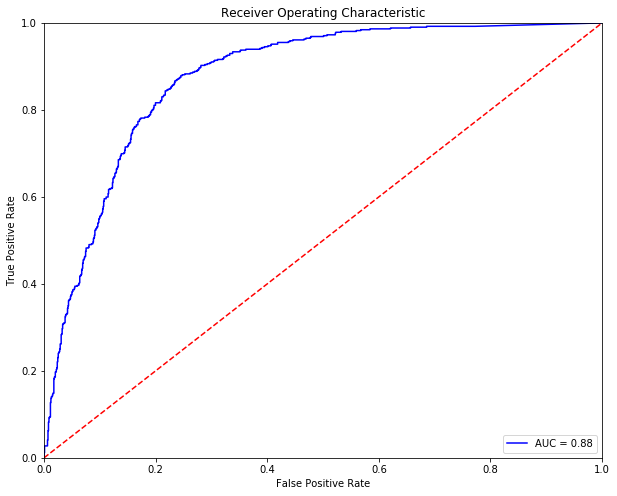

Optimal Threshold is 0.361130302069
Accuracy of Logistic Model on training data is: 0.803506650544


Predicted   0.0  1.0  __all__
Actual                       
0.0         918  224     1142
1.0         101  411      512
__all__    1019  635     1654

In [48]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [49]:
table_80_70_10_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_10_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [50]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.7  False           True                0.5        50  multinomial   

             6       7      8  
index  penalty  solver    tol  
0           l2     sag  1e-05

Accuracy of the  Logistic  model for the training data is: 0.799274486094

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4106   541     4647
1           787  1182     1969
__all__    4893  1723     6616

Accuracy of the  Logistic  model for test data is: 0.80169286578

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1010  132     1142
1           196  316      512
__all__    1206  448     1654

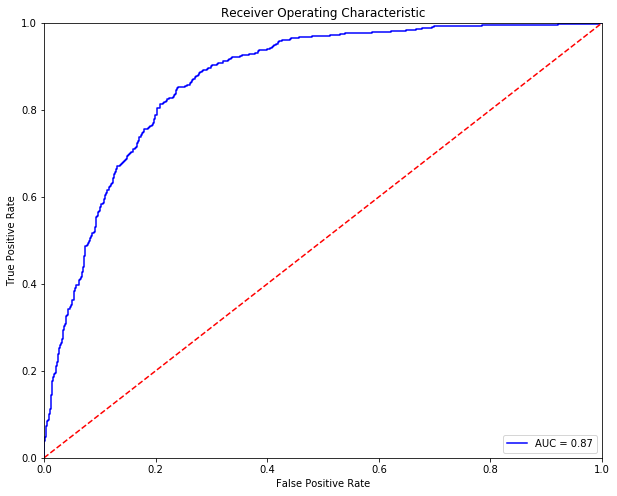

Optimal Threshold is 0.410464908147
Accuracy of Logistic Model on training data is: 0.796856106409


Predicted   0.0  1.0  __all__
Actual                       
0.0         911  231     1142
1.0         105  407      512
__all__    1016  638     1654

In [51]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [52]:
table_80_70_10_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_10_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [53]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[10000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1         10000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.799879081016

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3830   817     4647
1           507  1462     1969
__all__    4337  2279     6616

Accuracy of the  Random Forest Trees  model for test data is: 0.808343409915

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           936  206     1142
1           111  401      512
__all__    1047  607     1654

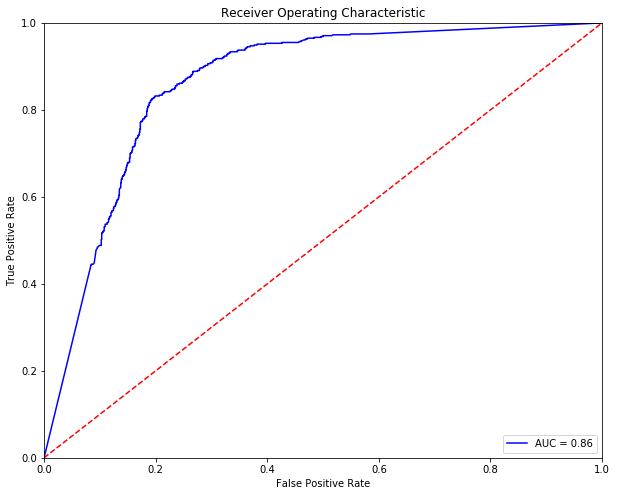

Optimal Threshold is 0.464083926809
Accuracy of Logistic Model on training data is: 0.811970979444


Predicted   0.0  1.0  __all__
Actual                       
0.0         928  214     1142
1.0          97  415      512
__all__    1025  629     1654

In [54]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [55]:
table_80_70_10_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_10_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

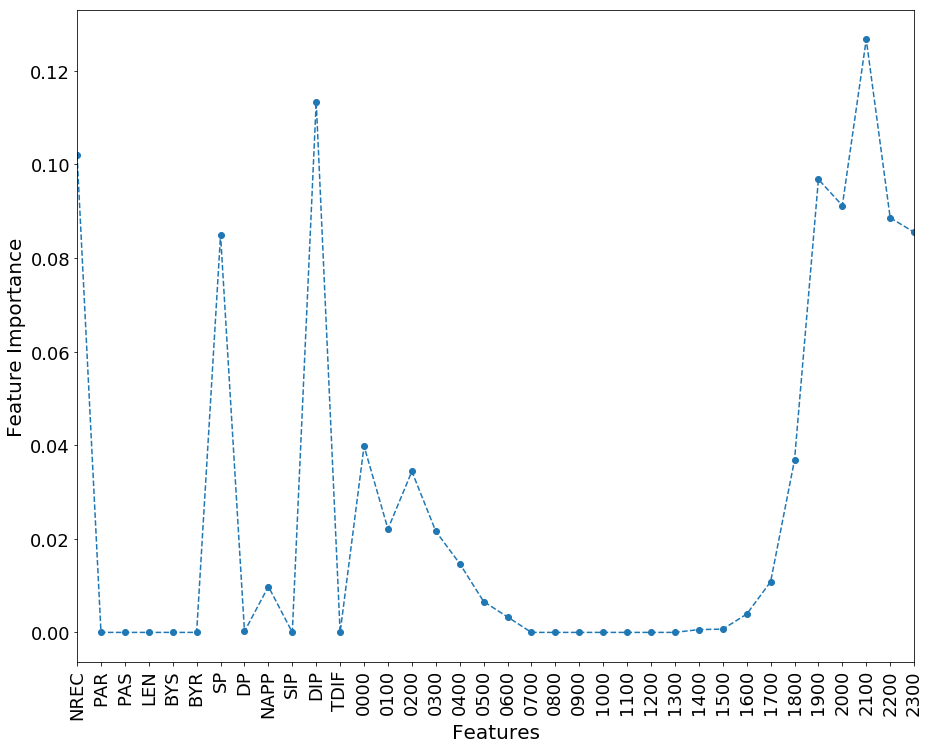

In [56]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [57]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME            1.5           150             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.803960096735

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3976   671     4647
1           626  1343     1969
__all__    4602  2014     6616

Accuracy of the  AdaBoostClassifier  model for test data is: 0.804111245466

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           972  170     1142
1           154  358      512
__all__    1126  528     1654

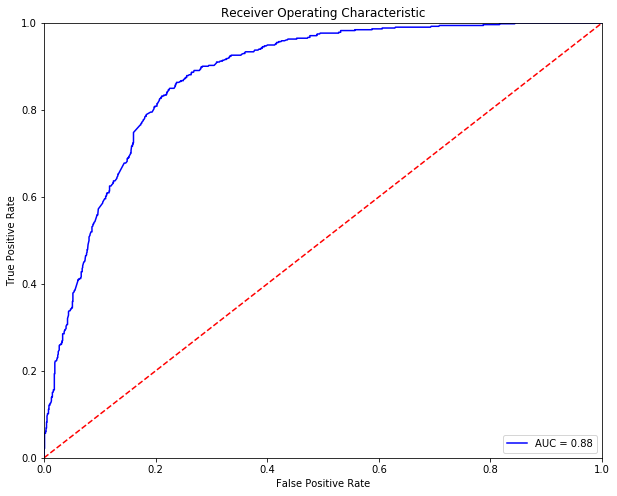

Optimal Threshold is 0.494776988413
Accuracy of Logistic Model on training data is: 0.802902055623


Predicted   0.0  1.0  __all__
Actual                       
0.0         921  221     1142
1.0         105  407      512
__all__    1026  628     1654

In [58]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [59]:
table_80_70_10_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_10_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

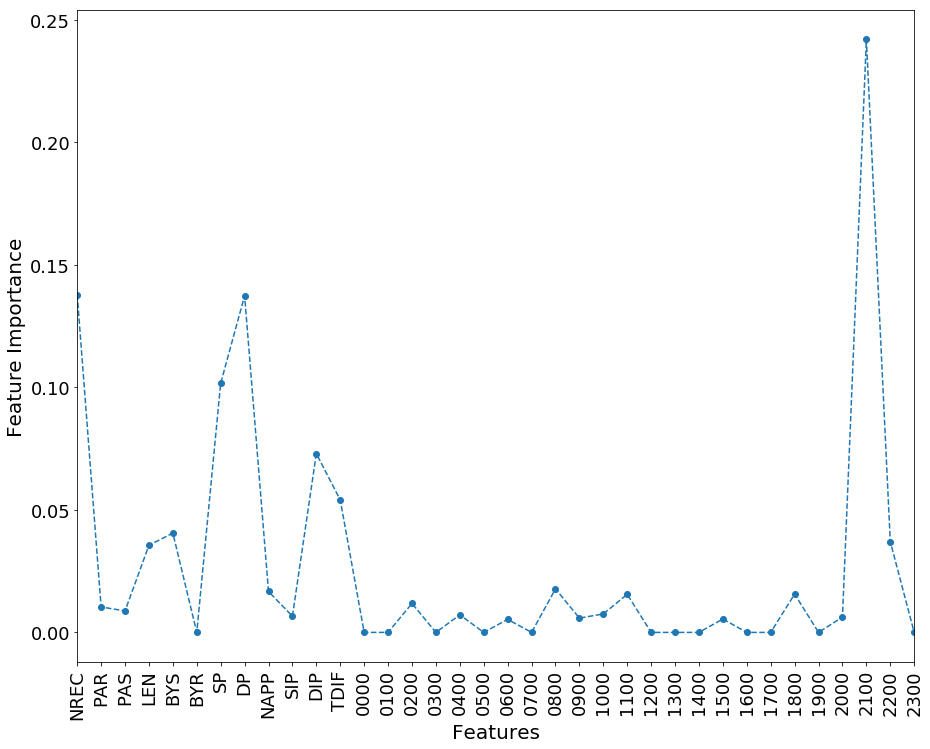

In [60]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [61]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1         2                 3  \
index  criterion  learning_rate      loss  min_samples_leaf   
0            mse           0.03  deviance                20   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1           100             0        0.7

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.812575574365

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3984   663     4647
1           577  1392     1969
__all__    4561  2055     6616

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.807738814994

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           965  177     1142
1           141  371      512
__all__    1106  548     1654

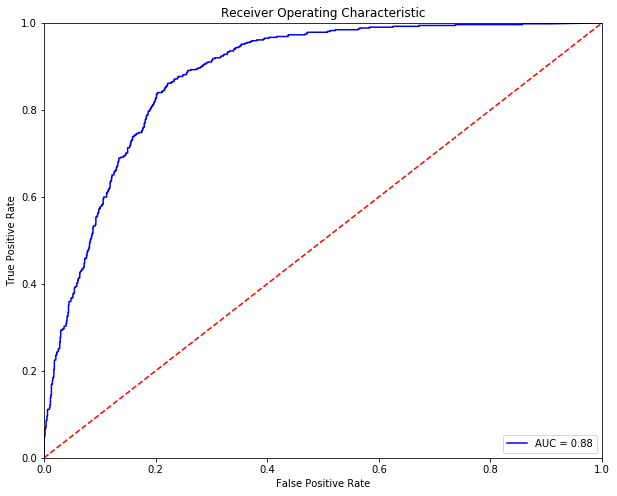

Optimal Threshold is 0.414849524422
Accuracy of Logistic Model on training data is: 0.807134220073


Predicted   0.0  1.0  __all__
Actual                       
0.0         922  220     1142
1.0          99  413      512
__all__    1021  633     1654

In [62]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [63]:
table_80_70_10_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_10_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

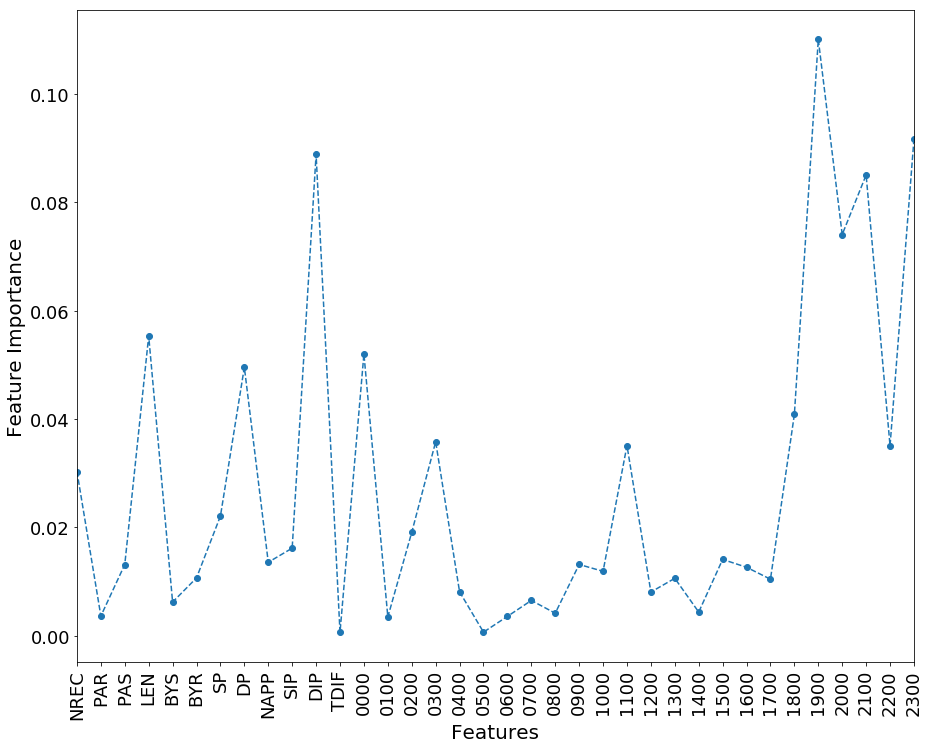

In [64]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [65]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0        entropy         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     5                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.808192261185

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3984   663     4647
1           606  1363     1969
__all__    4590  2026     6616

Accuracy of the  Extra Decision Tree  model for test data is: 0.790205562273

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           951  191     1142
1           156  356      512
__all__    1107  547     1654

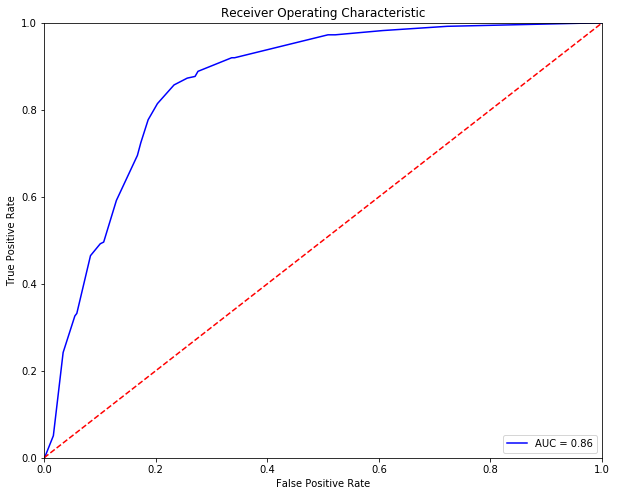

Optimal Threshold is 0.40414507772
Accuracy of Logistic Model on training data is: 0.802297460701


Predicted   0.0  1.0  __all__
Actual                       
0.0         929  213     1142
1.0         114  398      512
__all__    1043  611     1654

In [66]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [67]:
table_80_70_10_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [68]:
%%capture
table_80_70_10_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

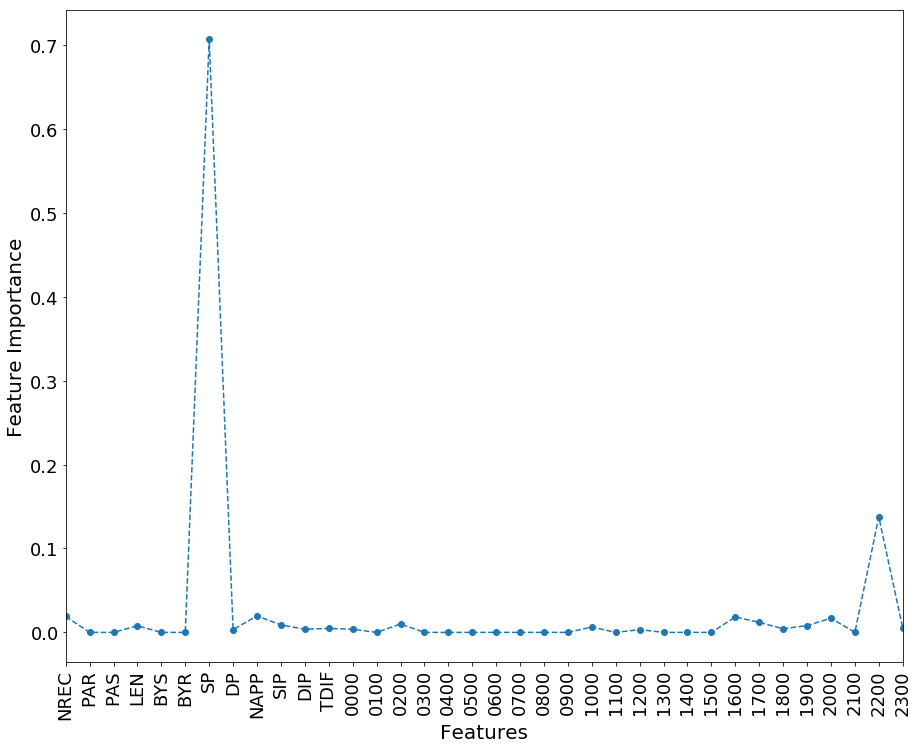

In [69]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [70]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.3          0.4           500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.953899637243

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4575    72     4647
1           233  1736     1969
__all__    4808  1808     6616

Accuracy of the  Bagging  model for test data is: 0.81015719468

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           962  180     1142
1           134  378      512
__all__    1096  558     1654

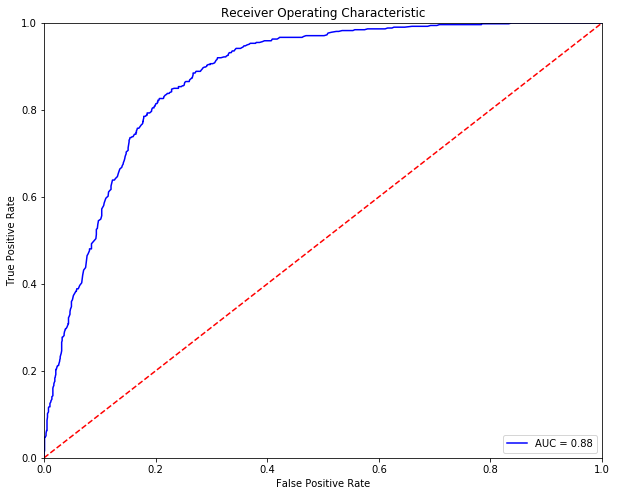

Optimal Threshold is 0.426
Accuracy of Logistic Model on training data is: 0.805320435308


Predicted   0.0  1.0  __all__
Actual                       
0.0         920  222     1142
1.0         100  412      512
__all__    1020  634     1654

In [71]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [72]:
table_80_70_10_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_10_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [73]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.936517533253


Predicted     0     1  __all__
Actual                        
0          4567    80     4647
1           340  1629     1969
__all__    4907  1709     6616

The test accuracy is: 0.789600967352


Predicted     0    1  __all__
Actual                       
0           973  169     1142
1           179  333      512
__all__    1152  502     1654

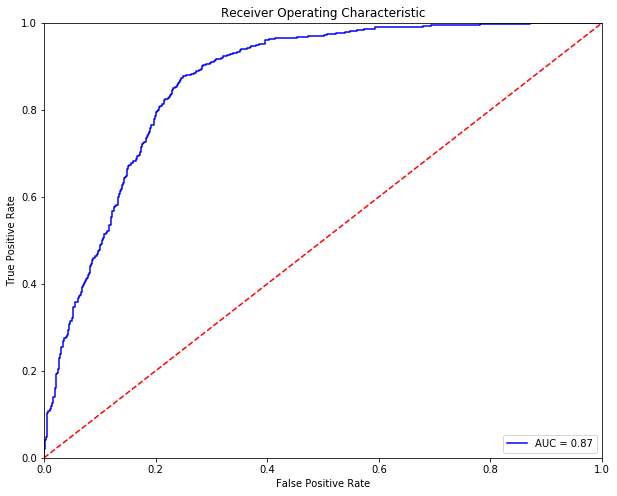

Optimal Threshold is 0.400545889187
Accuracy of Logistic Model on training data is: 0.796856106409


Predicted   0.0  1.0  __all__
Actual                       
0.0         911  231     1142
1.0         105  407      512
__all__    1016  638     1654

In [74]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [75]:
table_80_70_10_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_10_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [76]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.920646916494


Predicted     0     1  __all__
Actual                        
0          4536   111     4647
1           414  1555     1969
__all__    4950  1666     6616

The accuracy of the model on test data is: 0.784764207981


Predicted     0    1  __all__
Actual                       
0           998  144     1142
1           212  300      512
__all__    1210  444     1654

  32/1654 [..............................] - ETA: 0s

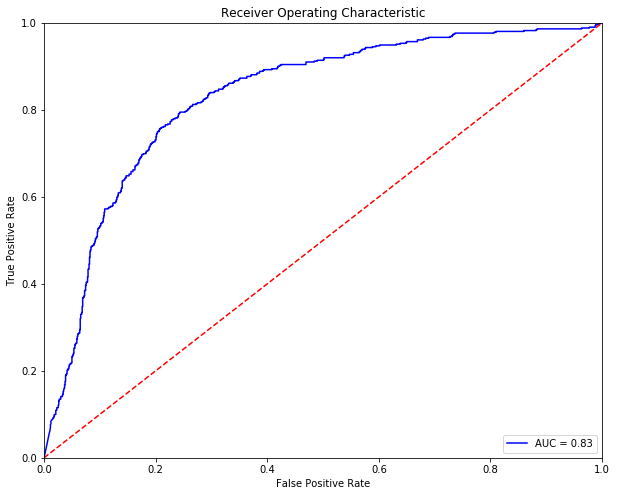

Optimal Threshold is 0.17065
Accuracy of Logistic Model on training data is: 0.773276904474


Predicted   0.0  1.0  __all__
Actual                       
0.0         884  258     1142
1.0         117  395      512
__all__    1001  653     1654

In [77]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [78]:
table_80_70_10_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_10_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [79]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.1min finished


The accuracy of the model on training data is: 0.821191051995


Predicted     0     1  __all__
Actual                        
0          3981   666     4647
1           517  1452     1969
__all__    4498  2118     6616

The accuracy of the model on test data is: 0.801088270859


Predicted     0    1  __all__
Actual                       
0           946  196     1142
1           133  379      512
__all__    1079  575     1654

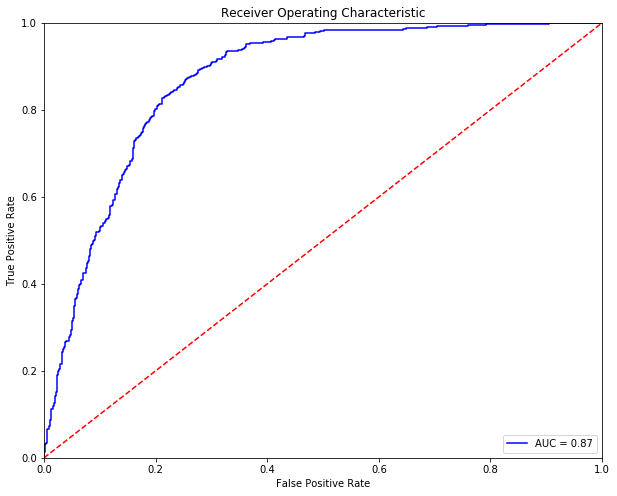

Optimal Threshold is 0.380272
Accuracy of Logistic Model on training data is: 0.801088270859


Predicted   0.0  1.0  __all__
Actual                       
0.0         915  227     1142
1.0         102  410      512
__all__    1017  637     1654

In [80]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [81]:
table_80_70_10_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_10_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [82]:
table_80_70_10_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_10_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_10_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_70_10_test.set_index(['index'],drop=True,inplace=True)
table_80_70_10_train.set_index(['index'],drop=True,inplace=True)
table_80_70_10_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_70_10_train)

print("Comparision Table for Test Accuracies:")
display(table_80_70_10_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_70_10_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1969.0  4647.0    0.0    0.0  0.000000   
LogisticRegression          0.799274  1182.0  4106.0  541.0  787.0  0.116419   
RandomForestClassifier      0.799879  1462.0  3830.0  817.0  507.0  0.175812   
AdaBoostClassifier          0.803960  1343.0  3976.0  671.0  626.0  0.144394   
GradientBoostingClassifier  0.812576  1392.0  3984.0  663.0  577.0  0.142673   
ExtraTreeClassifier         0.808192  1363.0  3984.0  663.0  606.0  0.142673   
BaggingClassifier           0.953900  1736.0  4575.0   72.0  233.0  0.015494   
VotingClassifier            0.936518  1629.0  4567.0   80.0  340.0  0.017215   
Neural Network-1            0.920647  1555.0  4536.0  111.0  414.0  0.023886   
Neural-Network-2            0.821191  1452.0  3981.0  666.0  517.0  0.143318   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.399695  
RandomForestClassifier      0.257491  
AdaBoostClassifier          0.317928  
GradientBoostingClassifier  0.293042  
ExtraTreeClassifier         0.307770  
BaggingClassifier           0.118334  
VotingClassifier            0.172676  
Neural Network-1            0.210259  
Neural-Network-2            0.262570

Comparision Table for Test Accuracies:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.809553  351.0   988.0  154.0  161.0  0.134851   
LogisticRegression          0.801693  316.0  1010.0  132.0  196.0  0.115587   
RandomForestClassifier      0.808343  401.0   936.0  206.0  111.0  0.180385   
AdaBoostClassifier          0.804111  358.0   972.0  170.0  154.0  0.148862   
GradientBoostingClassifier  0.807739  371.0   965.0  177.0  141.0  0.154991   
ExtraTreeClassifier         0.790206  356.0   951.0  191.0  156.0  0.167250   
BaggingClassifier           0.810157  378.0   962.0  180.0  134.0  0.157618   
VotingClassifier            0.789601  333.0   973.0  169.0  179.0  0.147986   
Neural Network-1            0.784764  300.0   998.0  144.0  212.0  0.126095   
Neural-Network-2            0.801088  379.0   946.0  196.0  133.0  0.171629   

                                 FNR  
index                                 
KNeighborsClassifier        0.314453  
LogisticRegression          0.382812  
RandomForestClassifier      0.216797  
AdaBoostClassifier          0.300781  
GradientBoostingClassifier  0.275391  
ExtraTreeClassifier         0.304688  
BaggingClassifier           0.261719  
VotingClassifier            0.349609  
Neural Network-1            0.414062  
Neural-Network-2            0.259766

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.803507  411.0  918.0  224.0  101.0  0.196147   
LogisticRegression          0.796856  407.0  911.0  231.0  105.0  0.202277   
RandomForestClassifier      0.811971  415.0  928.0  214.0   97.0  0.187391   
AdaBoostClassifier          0.802902  407.0  921.0  221.0  105.0  0.193520   
GradientBoostingClassifier  0.807134  413.0  922.0  220.0   99.0  0.192644   
ExtraTreeClassifier         0.802297  398.0  929.0  213.0  114.0  0.186515   
BaggingClassifier           0.805320  412.0  920.0  222.0  100.0  0.194396   
VotingClassifier            0.796856  407.0  911.0  231.0  105.0  0.202277   
Neural Network-1            0.773277  395.0  884.0  258.0  117.0  0.225919   
Neural-Network-2            0.801088  410.0  915.0  227.0  102.0  0.198774   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.197266   0.361130  0.876199  
LogisticRegression          0.205078   0.410465  0.871140  
RandomForestClassifier      0.189453   0.464084  0.861933  
AdaBoostClassifier          0.205078   0.494777  0.876284  
GradientBoostingClassifier  0.193359   0.414850  0.881593  
ExtraTreeClassifier         0.222656   0.404145  0.861798  
BaggingClassifier           0.195312   0.426000  0.876496  
VotingClassifier            0.205078   0.400546  0.867353  
Neural Network-1            0.228516   0.170650  0.829113  
Neural-Network-2            0.199219   0.380272  0.870391

#### Random State 20

In [83]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_20.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   651   35.807988   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  4059  321.478197   

                                                           PAS         LEN  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   35.328725  108.442396   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  131.395910   73.695245   

                                                             BYS  \
Source_User                                                        
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   3976.233487   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  31586.025868   

                                                              BYR      SP  \
Source_User                                                                 
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   37072.858679   639.0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  413326.700419  3627.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   8.0    21   23  158   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  18.0    40   31  974   

                                                            TDIF  0000  0100  \
Source_User                                                                    
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...  11131.820276     6     0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   1803.300813   196   310   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     2     0     0     0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   532   308   202   101   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     0    13     8    34   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...    45   281    95    38   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    95    39    76    71   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...    93    95   206   102   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    74    66   114    27   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   104    84   194   144   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    14     0     0     7   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   116   161   158   138   

                                                    2200  2300  
Source_User                                                     
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     3     2  
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   159   197

In [84]:
### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

1 -> Infected
0 -> Uninfected


Source_User
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d641329bc603046dfcc4    0
307c636564c5ec9897e5062605e2982daf781f0f82b0234f2cbc55919f8d04e2    0
11e8b7b973c885d9d2560baeec4673bc6b13aab08d9e49bc9c519727595e4d3e    1
41851f48304067368da8f12794e2f539330cc7ef6732c1440ed4c5eb06b9cc5d    0
08402d90e55ea64677880c21fc3850422ad2e08f730282d271027f0fea60b4b6    1
952aed50327c6ac4e19a033bb585959b33ea2ca897f985dc33a1bb6a1f3d7cc7    0
6b42f8e7f92d2fccc0fae12167ef5e929f394e87e9c70bb36ac160bf6d6cb0f4    0
c9140a85217daf0d18148d489fa6d3293cbe499584b12e28be0e381a20eeb737    1
647e8a6690cd21f7bae287782ec6a621cae3a5ba6f37b779d99f28a7851b1bfc    0
42d06643547a80b9343fa1a09ca32b0c3bb84caa31bfb45c629b6835072e364b    0
Name: Target, dtype: int64

In [85]:
### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [86]:
## Table to store training and test measures
table_80_70_20_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_20_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_20_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [87]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  manhattan           50  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4632     0     4632
1             0  1984     1984
__all__    4632  1984     6616

Accuracy of the  KNN  model for test data is: 0.813180169287

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1018  139     1157
1           170  327      497
__all__    1188  466     1654

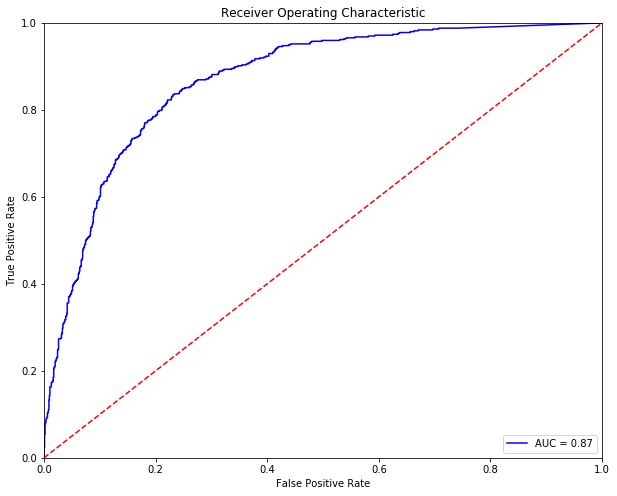

Optimal Threshold is 0.336884654846
Accuracy of Logistic Model on training data is: 0.795646916566


Predicted   0.0  1.0  __all__
Actual                       
0.0         921  236     1157
1.0         102  395      497
__all__    1023  631     1654

In [88]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [89]:
table_80_70_20_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_20_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [90]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.7  False          False                0.5       100  multinomial   

             6       7    8  
index  penalty  solver  tol  
0           l2     sag  0.1

Accuracy of the  Logistic  model for the training data is: 0.798065296252

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3737   895     4632
1           441  1543     1984
__all__    4178  2438     6616

Accuracy of the  Logistic  model for test data is: 0.801088270859

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           939  218     1157
1           111  386      497
__all__    1050  604     1654

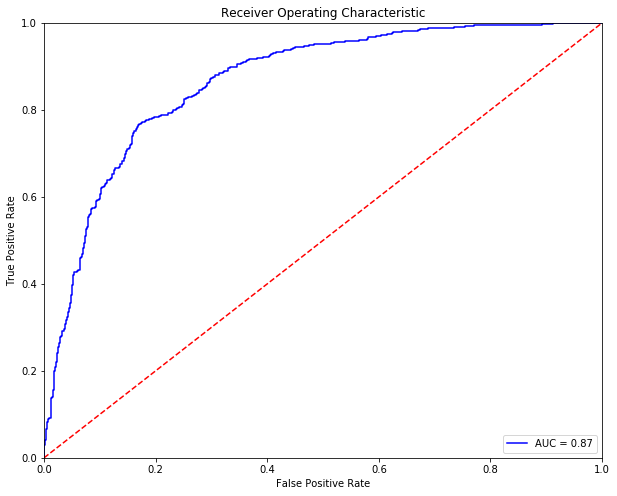

Optimal Threshold is 0.482061873305
Accuracy of Logistic Model on training data is: 0.78899637243


Predicted   0.0  1.0  __all__
Actual                       
0.0         914  243     1157
1.0         106  391      497
__all__    1020  634     1654

In [91]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [92]:
table_80_70_20_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_20_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [93]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[10000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1         10000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.800483675937

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3795   837     4632
1           483  1501     1984
__all__    4278  2338     6616

Accuracy of the  Random Forest Trees  model for test data is: 0.804715840387

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           955  202     1157
1           121  376      497
__all__    1076  578     1654

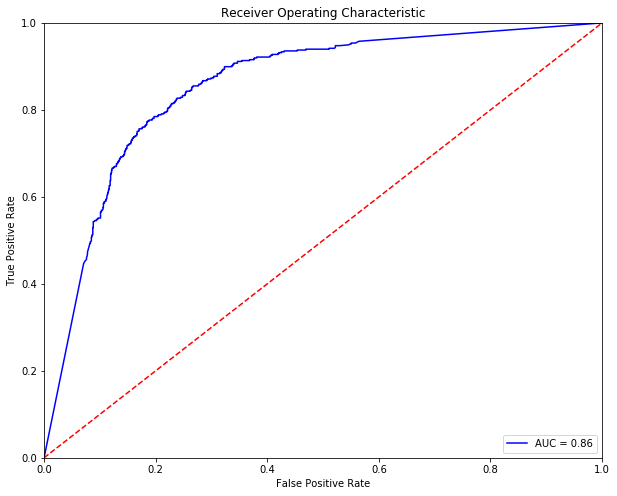

Optimal Threshold is 0.363405458772
Accuracy of Logistic Model on training data is: 0.789600967352


Predicted   0.0  1.0  __all__
Actual                       
0.0         914  243     1157
1.0         105  392      497
__all__    1019  635     1654

In [94]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [95]:
table_80_70_20_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_20_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

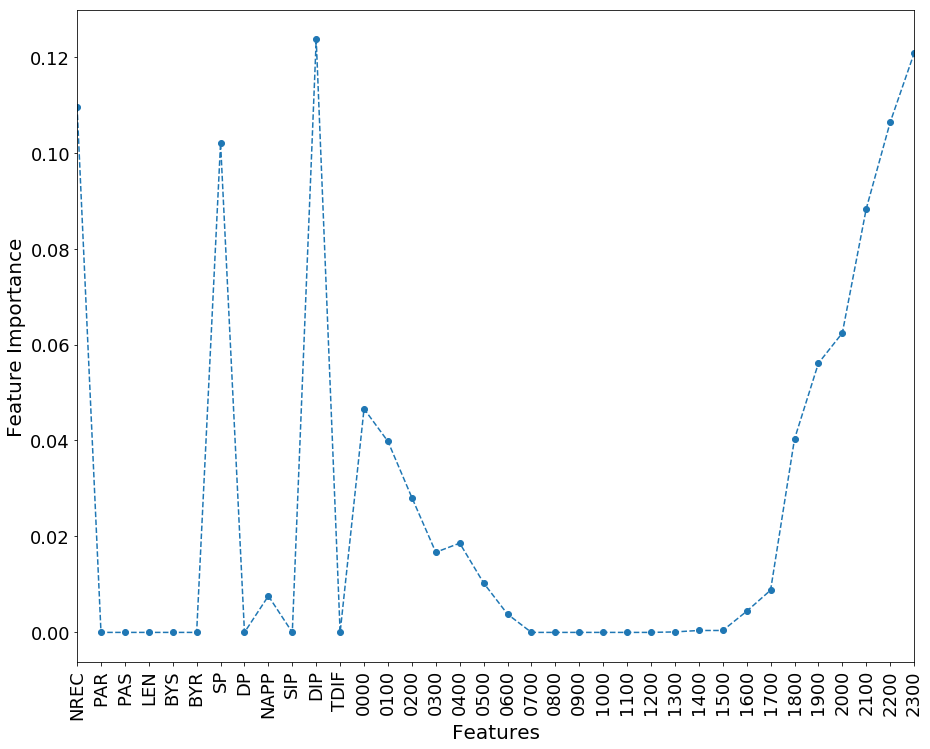

In [96]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [97]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME            0.5           150             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.805018137848

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3965   667     4632
1           623  1361     1984
__all__    4588  2028     6616

Accuracy of the  AdaBoostClassifier  model for test data is: 0.816203143894

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1003  154     1157
1           150  347      497
__all__    1153  501     1654

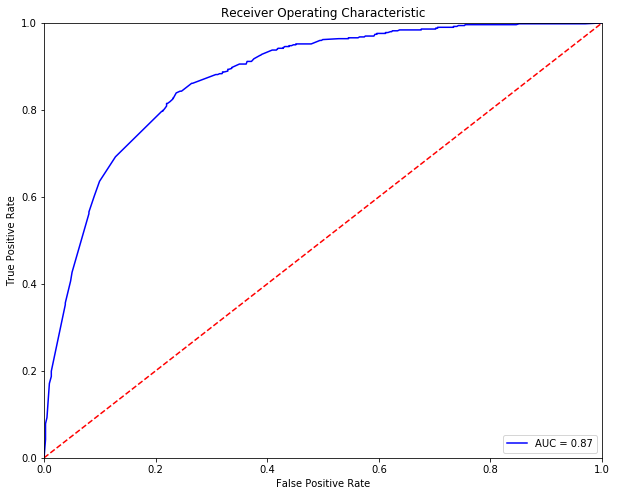

Optimal Threshold is 0.498020836779
Accuracy of Logistic Model on training data is: 0.818016928658


Predicted   0.0  1.0  __all__
Actual                       
0.0        1009  148     1157
1.0         153  344      497
__all__    1162  492     1654

In [98]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [99]:
table_80_70_20_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_20_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

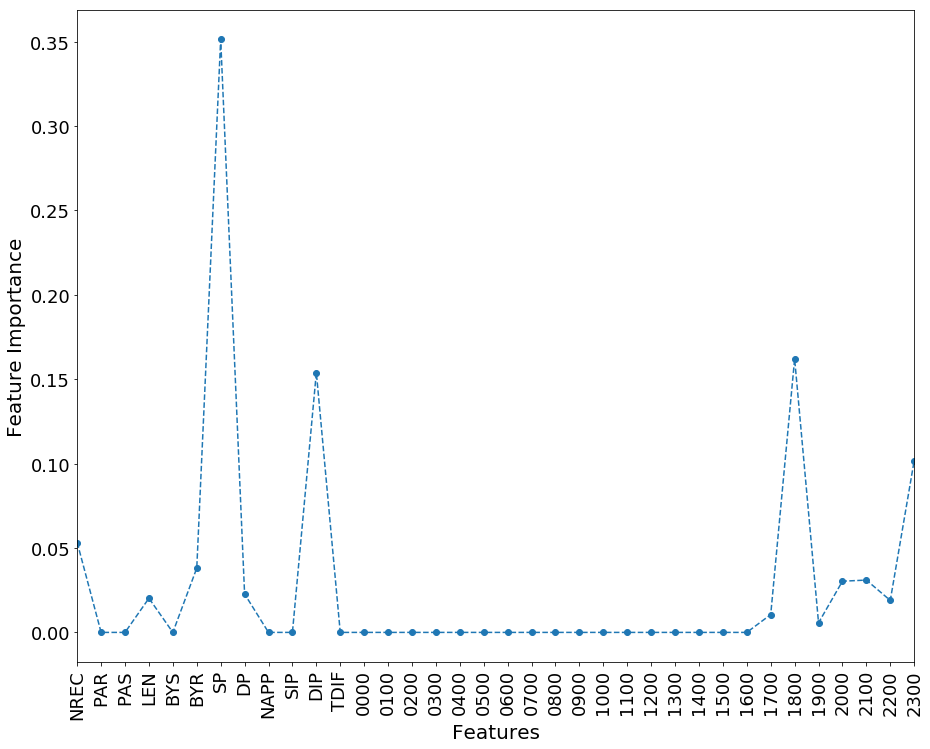

In [100]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [101]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse           0.05  exponential                 5   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.2            50             0        0.5

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.806983071342

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3955   677     4632
1           600  1384     1984
__all__    4555  2061     6616

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.807738814994

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           991  166     1157
1           152  345      497
__all__    1143  511     1654

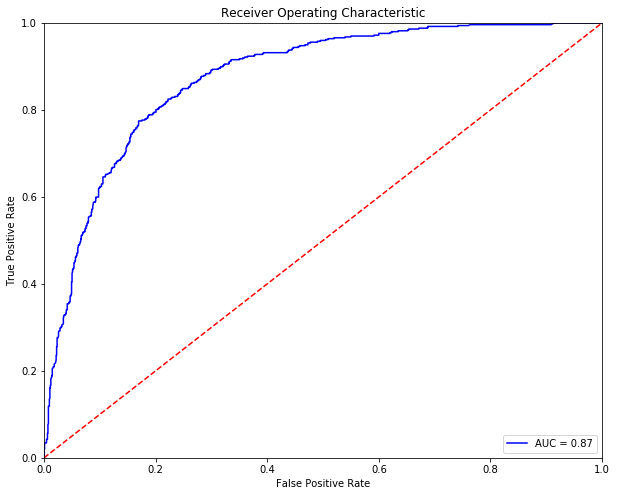

Optimal Threshold is 0.37340777921
Accuracy of Logistic Model on training data is: 0.799274486094


Predicted   0.0  1.0  __all__
Actual                       
0.0         925  232     1157
1.0         100  397      497
__all__    1025  629     1654

In [102]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [103]:
table_80_70_20_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_20_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

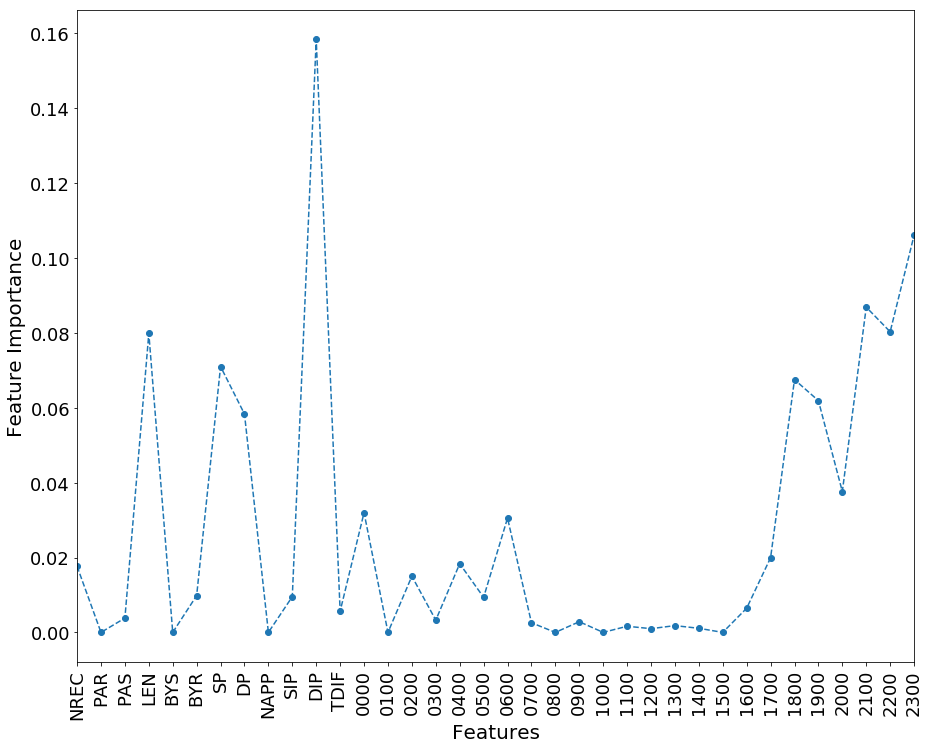

In [104]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [105]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0        entropy         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.819981862152

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3989   643     4632
1           548  1436     1984
__all__    4537  2079     6616

Accuracy of the  Extra Decision Tree  model for test data is: 0.795646916566

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           981  176     1157
1           162  335      497
__all__    1143  511     1654

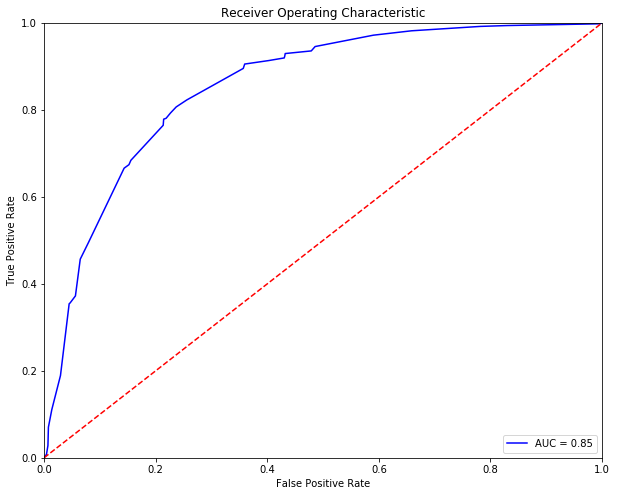

Optimal Threshold is 0.333333333333
Accuracy of Logistic Model on training data is: 0.783555018138


Predicted   0.0  1.0  __all__
Actual                       
0.0         909  248     1157
1.0         110  387      497
__all__    1019  635     1654

In [106]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [107]:
table_80_70_20_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [108]:
%%capture
table_80_70_20_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

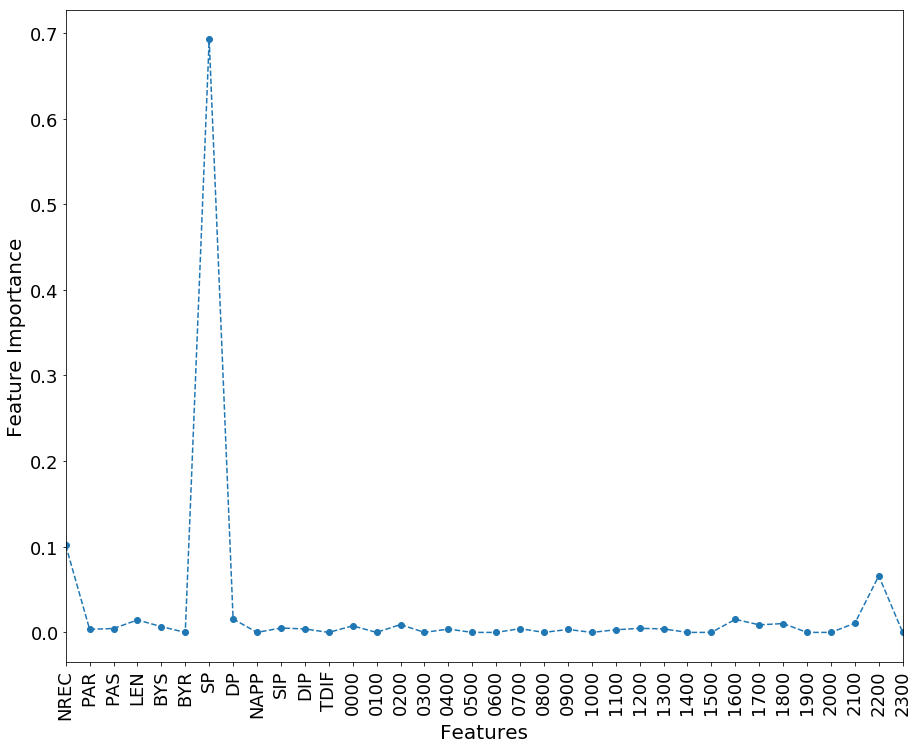

In [109]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [110]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.6          1500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.990931076179

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4630     2     4632
1            58  1926     1984
__all__    4688  1928     6616

Accuracy of the  Bagging  model for test data is: 0.810761789601

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           985  172     1157
1           141  356      497
__all__    1126  528     1654

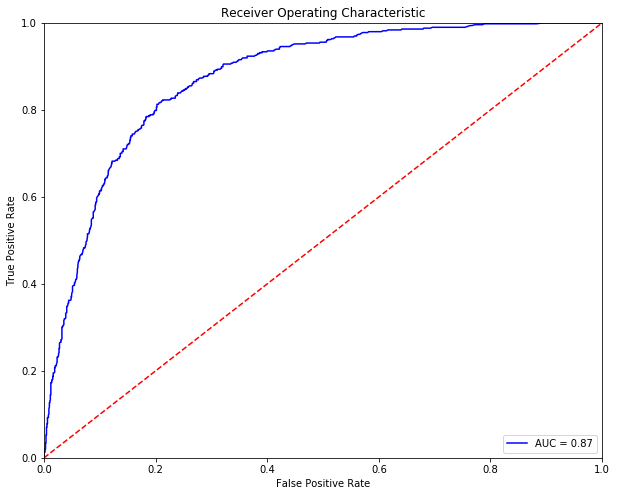

Optimal Threshold is 0.389333333333
Accuracy of Logistic Model on training data is: 0.799274486094


Predicted   0.0  1.0  __all__
Actual                       
0.0         925  232     1157
1.0         100  397      497
__all__    1025  629     1654

In [111]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [112]:
table_80_70_20_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_20_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [113]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.936819830713


Predicted     0     1  __all__
Actual                        
0          4533    99     4632
1           319  1665     1984
__all__    4852  1764     6616

The test accuracy is: 0.813784764208


Predicted     0    1  __all__
Actual                       
0          1016  141     1157
1           167  330      497
__all__    1183  471     1654

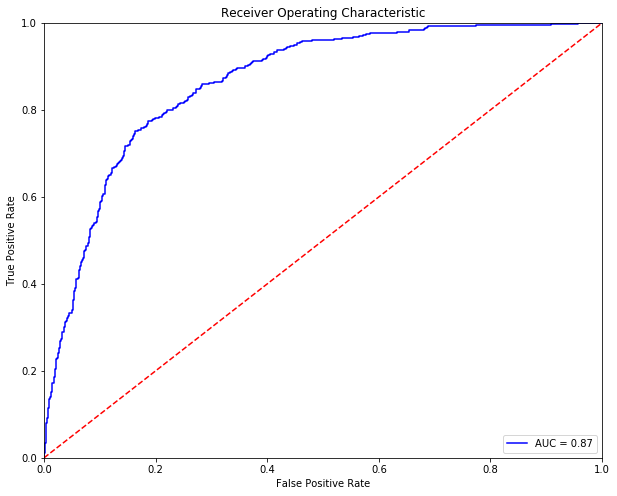

Optimal Threshold is 0.376694104679
Accuracy of Logistic Model on training data is: 0.788391777509


Predicted   0.0  1.0  __all__
Actual                       
0.0         913  244     1157
1.0         106  391      497
__all__    1019  635     1654

In [114]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [115]:
table_80_70_20_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_20_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [116]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.934703748561


Predicted     0     1  __all__
Actual                        
0          4494   138     4632
1           294  1690     1984
__all__    4788  1828     6616

The accuracy of the model on test data is: 0.781136638452


Predicted     0    1  __all__
Actual                       
0           994  163     1157
1           199  298      497
__all__    1193  461     1654

  32/1654 [..............................] - ETA: 0s

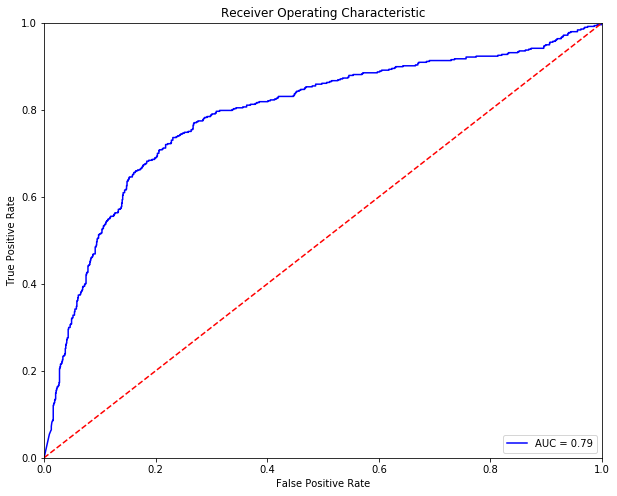

Optimal Threshold is 0.200291
Accuracy of Logistic Model on training data is: 0.747883917775


Predicted  0.0  1.0  __all__
Actual                      
0.0        866  291     1157
1.0        126  371      497
__all__    992  662     1654

In [117]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [118]:
table_80_70_20_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_20_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [119]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.7min finished


The accuracy of the model on training data is: 0.813935912938


Predicted     0     1  __all__
Actual                        
0          3961   671     4632
1           560  1424     1984
__all__    4521  2095     6616

The accuracy of the model on test data is: 0.803506650544


Predicted     0    1  __all__
Actual                       
0           981  176     1157
1           149  348      497
__all__    1130  524     1654

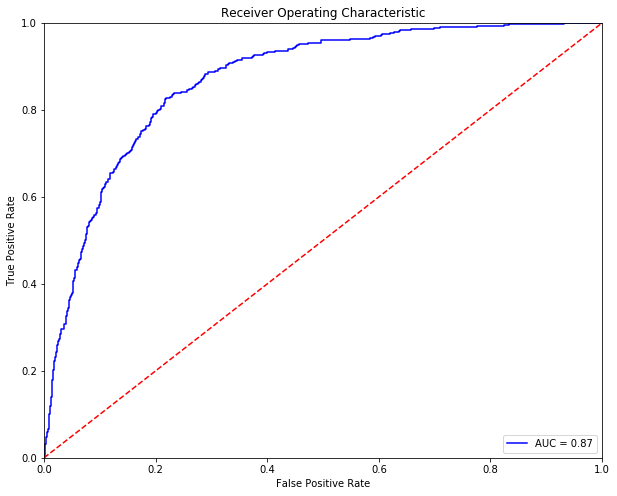

Optimal Threshold is 0.286993
Accuracy of Logistic Model on training data is: 0.796251511487


Predicted   0.0  1.0  __all__
Actual                       
0.0         922  235     1157
1.0         102  395      497
__all__    1024  630     1654

In [120]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [121]:
table_80_70_20_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_20_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [122]:
table_80_70_20_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_20_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_20_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_70_20_test.set_index(['index'],drop=True,inplace=True)
table_80_70_20_train.set_index(['index'],drop=True,inplace=True)
table_80_70_20_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_70_20_train)

print("Comparision Table for Test Accuracies:")
display(table_80_70_20_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_70_20_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1984.0  4632.0    0.0    0.0  0.000000   
LogisticRegression          0.798065  1543.0  3737.0  895.0  441.0  0.193221   
RandomForestClassifier      0.800484  1501.0  3795.0  837.0  483.0  0.180699   
AdaBoostClassifier          0.805018  1361.0  3965.0  667.0  623.0  0.143998   
GradientBoostingClassifier  0.806983  1384.0  3955.0  677.0  600.0  0.146157   
ExtraTreeClassifier         0.819982  1436.0  3989.0  643.0  548.0  0.138817   
BaggingClassifier           0.990931  1926.0  4630.0    2.0   58.0  0.000432   
VotingClassifier            0.936820  1665.0  4533.0   99.0  319.0  0.021373   
Neural Network-1            0.934704  1690.0  4494.0  138.0  294.0  0.029793   
Neural-Network-2            0.813936  1424.0  3961.0  671.0  560.0  0.144862   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.222278  
RandomForestClassifier      0.243448  
AdaBoostClassifier          0.314012  
GradientBoostingClassifier  0.302419  
ExtraTreeClassifier         0.276210  
BaggingClassifier           0.029234  
VotingClassifier            0.160786  
Neural Network-1            0.148185  
Neural-Network-2            0.282258

Comparision Table for Test Accuracies:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.813180  327.0  1018.0  139.0  170.0  0.120138   
LogisticRegression          0.801088  386.0   939.0  218.0  111.0  0.188418   
RandomForestClassifier      0.804716  376.0   955.0  202.0  121.0  0.174589   
AdaBoostClassifier          0.816203  347.0  1003.0  154.0  150.0  0.133103   
GradientBoostingClassifier  0.807739  345.0   991.0  166.0  152.0  0.143475   
ExtraTreeClassifier         0.795647  335.0   981.0  176.0  162.0  0.152118   
BaggingClassifier           0.810762  356.0   985.0  172.0  141.0  0.148660   
VotingClassifier            0.813785  330.0  1016.0  141.0  167.0  0.121867   
Neural Network-1            0.781137  298.0   994.0  163.0  199.0  0.140882   
Neural-Network-2            0.803507  348.0   981.0  176.0  149.0  0.152118   

                                 FNR  
index                                 
KNeighborsClassifier        0.342052  
LogisticRegression          0.223340  
RandomForestClassifier      0.243461  
AdaBoostClassifier          0.301811  
GradientBoostingClassifier  0.305835  
ExtraTreeClassifier         0.325956  
BaggingClassifier           0.283702  
VotingClassifier            0.336016  
Neural Network-1            0.400402  
Neural-Network-2            0.299799

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.795647  395.0   921.0  236.0  102.0  0.203976   
LogisticRegression          0.788996  391.0   914.0  243.0  106.0  0.210026   
RandomForestClassifier      0.789601  392.0   914.0  243.0  105.0  0.210026   
AdaBoostClassifier          0.818017  344.0  1009.0  148.0  153.0  0.127917   
GradientBoostingClassifier  0.799274  397.0   925.0  232.0  100.0  0.200519   
ExtraTreeClassifier         0.783555  387.0   909.0  248.0  110.0  0.214347   
BaggingClassifier           0.799274  397.0   925.0  232.0  100.0  0.200519   
VotingClassifier            0.788392  391.0   913.0  244.0  106.0  0.210890   
Neural Network-1            0.747884  371.0   866.0  291.0  126.0  0.251513   
Neural-Network-2            0.796252  395.0   922.0  235.0  102.0  0.203111   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.205231   0.336885  0.869022  
LogisticRegression          0.213280   0.482062  0.866082  
RandomForestClassifier      0.211268   0.363405  0.855414  
AdaBoostClassifier          0.307847   0.498021  0.874541  
GradientBoostingClassifier  0.201207   0.373408  0.874681  
ExtraTreeClassifier         0.221328   0.333333  0.854261  
BaggingClassifier           0.201207   0.389333  0.873589  
VotingClassifier            0.213280   0.376694  0.865490  
Neural Network-1            0.253521   0.200291  0.790451  
Neural-Network-2            0.205231   0.286993  0.869657

### <a id='1.B'  style="text-decoration : none; color : #000000;"> B. 70:30 Train Test Split</a>

#### Random State 0

In [123]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_0.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC        PAR  \
Source_User                                                           
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  4607  77.507923   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   169   5.840237   

                                                          PAS         LEN  \
Source_User                                                                 
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  40.245713  100.283265   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   5.597633  149.763314   

                                                            BYS           BYR  \
Source_User                                                                     
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  6930.568483  89947.788800   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...  1016.976331   3222.147929   

                                                        SP     DP  NAPP  SIP  \
Source_User                                                                    
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  3901.0  113.0    58   86   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   168.0    4.0     9   11   

                                                     DIP          TDIF  0000  \
Source_User                                                                    
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  1116   1646.597569   167   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...    16  40005.674556     0   

                                                    0100  0200  0300  0400  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   295   328   198   223   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0     0   

                                                    0500  0600  0700  0800  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   135   144   145   194   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0     8   

                                                    0900  1000  1100  1200  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   197   196   178   120   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     8     0     0    39   

                                                    1300  1400  1500  1600  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   145   118   224   172   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...    48    40    10     4   

                                                    1700  1800  1900  2000  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   241   246   151   165   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     4     2     6     0   

                                                    2100  2200  2300  
Source_User                                                           
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   177   134   314  
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0

In [124]:
### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

1 -> Infected
0 -> Uninfected


Source_User
bb98d45a9bd0c40362a3ec37503c10b8238194752d355742cd3ea35221dc98b1    1
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e215137c4ad8c46fc5    0
56a003f863f8cc9342216fa01a3ab0aebf4a04ed0dd8d5b89a95f779cc707dd5    1
f894aec69ce612e29505d6d3cd9112bbe39d6a46e7da2682d14a1cbd9c4cd297    0
9aadb359b9763e3d68e62ad3c406245fcf0bc4919395dbf42532e49d8b5aa02d    1
dbea3804991397c518e0198f2b63ecab35cbf38083cb5e19bb9d4b4f4bacaa2d    1
f2327a8577d940bf7100353fce41bbde184c6e4ead193ab60986bb3ef2551718    1
d815eb7ef3af2a56e8260b0b3a6bb3c1bf70c625619caa930cff27beced41ea1    1
ae3fe786080d0c4a0d3520152bb59d60836d2ae6fdb4870a1879b98ea7ec02fc    1
45b5cf89d8e8ff70ce05570a97d5ff05783283281eade7d8b736c94a24cfb16c    1
Name: Target, dtype: int64

In [125]:
### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.3)

The train/test split ratio is 70:30


In [126]:
## Table to store training and test measures
table_70_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [127]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  manhattan           50  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4078     0     4078
1             0  1711     1711
__all__    4078  1711     5789

Accuracy of the  KNN  model for test data is: 0.798065296252

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1491  220     1711
1           281  489      770
__all__    1772  709     2481

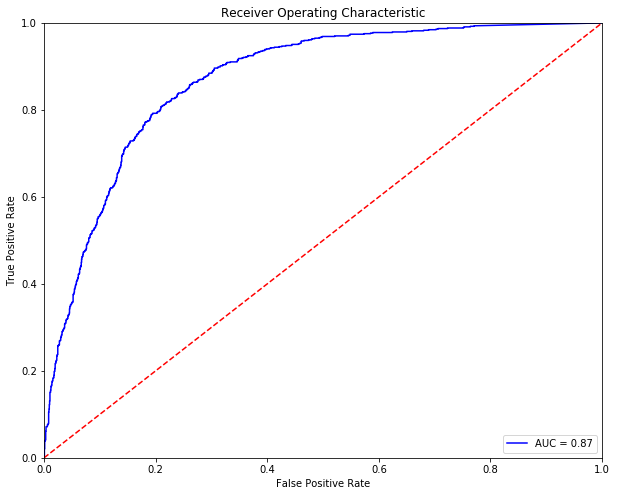

Optimal Threshold is 0.309981739228
Accuracy of Logistic Model on training data is: 0.796049979847


Predicted   0.0  1.0  __all__
Actual                       
0.0        1363  348     1711
1.0         158  612      770
__all__    1521  960     2481

In [128]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [129]:
table_70_70_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [130]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.3  False           True                0.5       100          ovr   

             6       7    8  
index  penalty  solver  tol  
0           l2     sag  0.1

Accuracy of the  Logistic  model for the training data is: 0.804111245466

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3585   493     4078
1           641  1070     1711
__all__    4226  1563     5789

Accuracy of the  Logistic  model for test data is: 0.800080612656

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1519  192     1711
1           304  466      770
__all__    1823  658     2481

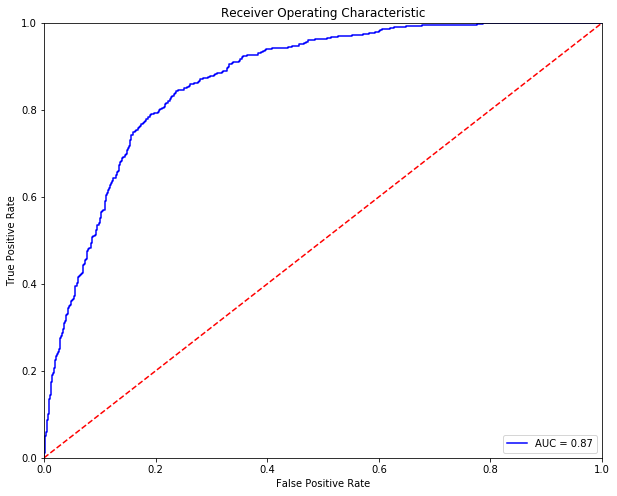

Optimal Threshold is 0.320835151966
Accuracy of Logistic Model on training data is: 0.795646916566


Predicted   0.0  1.0  __all__
Actual                       
0.0        1362  349     1711
1.0         158  612      770
__all__    1520  961     2481

In [131]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [132]:
table_70_70_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [133]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[10000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1         10000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.805665918121

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3376   702     4078
1           423  1288     1711
__all__    3799  1990     5789

Accuracy of the  Random Forest Trees  model for test data is: 0.81015719468

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1440  271     1711
1           200  570      770
__all__    1640  841     2481

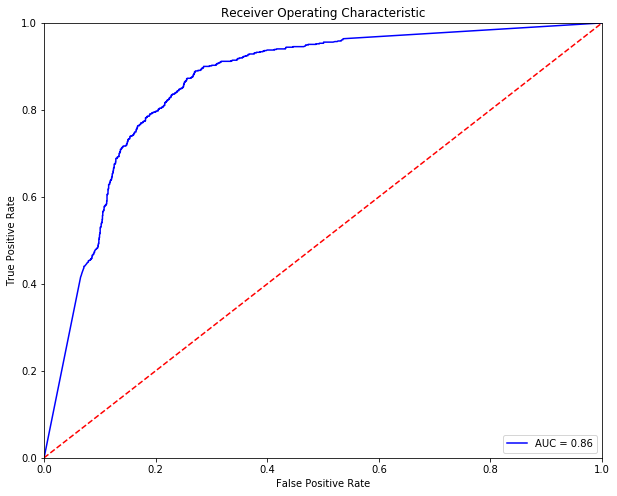

Optimal Threshold is 0.310408478215
Accuracy of Logistic Model on training data is: 0.796856106409


Predicted   0.0  1.0  __all__
Actual                       
0.0        1363  348     1711
1.0         156  614      770
__all__    1519  962     2481

In [134]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [135]:
table_70_70_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

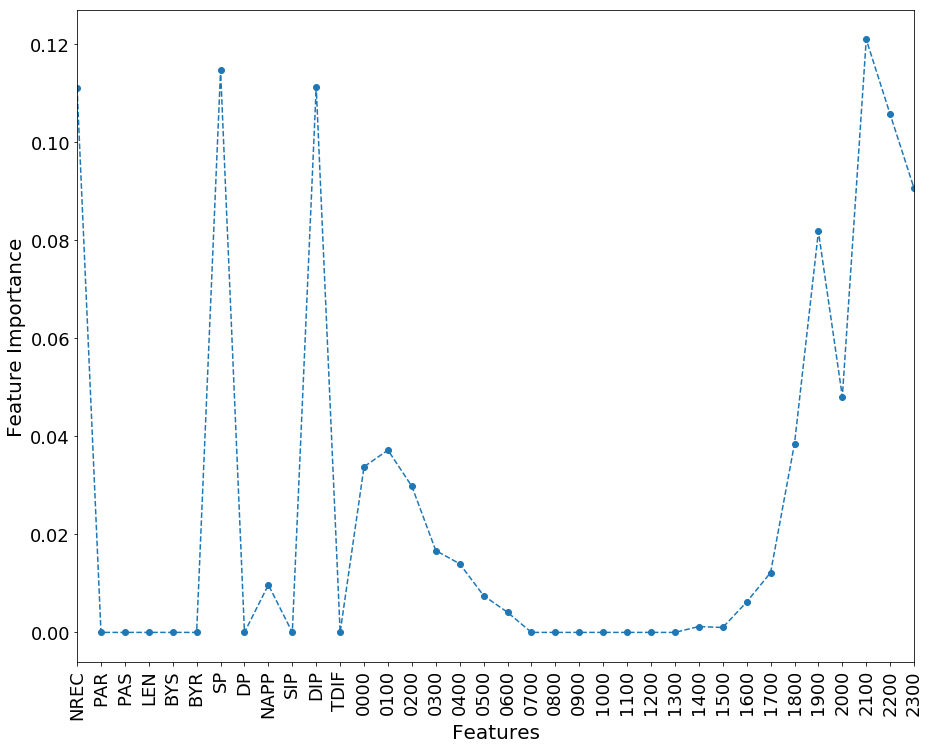

In [136]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [137]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME              1           400             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.808775263431

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3528   550     4078
1           557  1154     1711
__all__    4085  1704     5789

Accuracy of the  AdaBoostClassifier  model for test data is: 0.810963321241

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1488  223     1711
1           246  524      770
__all__    1734  747     2481

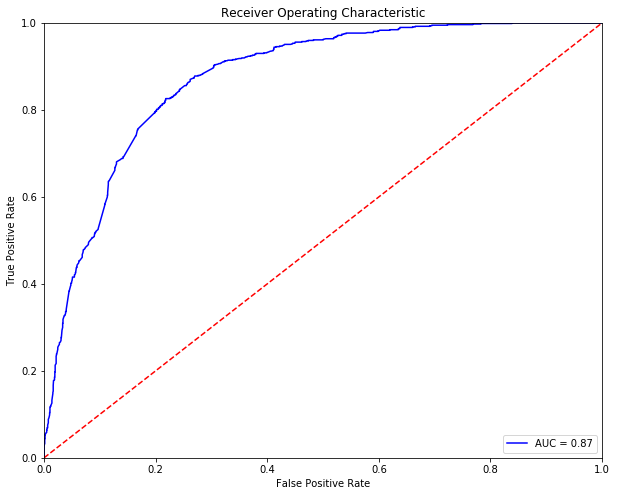

Optimal Threshold is 0.49612200695
Accuracy of Logistic Model on training data is: 0.798468359532


Predicted   0.0  1.0  __all__
Actual                       
0.0        1367  344     1711
1.0         156  614      770
__all__    1523  958     2481

In [138]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [139]:
table_70_70_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

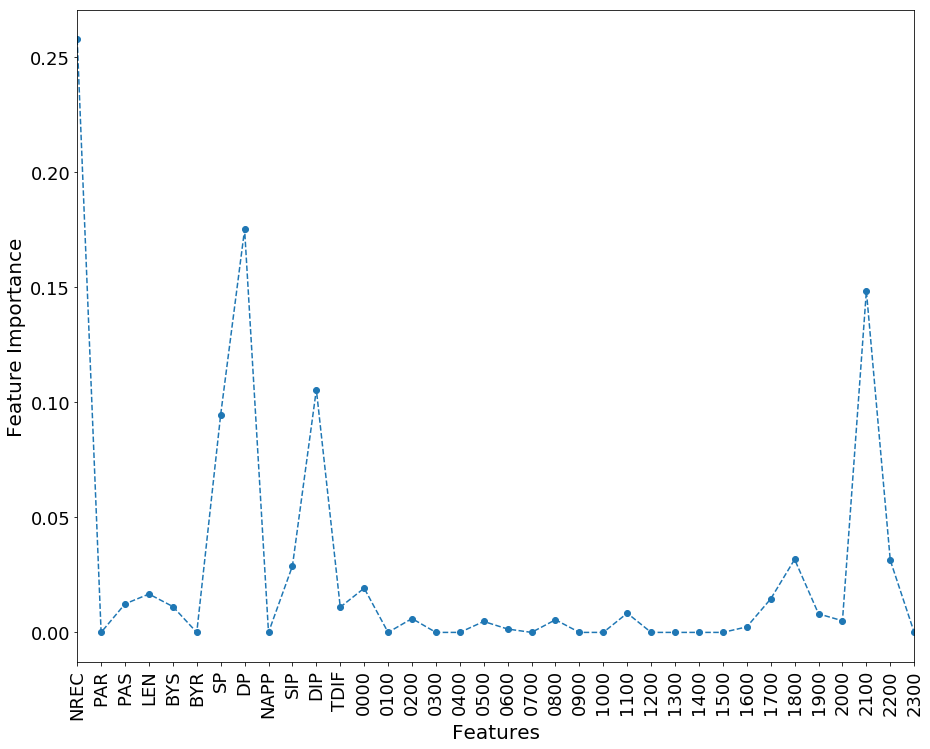

In [140]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [141]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse            0.1  exponential                20   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1            50             0        0.7

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.822767317326

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3545   533     4078
1           493  1218     1711
__all__    4038  1751     5789

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.815800080613

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1489  222     1711
1           235  535      770
__all__    1724  757     2481

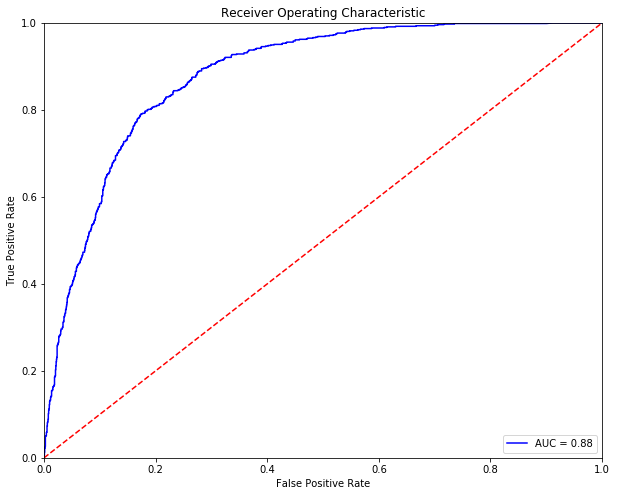

Optimal Threshold is 0.339776876504
Accuracy of Logistic Model on training data is: 0.805723498589


Predicted   0.0  1.0  __all__
Actual                       
0.0        1379  332     1711
1.0         150  620      770
__all__    1529  952     2481

In [142]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [143]:
table_70_70_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

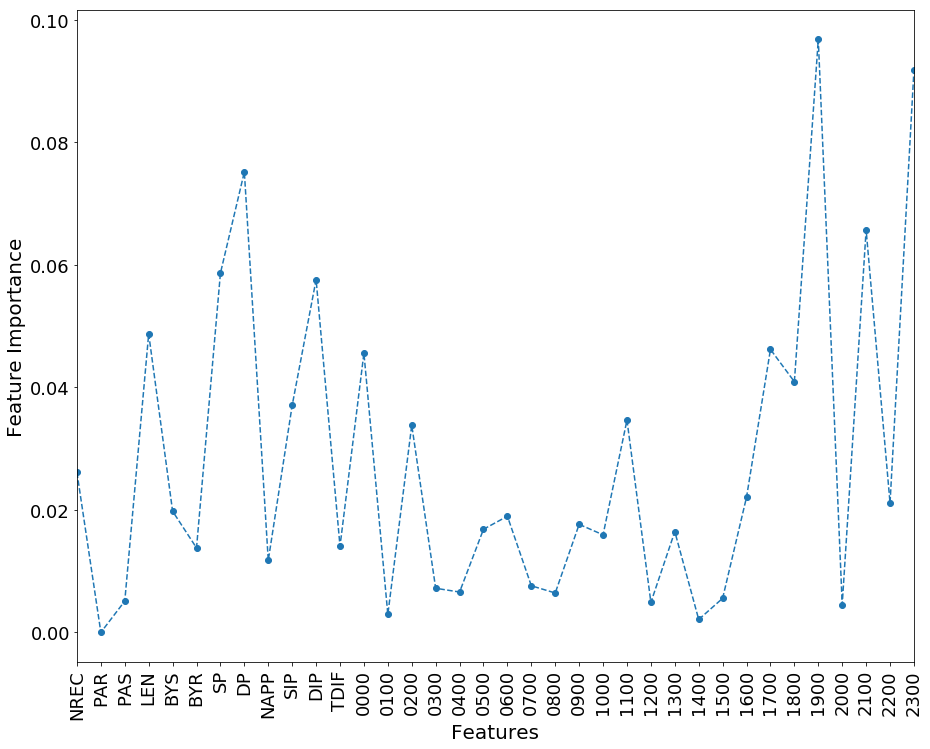

In [144]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [145]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0           gini         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     5                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.81015719468

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3519   559     4078
1           540  1171     1711
__all__    4059  1730     5789

Accuracy of the  Extra Decision Tree  model for test data is: 0.805320435308

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1487  224     1711
1           259  511      770
__all__    1746  735     2481

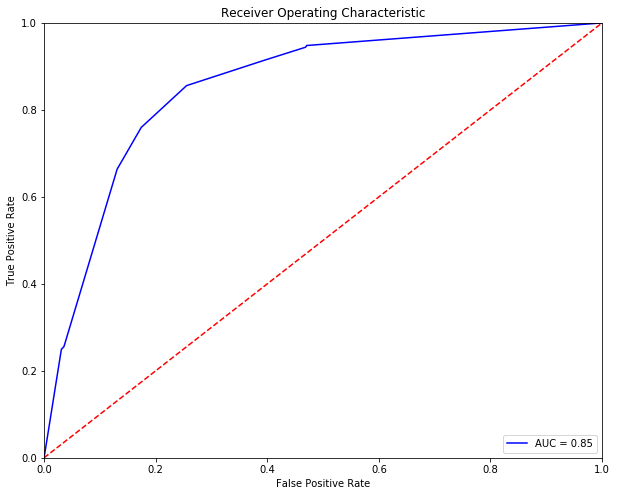

Optimal Threshold is 0.430199430199
Accuracy of Logistic Model on training data is: 0.805320435308


Predicted   0.0  1.0  __all__
Actual                       
0.0        1487  224     1711
1.0         259  511      770
__all__    1746  735     2481

In [146]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [147]:
table_70_70_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [148]:
%%capture
table_70_70_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

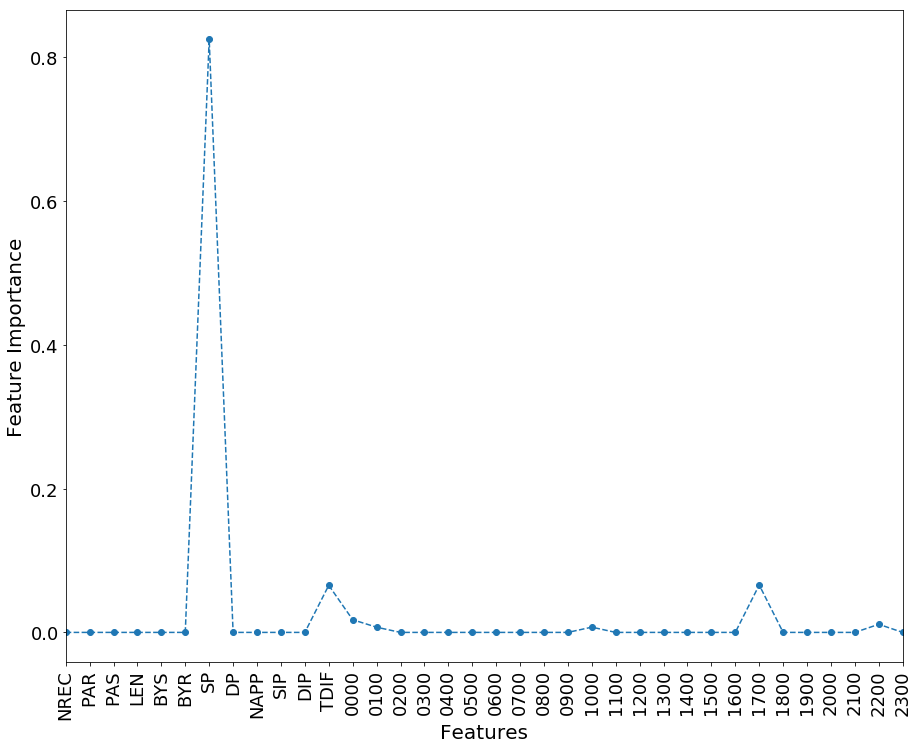

In [149]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [150]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.4          0.6          1000   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.991190188288

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4077     1     4078
1            50  1661     1711
__all__    4127  1662     5789

Accuracy of the  Bagging  model for test data is: 0.812172511084

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1487  224     1711
1           242  528      770
__all__    1729  752     2481

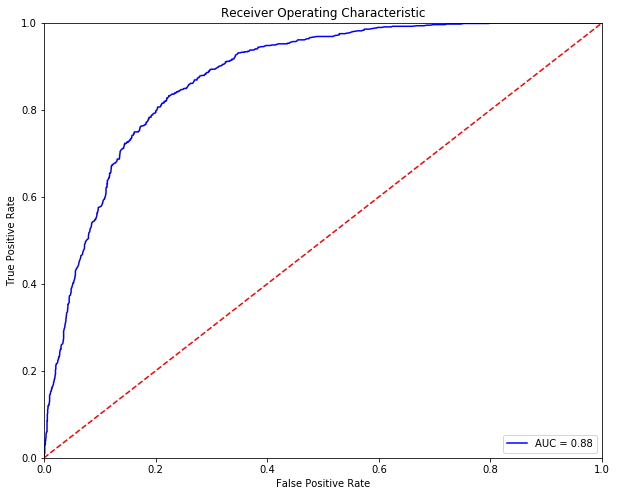

Optimal Threshold is 0.356
Accuracy of Logistic Model on training data is: 0.798871422813


Predicted   0.0  1.0  __all__
Actual                       
0.0        1368  343     1711
1.0         156  614      770
__all__    1524  957     2481

In [151]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [152]:
table_70_70_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [153]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.93418552427


Predicted     0     1  __all__
Actual                        
0          3990    88     4078
1           293  1418     1711
__all__    4283  1506     5789

The test accuracy is: 0.803708182185


Predicted     0    1  __all__
Actual                       
0          1501  210     1711
1           277  493      770
__all__    1778  703     2481

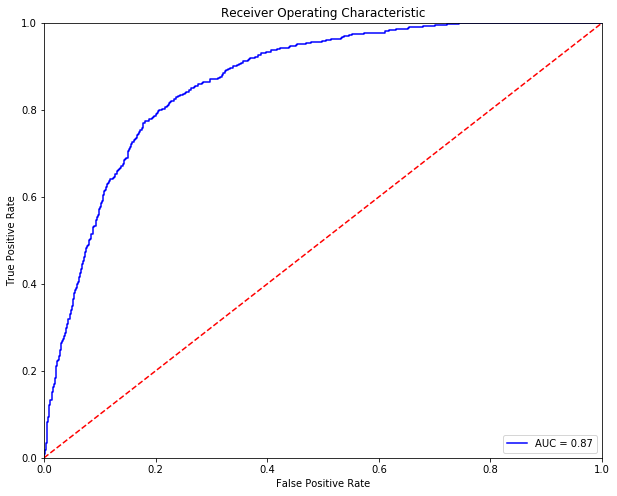

Optimal Threshold is 0.361538636439
Accuracy of Logistic Model on training data is: 0.795243853285


Predicted   0.0  1.0  __all__
Actual                       
0.0        1362  349     1711
1.0         159  611      770
__all__    1521  960     2481

In [154]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [155]:
table_70_70_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [156]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.932112627304


Predicted     0     1  __all__
Actual                        
0          3981    97     4078
1           296  1415     1711
__all__    4277  1512     5789

The accuracy of the model on test data is: 0.75856509472


Predicted     0    1  __all__
Actual                       
0          1486  225     1711
1           374  396      770
__all__    1860  621     2481

1408/2481 [================>.............] - ETA: 0s

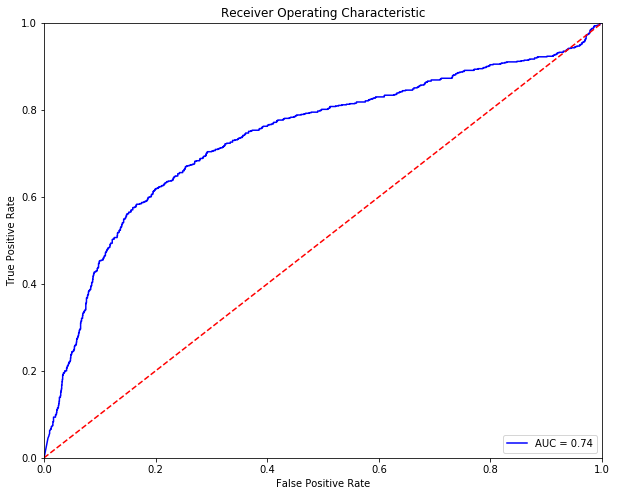

Optimal Threshold is 0.193232
Accuracy of Logistic Model on training data is: 0.705763804917


Predicted   0.0   1.0  __all__
Actual                        
0.0        1210   501     1711
1.0         229   541      770
__all__    1439  1042     2481

In [157]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [158]:
table_70_70_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [159]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.8min finished


The accuracy of the model on training data is: 0.822767317326


Predicted     0     1  __all__
Actual                        
0          3534   544     4078
1           482  1229     1711
__all__    4016  1773     5789

The accuracy of the model on test data is: 0.813784764208


Predicted     0    1  __all__
Actual                       
0          1488  223     1711
1           239  531      770
__all__    1727  754     2481

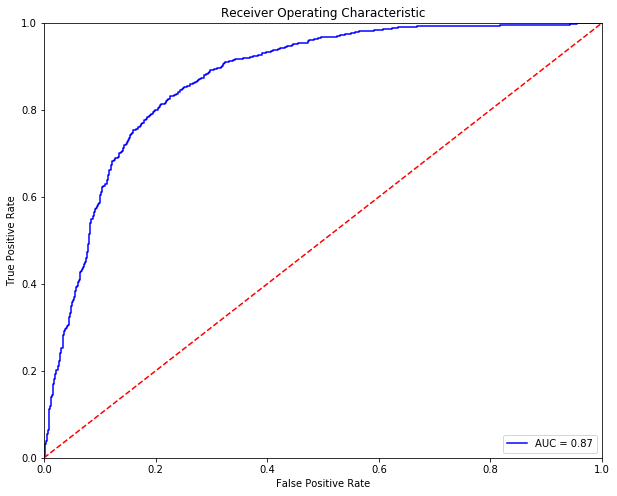

Optimal Threshold is 0.302954
Accuracy of Logistic Model on training data is: 0.800080612656


Predicted   0.0  1.0  __all__
Actual                       
0.0        1371  340     1711
1.0         156  614      770
__all__    1527  954     2481

In [160]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [161]:
table_70_70_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [162]:
table_70_70_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_70_70_test.set_index(['index'],drop=True,inplace=True)
table_70_70_train.set_index(['index'],drop=True,inplace=True)
table_70_70_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_70_train)

print("Comparision Table for Test Accuracies:")
display(table_70_70_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_70_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1711.0  4078.0    0.0    0.0  0.000000   
LogisticRegression          0.804111  1070.0  3585.0  493.0  641.0  0.120893   
RandomForestClassifier      0.805666  1288.0  3376.0  702.0  423.0  0.172143   
AdaBoostClassifier          0.808775  1154.0  3528.0  550.0  557.0  0.134870   
GradientBoostingClassifier  0.822767  1218.0  3545.0  533.0  493.0  0.130701   
ExtraTreeClassifier         0.810157  1171.0  3519.0  559.0  540.0  0.137077   
BaggingClassifier           0.991190  1661.0  4077.0    1.0   50.0  0.000245   
VotingClassifier            0.934186  1418.0  3990.0   88.0  293.0  0.021579   
Neural Network-1            0.932113  1415.0  3981.0   97.0  296.0  0.023786   
Neural-Network-2            0.822767  1229.0  3534.0  544.0  482.0  0.133399   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.374635  
RandomForestClassifier      0.247224  
AdaBoostClassifier          0.325541  
GradientBoostingClassifier  0.288136  
ExtraTreeClassifier         0.315605  
BaggingClassifier           0.029223  
VotingClassifier            0.171245  
Neural Network-1            0.172998  
Neural-Network-2            0.281707

Comparision Table for Test Accuracies:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.798065  489.0  1491.0  220.0  281.0  0.128580   
LogisticRegression          0.800081  466.0  1519.0  192.0  304.0  0.112215   
RandomForestClassifier      0.810157  570.0  1440.0  271.0  200.0  0.158387   
AdaBoostClassifier          0.810963  524.0  1488.0  223.0  246.0  0.130333   
GradientBoostingClassifier  0.815800  535.0  1489.0  222.0  235.0  0.129749   
ExtraTreeClassifier         0.805320  511.0  1487.0  224.0  259.0  0.130918   
BaggingClassifier           0.812173  528.0  1487.0  224.0  242.0  0.130918   
VotingClassifier            0.803708  493.0  1501.0  210.0  277.0  0.122735   
Neural Network-1            0.758565  396.0  1486.0  225.0  374.0  0.131502   
Neural-Network-2            0.813785  531.0  1488.0  223.0  239.0  0.130333   

                                 FNR  
index                                 
KNeighborsClassifier        0.364935  
LogisticRegression          0.394805  
RandomForestClassifier      0.259740  
AdaBoostClassifier          0.319481  
GradientBoostingClassifier  0.305195  
ExtraTreeClassifier         0.336364  
BaggingClassifier           0.314286  
VotingClassifier            0.359740  
Neural Network-1            0.485714  
Neural-Network-2            0.310390

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.796050  612.0  1363.0  348.0  158.0  0.203390   
LogisticRegression          0.795647  612.0  1362.0  349.0  158.0  0.203974   
RandomForestClassifier      0.796856  614.0  1363.0  348.0  156.0  0.203390   
AdaBoostClassifier          0.798468  614.0  1367.0  344.0  156.0  0.201052   
GradientBoostingClassifier  0.805723  620.0  1379.0  332.0  150.0  0.194039   
ExtraTreeClassifier         0.805320  511.0  1487.0  224.0  259.0  0.130918   
BaggingClassifier           0.798871  614.0  1368.0  343.0  156.0  0.200468   
VotingClassifier            0.795244  611.0  1362.0  349.0  159.0  0.203974   
Neural Network-1            0.705764  541.0  1210.0  501.0  229.0  0.292811   
Neural-Network-2            0.800081  614.0  1371.0  340.0  156.0  0.198714   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.205195   0.309982  0.869327  
LogisticRegression          0.205195   0.320835  0.870470  
RandomForestClassifier      0.202597   0.310408  0.862398  
AdaBoostClassifier          0.202597   0.496122  0.873630  
GradientBoostingClassifier  0.194805   0.339777  0.880315  
ExtraTreeClassifier         0.336364   0.430199  0.854724  
BaggingClassifier           0.202597   0.356000  0.876970  
VotingClassifier            0.206494   0.361539  0.867260  
Neural Network-1            0.297403   0.193232  0.737406  
Neural-Network-2            0.202597   0.302954  0.871936

#### Random State 10

In [163]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_10.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  3030  230.950495   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...   599  158.008347   

                                                          PAS        LEN  \
Source_User                                                                
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  80.524092  84.155116   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  57.856427  82.028381   

                                                            BYS  \
Source_User                                                       
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  9686.861716   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  6161.512521   

                                                              BYR      SP  \
Source_User                                                                 
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  287727.528383  2741.0   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  198461.532554   587.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  11.0    40   63  820   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  12.0    30   70  210   

                                                            TDIF  0000  0100  \
Source_User                                                                    
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   2395.224422   195   256   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  12098.198664     0     3   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   110    55    63    53   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     3     2     4     2   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...    56    31    79    81   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     0    34    70    92   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...    39    75    98    81   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...   117    30    10    14   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   159   264   181   142   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     7     5    25    37   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   177   135   120   184   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...    61    27    27    25   

                                                    2200  2300  
Source_User                                                     
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   240   156  
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     1     3

In [164]:
### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

1 -> Infected
0 -> Uninfected


Source_User
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3449af4e82e30f9f87    0
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce851fca5724939971862    1
06fe39332e5261ed8a5f1bb9d62559deb0de1620963ebbded14eecf78b8a0a20    0
5455eddbb8ee814c41a27e8676a6cc34faa6fc295c6e92588fc75dbe7f61369b    0
47a99c45d555e42658dbf94be7417ec6c327ecfc05ed5c57eaac1de3bd43bb86    1
60ff3ff13bb2e6a16dc866bc314964cc6d60b1e9891d805e7d9e99b1864ae896    1
a4244338cc086f69de152063f5b11482be2d007a5da089331dc2fe778e459e26    1
70de2ff22d8dd1433aa38947470f94f455bcbdabb1789e81332ba5c390408acc    1
6c49763f6a507ebf7aff12e40a61cfe3624fca5d5ac9dc1b86ac38c68ca4b1ba    0
ab60d8ea5924263ddfde9661ee4a4081f95679c77492da4479cd0350f56c7de3    0
Name: Target, dtype: int64

In [165]:
### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.3)

The train/test split ratio is 70:30


In [166]:
## Table to store training and test measures
table_70_70_10_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_10_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_10_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [167]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0      ball_tree          5  chebyshev           30  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4059     0     4059
1             0  1730     1730
__all__    4059  1730     5789

Accuracy of the  KNN  model for test data is: 0.795646916566

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1470  260     1730
1           247  504      751
__all__    1717  764     2481

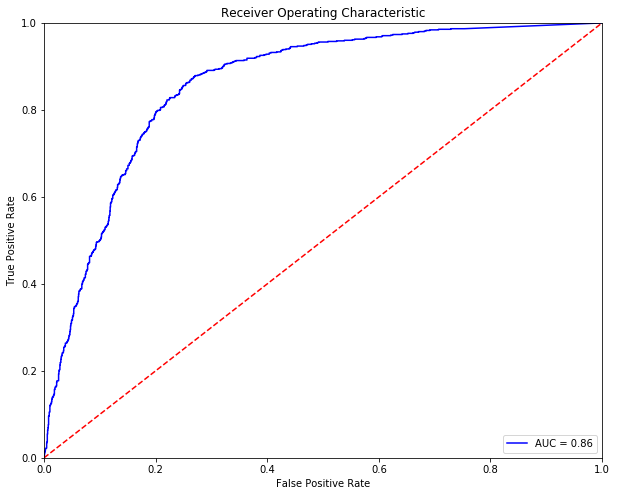

Optimal Threshold is 0.392734625212
Accuracy of Logistic Model on training data is: 0.79725916969


Predicted   0.0  1.0  __all__
Actual                       
0.0        1380  350     1730
1.0         153  598      751
__all__    1533  948     2481

In [168]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [169]:
table_70_70_10_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_10_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [170]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.7  False          False                0.5        50  multinomial   

             6          7      8  
index  penalty     solver    tol  
0           l2  newton-cg  1e-05

Accuracy of the  Logistic  model for the training data is: 0.796510623596

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3361   698     4059
1           480  1250     1730
__all__    3841  1948     5789

Accuracy of the  Logistic  model for test data is: 0.80612656187

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1433  297     1730
1           184  567      751
__all__    1617  864     2481

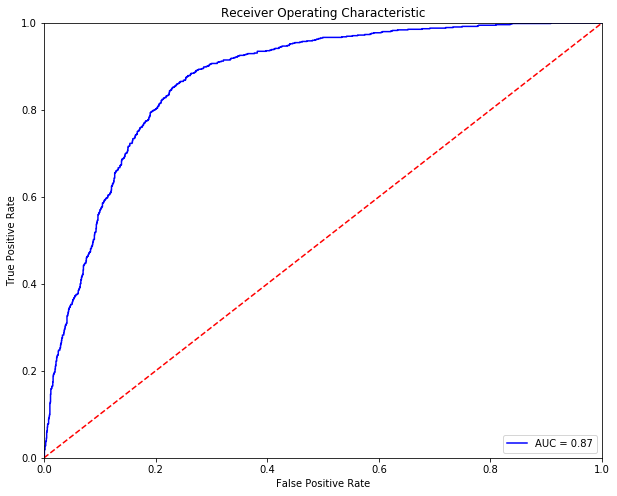

Optimal Threshold is 0.467420972221
Accuracy of Logistic Model on training data is: 0.800886739218


Predicted   0.0  1.0  __all__
Actual                       
0.0        1386  344     1730
1.0         150  601      751
__all__    1536  945     2481

In [171]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [172]:
table_70_70_10_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_10_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [173]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[10000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1         10000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.796856106409

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3328   731     4059
1           445  1285     1730
__all__    3773  2016     5789

Accuracy of the  Random Forest Trees  model for test data is: 0.811366384522

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1427  303     1730
1           165  586      751
__all__    1592  889     2481

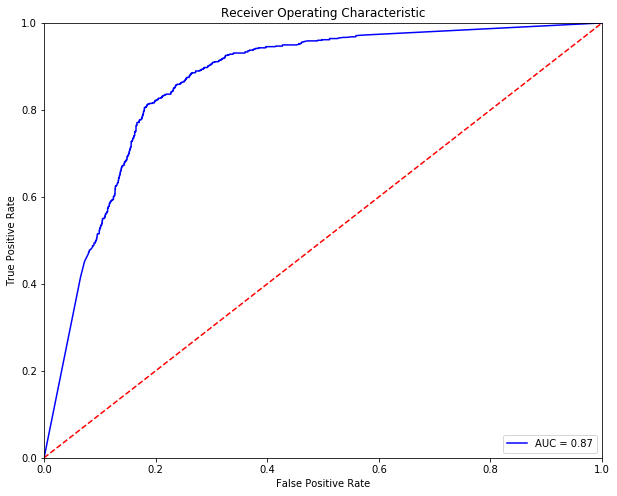

Optimal Threshold is 0.432067158644
Accuracy of Logistic Model on training data is: 0.813381700927


Predicted   0.0  1.0  __all__
Actual                       
0.0        1408  322     1730
1.0         141  610      751
__all__    1549  932     2481

In [174]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [175]:
table_70_70_10_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_10_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

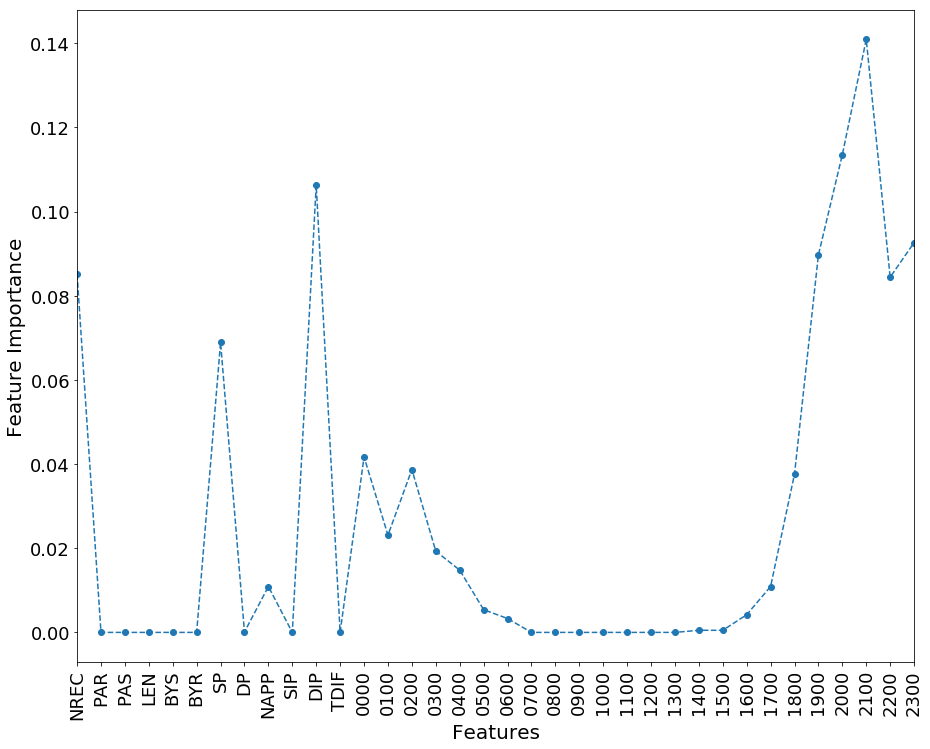

In [176]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [177]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0        SAMME.R            0.5            50             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.800138193125

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3419   640     4059
1           517  1213     1730
__all__    3936  1853     5789

Accuracy of the  AdaBoostClassifier  model for test data is: 0.806529625151

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1445  285     1730
1           195  556      751
__all__    1640  841     2481

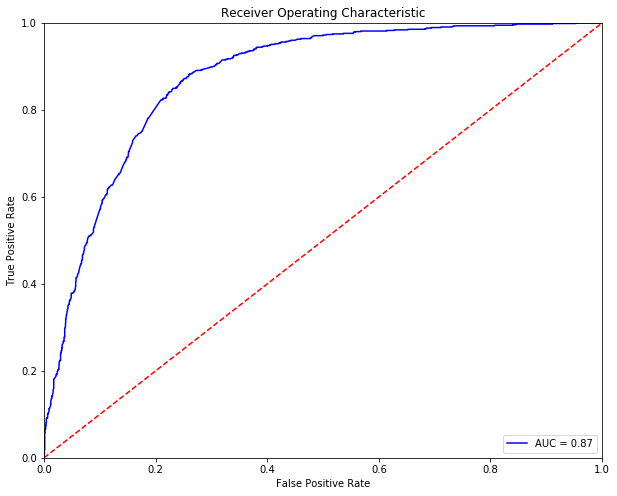

Optimal Threshold is 0.498353378469
Accuracy of Logistic Model on training data is: 0.803305118904


Predicted   0.0  1.0  __all__
Actual                       
0.0        1407  323     1730
1.0         165  586      751
__all__    1572  909     2481

In [178]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [179]:
table_70_70_10_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_10_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

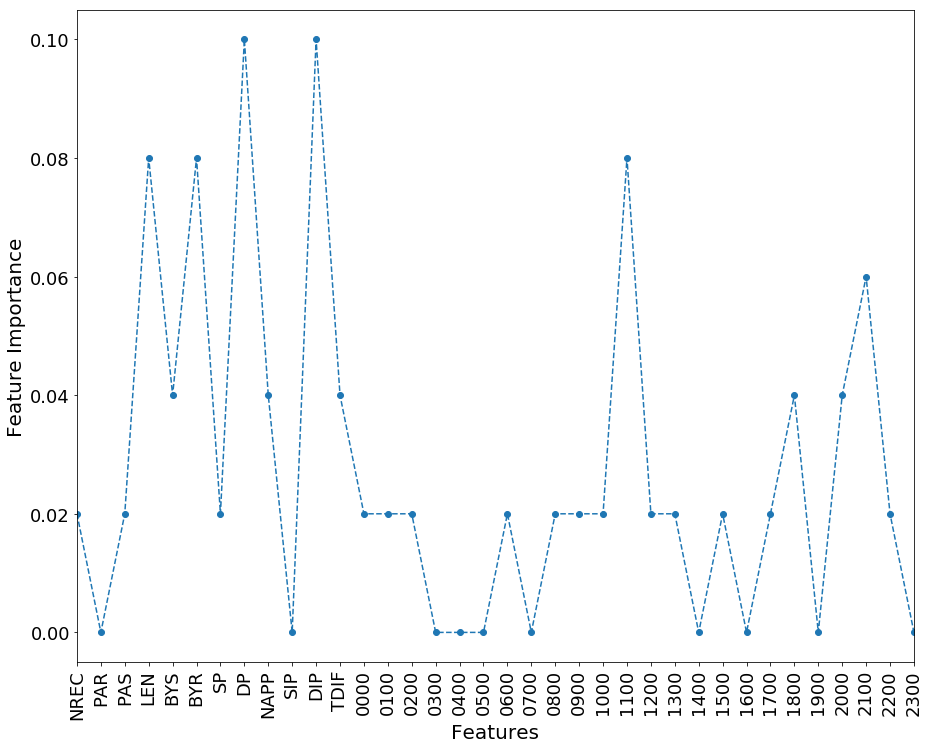

In [180]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [181]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse           0.03  exponential                 5   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1           100             0        0.5

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.808429780618

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3486   573     4059
1           536  1194     1730
__all__    4022  1767     5789

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.808544941556

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1465  265     1730
1           210  541      751
__all__    1675  806     2481

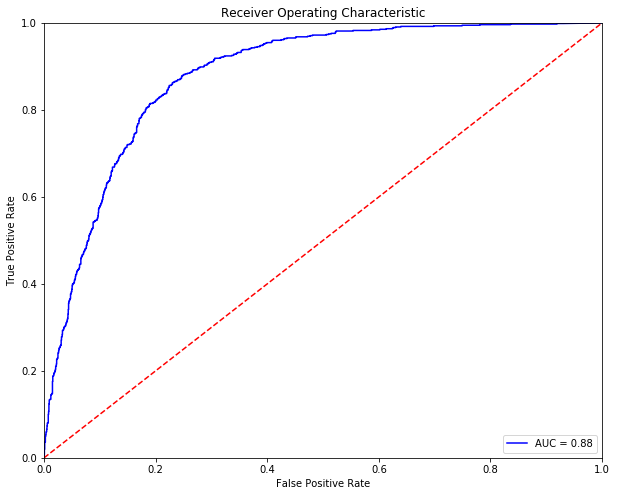

Optimal Threshold is 0.41157711123
Accuracy of Logistic Model on training data is: 0.811366384522


Predicted   0.0  1.0  __all__
Actual                       
0.0        1404  326     1730
1.0         142  609      751
__all__    1546  935     2481

In [182]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [183]:
table_70_70_10_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_10_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

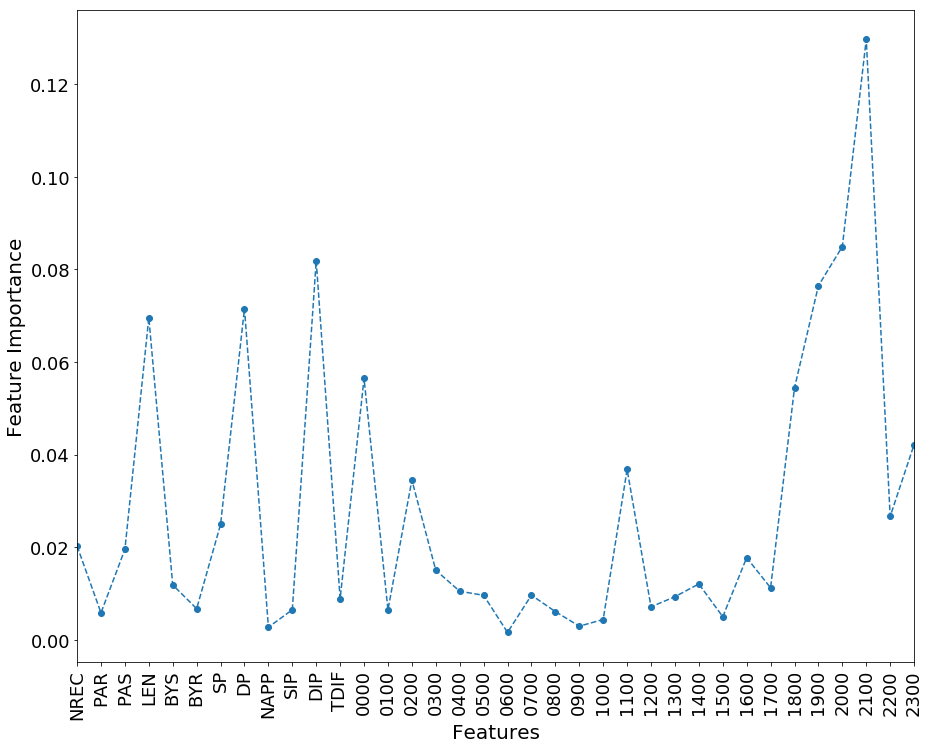

In [184]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [185]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0           gini         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.7994472275

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3446   613     4059
1           548  1182     1730
__all__    3994  1795     5789

Accuracy of the  Extra Decision Tree  model for test data is: 0.808141878275

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1457  273     1730
1           203  548      751
__all__    1660  821     2481

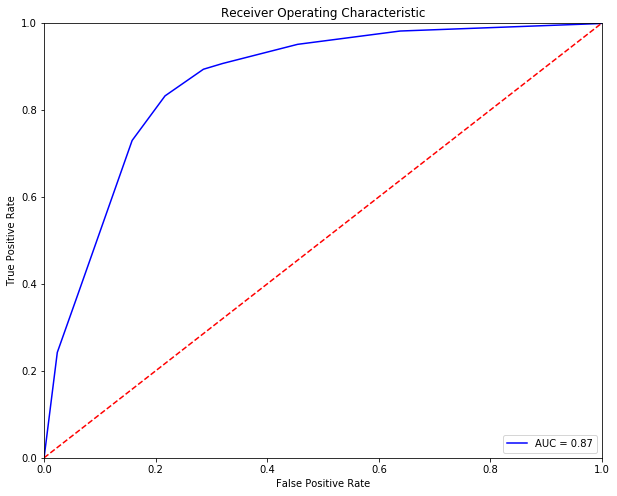

Optimal Threshold is 0.399193548387
Accuracy of Logistic Model on training data is: 0.808141878275


Predicted   0.0  1.0  __all__
Actual                       
0.0        1457  273     1730
1.0         203  548      751
__all__    1660  821     2481

In [186]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [187]:
table_70_70_10_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [188]:
%%capture
table_70_70_10_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

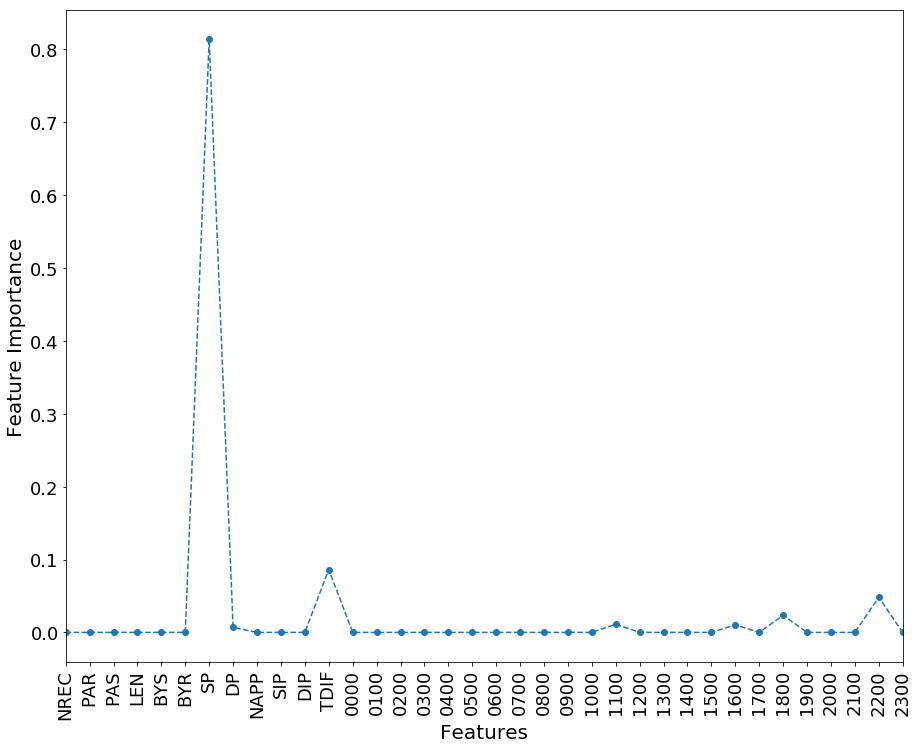

In [189]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [190]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.3          0.3           500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.924684746934

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3925   134     4059
1           302  1428     1730
__all__    4227  1562     5789

Accuracy of the  Bagging  model for test data is: 0.81056025796

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1461  269     1730
1           201  550      751
__all__    1662  819     2481

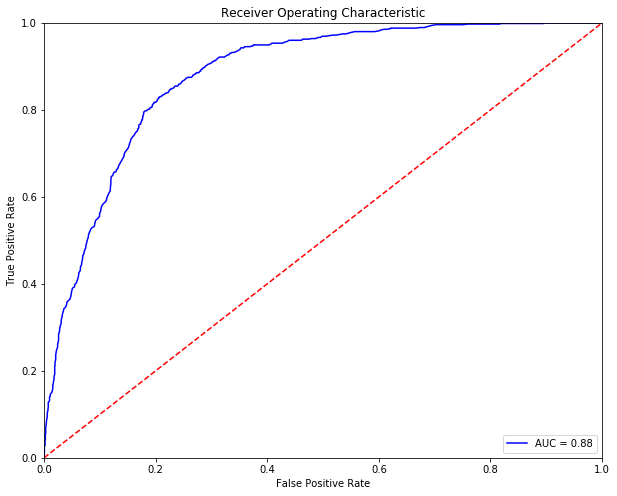

Optimal Threshold is 0.416
Accuracy of Logistic Model on training data is: 0.806932688432


Predicted   0.0  1.0  __all__
Actual                       
0.0        1397  333     1730
1.0         146  605      751
__all__    1543  938     2481

In [191]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [192]:
table_70_70_10_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_10_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [193]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.934358265676


Predicted     0     1  __all__
Actual                        
0          3975    84     4059
1           296  1434     1730
__all__    4271  1518     5789

The test accuracy is: 0.804111245466


Predicted     0    1  __all__
Actual                       
0          1495  235     1730
1           251  500      751
__all__    1746  735     2481

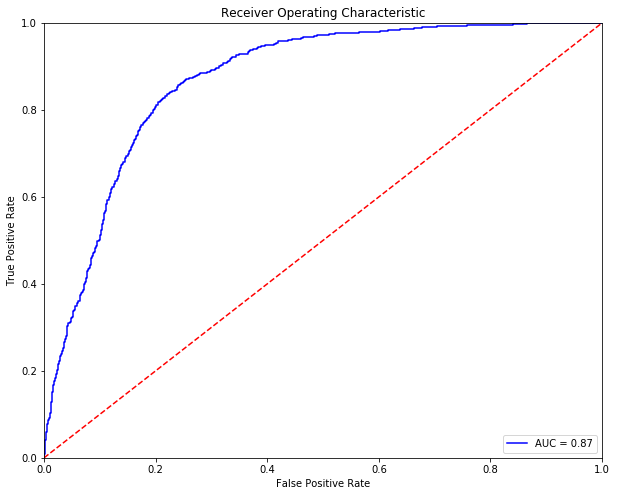

Optimal Threshold is 0.411307492915
Accuracy of Logistic Model on training data is: 0.802095929061


Predicted   0.0  1.0  __all__
Actual                       
0.0        1388  342     1730
1.0         149  602      751
__all__    1537  944     2481

In [194]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [195]:
table_70_70_10_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_10_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [196]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.933494558553


Predicted     0     1  __all__
Actual                        
0          3971    88     4059
1           297  1433     1730
__all__    4268  1521     5789

The accuracy of the model on test data is: 0.776299879081


Predicted     0    1  __all__
Actual                       
0          1491  239     1730
1           316  435      751
__all__    1807  674     2481

2368/2481 [===========================>..] - ETA: 0s

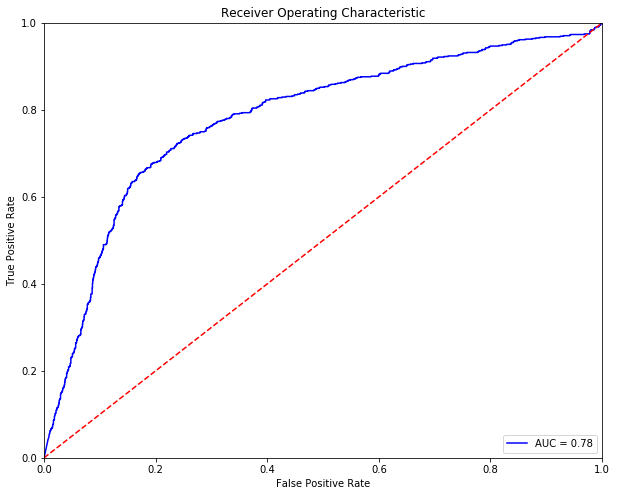

Optimal Threshold is 0.163622
Accuracy of Logistic Model on training data is: 0.740024183797


Predicted   0.0   1.0  __all__
Actual                        
0.0        1281   449     1730
1.0         196   555      751
__all__    1477  1004     2481

In [197]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [198]:
table_70_70_10_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_10_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [199]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  5.3min finished


The accuracy of the model on training data is: 0.809293487649


Predicted     0     1  __all__
Actual                        
0          3359   700     4059
1           404  1326     1730
__all__    3763  2026     5789

The accuracy of the model on test data is: 0.807738814994


Predicted     0    1  __all__
Actual                       
0          1415  315     1730
1           162  589      751
__all__    1577  904     2481

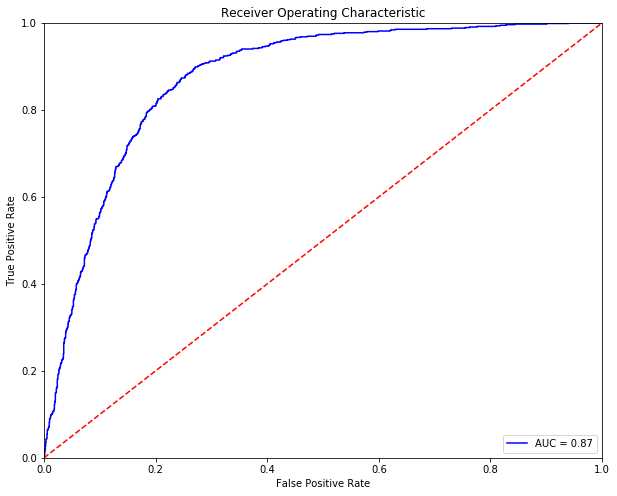

Optimal Threshold is 0.425056
Accuracy of Logistic Model on training data is: 0.80612656187


Predicted   0.0  1.0  __all__
Actual                       
0.0        1395  335     1730
1.0         146  605      751
__all__    1541  940     2481

In [200]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [201]:
table_70_70_10_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_10_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [202]:
table_70_70_10_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_10_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_10_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_70_70_10_test.set_index(['index'],drop=True,inplace=True)
table_70_70_10_train.set_index(['index'],drop=True,inplace=True)
table_70_70_10_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_70_10_train)

print("Comparision Table for Test Accuracies:")
display(table_70_70_10_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_70_10_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1730.0  4059.0    0.0    0.0  0.000000   
LogisticRegression          0.796511  1250.0  3361.0  698.0  480.0  0.171964   
RandomForestClassifier      0.796856  1285.0  3328.0  731.0  445.0  0.180094   
AdaBoostClassifier          0.800138  1213.0  3419.0  640.0  517.0  0.157674   
GradientBoostingClassifier  0.808430  1194.0  3486.0  573.0  536.0  0.141168   
ExtraTreeClassifier         0.799447  1182.0  3446.0  613.0  548.0  0.151022   
BaggingClassifier           0.924685  1428.0  3925.0  134.0  302.0  0.033013   
VotingClassifier            0.934358  1434.0  3975.0   84.0  296.0  0.020695   
Neural Network-1            0.933495  1433.0  3971.0   88.0  297.0  0.021680   
Neural-Network-2            0.809293  1326.0  3359.0  700.0  404.0  0.172456   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.277457  
RandomForestClassifier      0.257225  
AdaBoostClassifier          0.298844  
GradientBoostingClassifier  0.309827  
ExtraTreeClassifier         0.316763  
BaggingClassifier           0.174566  
VotingClassifier            0.171098  
Neural Network-1            0.171676  
Neural-Network-2            0.233526

Comparision Table for Test Accuracies:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.795647  504.0  1470.0  260.0  247.0  0.150289   
LogisticRegression          0.806127  567.0  1433.0  297.0  184.0  0.171676   
RandomForestClassifier      0.811366  586.0  1427.0  303.0  165.0  0.175145   
AdaBoostClassifier          0.806530  556.0  1445.0  285.0  195.0  0.164740   
GradientBoostingClassifier  0.808545  541.0  1465.0  265.0  210.0  0.153179   
ExtraTreeClassifier         0.808142  548.0  1457.0  273.0  203.0  0.157803   
BaggingClassifier           0.810560  550.0  1461.0  269.0  201.0  0.155491   
VotingClassifier            0.804111  500.0  1495.0  235.0  251.0  0.135838   
Neural Network-1            0.776300  435.0  1491.0  239.0  316.0  0.138150   
Neural-Network-2            0.807739  589.0  1415.0  315.0  162.0  0.182081   

                                 FNR  
index                                 
KNeighborsClassifier        0.328895  
LogisticRegression          0.245007  
RandomForestClassifier      0.219707  
AdaBoostClassifier          0.259654  
GradientBoostingClassifier  0.279627  
ExtraTreeClassifier         0.270306  
BaggingClassifier           0.267643  
VotingClassifier            0.334221  
Neural Network-1            0.420772  
Neural-Network-2            0.215712

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.797259  598.0  1380.0  350.0  153.0  0.202312   
LogisticRegression          0.800887  601.0  1386.0  344.0  150.0  0.198844   
RandomForestClassifier      0.813382  610.0  1408.0  322.0  141.0  0.186127   
AdaBoostClassifier          0.803305  586.0  1407.0  323.0  165.0  0.186705   
GradientBoostingClassifier  0.811366  609.0  1404.0  326.0  142.0  0.188439   
ExtraTreeClassifier         0.808142  548.0  1457.0  273.0  203.0  0.157803   
BaggingClassifier           0.806933  605.0  1397.0  333.0  146.0  0.192486   
VotingClassifier            0.802096  602.0  1388.0  342.0  149.0  0.197688   
Neural Network-1            0.740024  555.0  1281.0  449.0  196.0  0.259538   
Neural-Network-2            0.806127  605.0  1395.0  335.0  146.0  0.193642   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.203728   0.392735  0.858114  
LogisticRegression          0.199734   0.467421  0.871331  
RandomForestClassifier      0.187750   0.432067  0.865630  
AdaBoostClassifier          0.219707   0.498353  0.874129  
GradientBoostingClassifier  0.189081   0.411577  0.880396  
ExtraTreeClassifier         0.270306   0.399194  0.865006  
BaggingClassifier           0.194407   0.416000  0.878988  
VotingClassifier            0.198402   0.411307  0.869107  
Neural Network-1            0.260985   0.163622  0.780917  
Neural-Network-2            0.194407   0.425056  0.873846

#### Random State 20

In [203]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_20.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   651   35.807988   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  4059  321.478197   

                                                           PAS         LEN  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   35.328725  108.442396   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  131.395910   73.695245   

                                                             BYS  \
Source_User                                                        
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   3976.233487   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  31586.025868   

                                                              BYR      SP  \
Source_User                                                                 
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   37072.858679   639.0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  413326.700419  3627.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   8.0    21   23  158   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  18.0    40   31  974   

                                                            TDIF  0000  0100  \
Source_User                                                                    
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...  11131.820276     6     0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   1803.300813   196   310   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     2     0     0     0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   532   308   202   101   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     0    13     8    34   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...    45   281    95    38   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    95    39    76    71   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...    93    95   206   102   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    74    66   114    27   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   104    84   194   144   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    14     0     0     7   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   116   161   158   138   

                                                    2200  2300  
Source_User                                                     
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     3     2  
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   159   197

In [204]:
### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

1 -> Infected
0 -> Uninfected


Source_User
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d641329bc603046dfcc4    0
307c636564c5ec9897e5062605e2982daf781f0f82b0234f2cbc55919f8d04e2    0
11e8b7b973c885d9d2560baeec4673bc6b13aab08d9e49bc9c519727595e4d3e    1
41851f48304067368da8f12794e2f539330cc7ef6732c1440ed4c5eb06b9cc5d    0
08402d90e55ea64677880c21fc3850422ad2e08f730282d271027f0fea60b4b6    1
952aed50327c6ac4e19a033bb585959b33ea2ca897f985dc33a1bb6a1f3d7cc7    0
6b42f8e7f92d2fccc0fae12167ef5e929f394e87e9c70bb36ac160bf6d6cb0f4    0
c9140a85217daf0d18148d489fa6d3293cbe499584b12e28be0e381a20eeb737    1
647e8a6690cd21f7bae287782ec6a621cae3a5ba6f37b779d99f28a7851b1bfc    0
42d06643547a80b9343fa1a09ca32b0c3bb84caa31bfb45c629b6835072e364b    0
Name: Target, dtype: int64

In [205]:
### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.3)

The train/test split ratio is 70:30


In [206]:
## Table to store training and test measures
table_70_70_20_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_20_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_20_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [207]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3        4
index  algorithm  leaf_size     metric  n_neighbors  weights
0           auto          2  manhattan           50  uniform

Accuracy of the  KNN  model for the training data is: 0.803765762653

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3568   471     4039
1           665  1085     1750
__all__    4233  1556     5789

Accuracy of the  KNN  model for test data is: 0.810963321241

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1566  184     1750
1           285  446      731
__all__    1851  630     2481

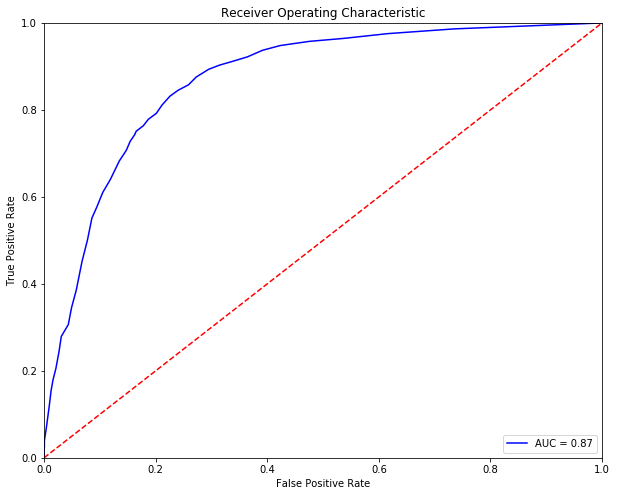

Optimal Threshold is 0.32
Accuracy of Logistic Model on training data is: 0.802902055623


Predicted   0.0  1.0  __all__
Actual                       
0.0        1423  327     1750
1.0         162  569      731
__all__    1585  896     2481

In [208]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [209]:
table_70_70_20_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_20_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [210]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.3  False           True                0.7        50          ovr   

             6       7    8  
index  penalty  solver  tol  
0           l2     sag  0.1

Accuracy of the  Logistic  model for the training data is: 0.798238037658

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3360   679     4039
1           489  1261     1750
__all__    3849  1940     5789

Accuracy of the  Logistic  model for test data is: 0.805320435308

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1482  268     1750
1           215  516      731
__all__    1697  784     2481

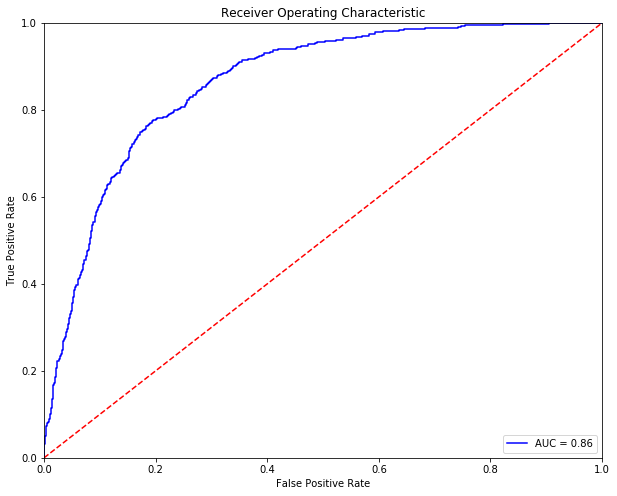

Optimal Threshold is 0.380973447841
Accuracy of Logistic Model on training data is: 0.785973397823


Predicted   0.0  1.0  __all__
Actual                       
0.0        1378  372     1750
1.0         159  572      731
__all__    1537  944     2481

In [211]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [212]:
table_70_70_20_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_20_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [213]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[10000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1         10000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.799274486094

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3303   736     4039
1           426  1324     1750
__all__    3729  2060     5789

Accuracy of the  Random Forest Trees  model for test data is: 0.808544941556

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1464  286     1750
1           189  542      731
__all__    1653  828     2481

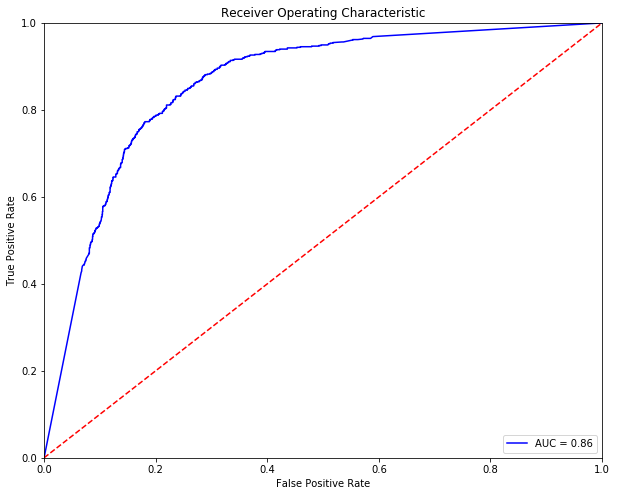

Optimal Threshold is 0.31643973588
Accuracy of Logistic Model on training data is: 0.792422410318


Predicted   0.0  1.0  __all__
Actual                       
0.0        1388  362     1750
1.0         153  578      731
__all__    1541  940     2481

In [214]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [215]:
table_70_70_20_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_20_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

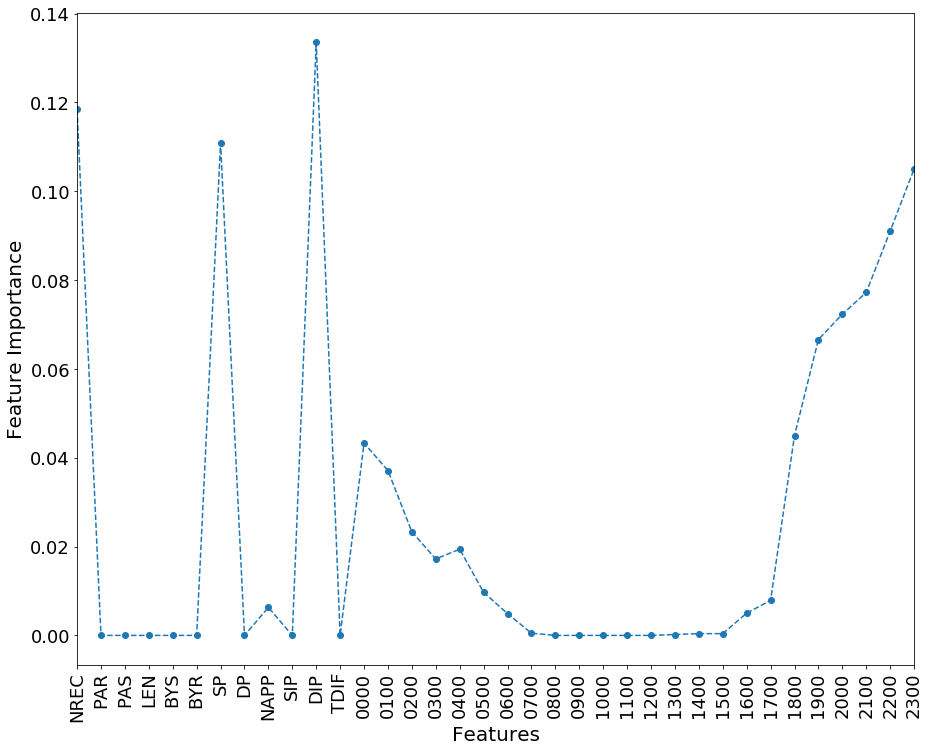

In [216]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [217]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME              1           400             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.808775263431

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3416   623     4039
1           484  1266     1750
__all__    3900  1889     5789

Accuracy of the  AdaBoostClassifier  model for test data is: 0.80612656187

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1477  273     1750
1           208  523      731
__all__    1685  796     2481

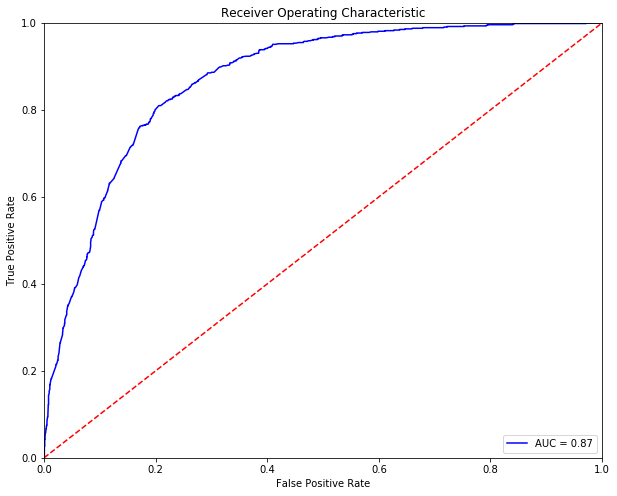

Optimal Threshold is 0.480411840654
Accuracy of Logistic Model on training data is: 0.800080612656


Predicted   0.0  1.0  __all__
Actual                       
0.0        1402  348     1750
1.0         148  583      731
__all__    1550  931     2481

In [218]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [219]:
table_70_70_20_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_20_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

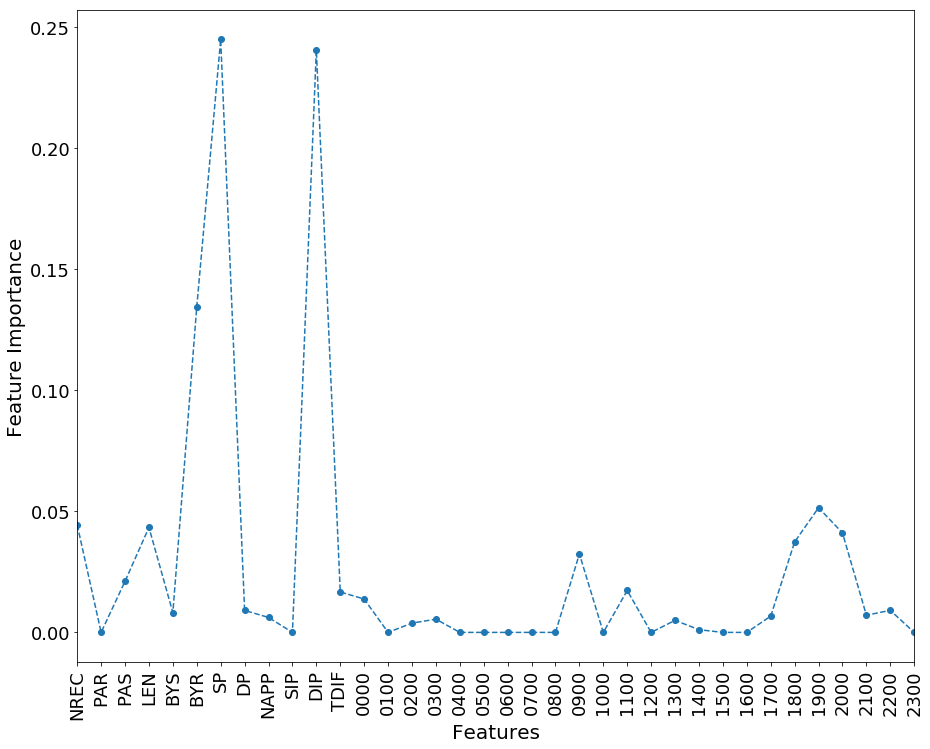

In [220]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [221]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse           0.05  exponential                 5   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1           150             0          1

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.821039903265

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3497   542     4039
1           494  1256     1750
__all__    3991  1798     5789

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.811366384522

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1522  228     1750
1           240  491      731
__all__    1762  719     2481

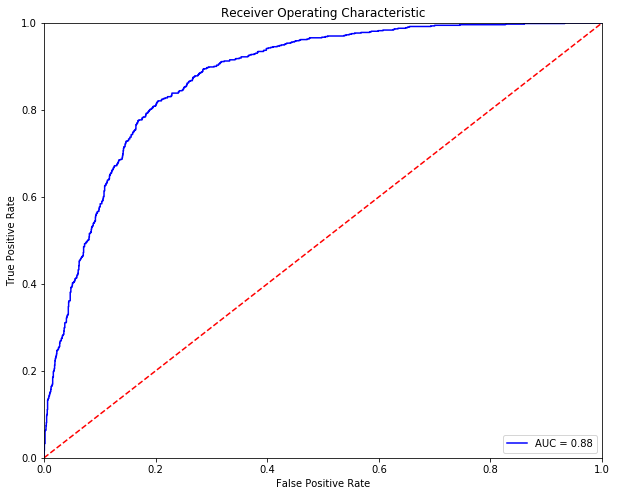

Optimal Threshold is 0.352002530689
Accuracy of Logistic Model on training data is: 0.805320435308


Predicted   0.0  1.0  __all__
Actual                       
0.0        1410  340     1750
1.0         143  588      731
__all__    1553  928     2481

In [222]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [223]:
table_70_70_20_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_20_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

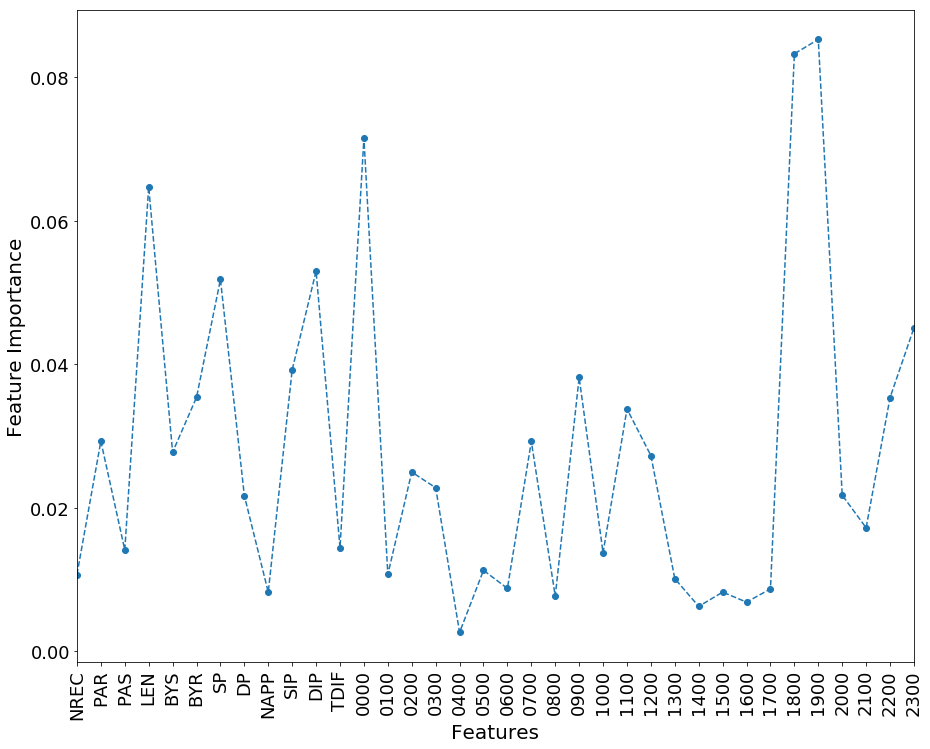

In [224]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [225]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0        entropy         20          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  5             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.81948523061

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3610   429     4039
1           616  1134     1750
__all__    4226  1563     5789

Accuracy of the  Extra Decision Tree  model for test data is: 0.798468359532

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1540  210     1750
1           290  441      731
__all__    1830  651     2481

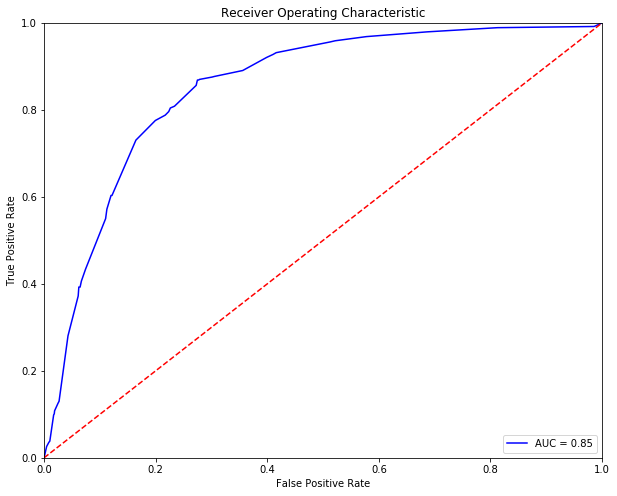

Optimal Threshold is 0.352272727273
Accuracy of Logistic Model on training data is: 0.79322853688


Predicted   0.0  1.0  __all__
Actual                       
0.0        1401  349     1750
1.0         164  567      731
__all__    1565  916     2481

In [226]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [227]:
table_70_70_20_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [228]:
%%capture
table_70_70_20_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

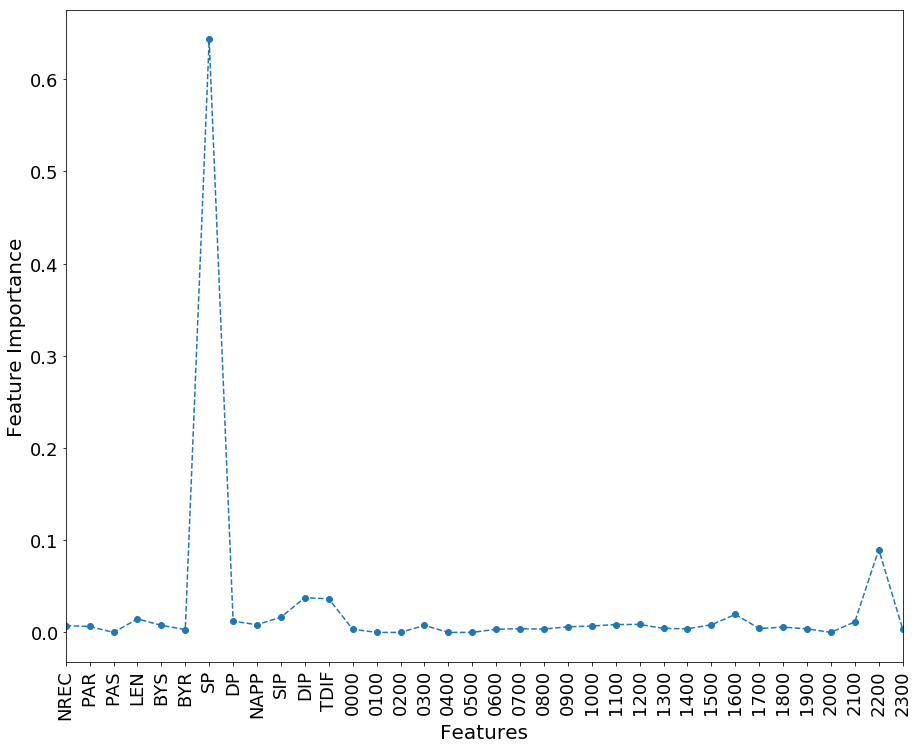

In [229]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [230]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.2          0.4          1500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.951459664882

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3980    59     4039
1           222  1528     1750
__all__    4202  1587     5789

Accuracy of the  Bagging  model for test data is: 0.817815397017

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1519  231     1750
1           221  510      731
__all__    1740  741     2481

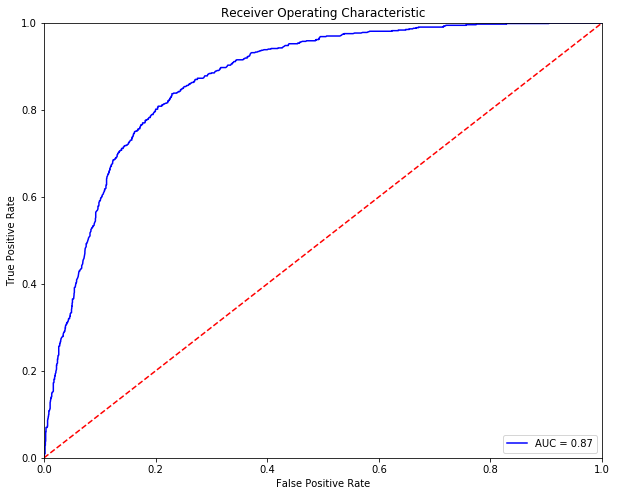

Optimal Threshold is 0.364
Accuracy of Logistic Model on training data is: 0.800080612656


Predicted   0.0  1.0  __all__
Actual                       
0.0        1401  349     1750
1.0         147  584      731
__all__    1548  933     2481

In [231]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [232]:
table_70_70_20_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_20_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [233]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.936949386768


Predicted     0     1  __all__
Actual                        
0          3959    80     4039
1           285  1465     1750
__all__    4244  1545     5789

The test accuracy is: 0.798065296252


Predicted     0    1  __all__
Actual                       
0          1517  233     1750
1           268  463      731
__all__    1785  696     2481

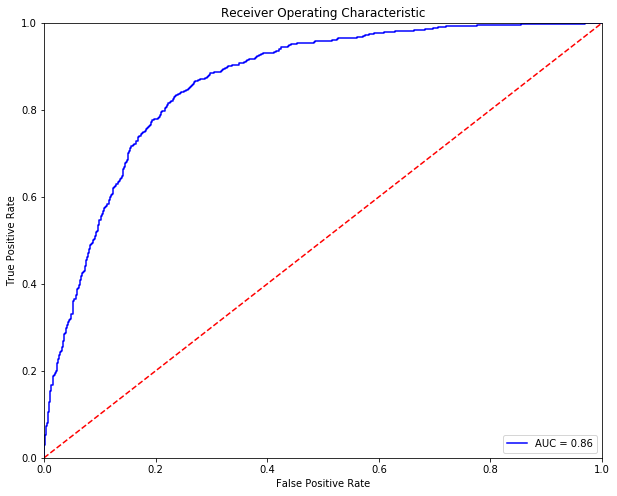

Optimal Threshold is 0.363544871772
Accuracy of Logistic Model on training data is: 0.790407093914


Predicted   0.0  1.0  __all__
Actual                       
0.0        1384  366     1750
1.0         154  577      731
__all__    1538  943     2481

In [234]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [235]:
table_70_70_20_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_20_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [236]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.923475557204


Predicted     0     1  __all__
Actual                        
0          3923   116     4039
1           327  1423     1750
__all__    4250  1539     5789

The accuracy of the model on test data is: 0.789197904071


Predicted     0    1  __all__
Actual                       
0          1537  213     1750
1           310  421      731
__all__    1847  634     2481

2336/2481 [===========================>..] - ETA: 0s

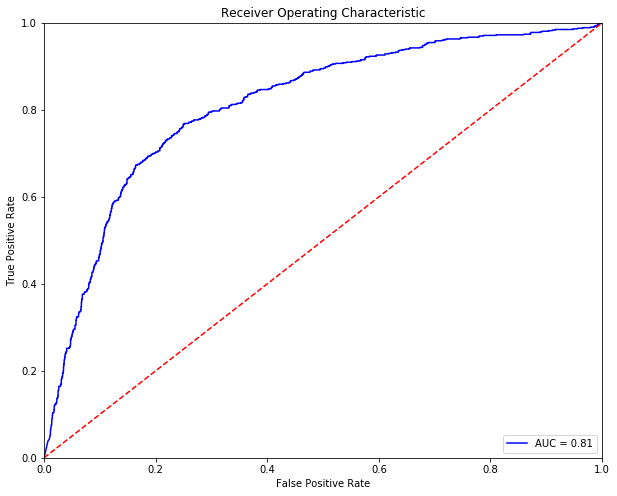

Optimal Threshold is 0.125783
Accuracy of Logistic Model on training data is: 0.756549778315


Predicted   0.0  1.0  __all__
Actual                       
0.0        1325  425     1750
1.0         179  552      731
__all__    1504  977     2481

In [237]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [238]:
table_70_70_20_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_20_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [239]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  5.9min finished


The accuracy of the model on training data is: 0.821730868889


Predicted     0     1  __all__
Actual                        
0          3537   502     4039
1           530  1220     1750
__all__    4067  1722     5789

The accuracy of the model on test data is: 0.806529625151


Predicted     0    1  __all__
Actual                       
0          1526  224     1750
1           256  475      731
__all__    1782  699     2481

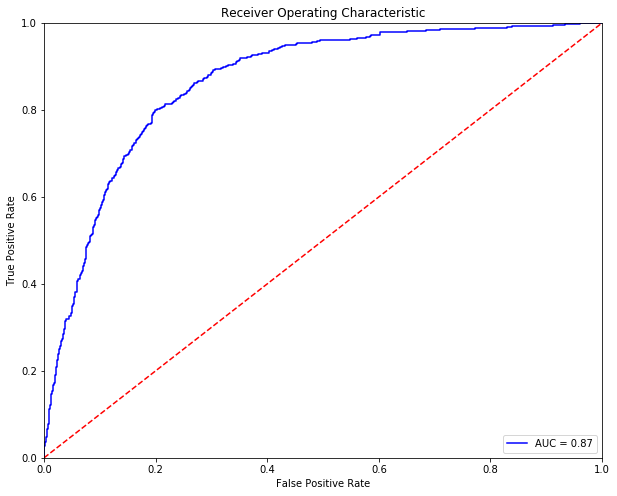

Optimal Threshold is 0.365001
Accuracy of Logistic Model on training data is: 0.799274486094


Predicted   0.0  1.0  __all__
Actual                       
0.0        1399  351     1750
1.0         147  584      731
__all__    1546  935     2481

In [240]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [241]:
table_70_70_20_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_20_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [242]:
table_70_70_20_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_20_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_20_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_70_70_20_test.set_index(['index'],drop=True,inplace=True)
table_70_70_20_train.set_index(['index'],drop=True,inplace=True)
table_70_70_20_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_70_20_train)

print("Comparision Table for Test Accuracies:")
display(table_70_70_20_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_70_20_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        0.803766  1085.0  3568.0  471.0  665.0  0.116613   
LogisticRegression          0.798238  1261.0  3360.0  679.0  489.0  0.168111   
RandomForestClassifier      0.799274  1324.0  3303.0  736.0  426.0  0.182223   
AdaBoostClassifier          0.808775  1266.0  3416.0  623.0  484.0  0.154246   
GradientBoostingClassifier  0.821040  1256.0  3497.0  542.0  494.0  0.134192   
ExtraTreeClassifier         0.819485  1134.0  3610.0  429.0  616.0  0.106214   
BaggingClassifier           0.951460  1528.0  3980.0   59.0  222.0  0.014608   
VotingClassifier            0.936949  1465.0  3959.0   80.0  285.0  0.019807   
Neural Network-1            0.923476  1423.0  3923.0  116.0  327.0  0.028720   
Neural-Network-2            0.821731  1220.0  3537.0  502.0  530.0  0.124288   

                                 FNR  
index                                 
KNeighborsClassifier        0.380000  
LogisticRegression          0.279429  
RandomForestClassifier      0.243429  
AdaBoostClassifier          0.276571  
GradientBoostingClassifier  0.282286  
ExtraTreeClassifier         0.352000  
BaggingClassifier           0.126857  
VotingClassifier            0.162857  
Neural Network-1            0.186857  
Neural-Network-2            0.302857

Comparision Table for Test Accuracies:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.810963  446.0  1566.0  184.0  285.0  0.105143   
LogisticRegression          0.805320  516.0  1482.0  268.0  215.0  0.153143   
RandomForestClassifier      0.808545  542.0  1464.0  286.0  189.0  0.163429   
AdaBoostClassifier          0.806127  523.0  1477.0  273.0  208.0  0.156000   
GradientBoostingClassifier  0.811366  491.0  1522.0  228.0  240.0  0.130286   
ExtraTreeClassifier         0.798468  441.0  1540.0  210.0  290.0  0.120000   
BaggingClassifier           0.817815  510.0  1519.0  231.0  221.0  0.132000   
VotingClassifier            0.798065  463.0  1517.0  233.0  268.0  0.133143   
Neural Network-1            0.789198  421.0  1537.0  213.0  310.0  0.121714   
Neural-Network-2            0.806530  475.0  1526.0  224.0  256.0  0.128000   

                                 FNR  
index                                 
KNeighborsClassifier        0.389877  
LogisticRegression          0.294118  
RandomForestClassifier      0.258550  
AdaBoostClassifier          0.284542  
GradientBoostingClassifier  0.328317  
ExtraTreeClassifier         0.396717  
BaggingClassifier           0.302326  
VotingClassifier            0.366621  
Neural Network-1            0.424077  
Neural-Network-2            0.350205

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.802902  569.0  1423.0  327.0  162.0  0.186857   
LogisticRegression          0.785973  572.0  1378.0  372.0  159.0  0.212571   
RandomForestClassifier      0.792422  578.0  1388.0  362.0  153.0  0.206857   
AdaBoostClassifier          0.800081  583.0  1402.0  348.0  148.0  0.198857   
GradientBoostingClassifier  0.805320  588.0  1410.0  340.0  143.0  0.194286   
ExtraTreeClassifier         0.793229  567.0  1401.0  349.0  164.0  0.199429   
BaggingClassifier           0.800081  584.0  1401.0  349.0  147.0  0.199429   
VotingClassifier            0.790407  577.0  1384.0  366.0  154.0  0.209143   
Neural Network-1            0.756550  552.0  1325.0  425.0  179.0  0.242857   
Neural-Network-2            0.799274  584.0  1399.0  351.0  147.0  0.200571   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.221614   0.320000  0.870030  
LogisticRegression          0.217510   0.380973  0.863107  
RandomForestClassifier      0.209302   0.316440  0.859545  
AdaBoostClassifier          0.202462   0.480412  0.870902  
GradientBoostingClassifier  0.195622   0.352003  0.876434  
ExtraTreeClassifier         0.224350   0.352273  0.852794  
BaggingClassifier           0.201094   0.364000  0.872964  
VotingClassifier            0.210670   0.363545  0.863819  
Neural Network-1            0.244870   0.125783  0.811488  
Neural-Network-2            0.201094   0.365001  0.865141

### <a id='1.C' style="text-decoration : none; color : #000000;">C. 80:20 Train Test split with PCA</a>

#### Random State 0

In [243]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_0.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())

X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.2)

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC        PAR  \
Source_User                                                           
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  4607  77.507923   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   169   5.840237   

                                                          PAS         LEN  \
Source_User                                                                 
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  40.245713  100.283265   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   5.597633  149.763314   

                                                            BYS           BYR  \
Source_User                                                                     
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  6930.568483  89947.788800   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...  1016.976331   3222.147929   

                                                        SP     DP  NAPP  SIP  \
Source_User                                                                    
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  3901.0  113.0    58   86   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   168.0    4.0     9   11   

                                                     DIP          TDIF  0000  \
Source_User                                                                    
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  1116   1646.597569   167   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...    16  40005.674556     0   

                                                    0100  0200  0300  0400  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   295   328   198   223   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0     0   

                                                    0500  0600  0700  0800  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   135   144   145   194   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0     8   

                                                    0900  1000  1100  1200  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   197   196   178   120   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     8     0     0    39   

                                                    1300  1400  1500  1600  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   145   118   224   172   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...    48    40    10     4   

                                                    1700  1800  1900  2000  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   241   246   151   165   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     4     2     6     0   

                                                    2100  2200  2300  
Source_User                                                           
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   177   134   314  
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0

1 -> Infected
0 -> Uninfected


Source_User
bb98d45a9bd0c40362a3ec37503c10b8238194752d355742cd3ea35221dc98b1    1
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e215137c4ad8c46fc5    0
56a003f863f8cc9342216fa01a3ab0aebf4a04ed0dd8d5b89a95f779cc707dd5    1
f894aec69ce612e29505d6d3cd9112bbe39d6a46e7da2682d14a1cbd9c4cd297    0
9aadb359b9763e3d68e62ad3c406245fcf0bc4919395dbf42532e49d8b5aa02d    1
dbea3804991397c518e0198f2b63ecab35cbf38083cb5e19bb9d4b4f4bacaa2d    1
f2327a8577d940bf7100353fce41bbde184c6e4ead193ab60986bb3ef2551718    1
d815eb7ef3af2a56e8260b0b3a6bb3c1bf70c625619caa930cff27beced41ea1    1
ae3fe786080d0c4a0d3520152bb59d60836d2ae6fdb4870a1879b98ea7ec02fc    1
45b5cf89d8e8ff70ce05570a97d5ff05783283281eade7d8b736c94a24cfb16c    1
Name: Target, dtype: int64

Variance explained using 13 components is: 0.922348229056
The train/test split ratio is 80:20


In [244]:
display(X_pca_13[0:1])

array([[ 0.51069587, -0.17479937, -0.18757661, -0.21230661, -0.83309263,
         0.55899882,  0.157608  , -0.1043382 ,  0.82023985, -0.32529949,
         0.30768313, -0.3310058 , -1.04421636]])

In [245]:
## Table to store training and test measures
table_80_70_PCA_0_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_PCA_0_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_PCA_0_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [246]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  manhattan           30  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4643     0     4643
1             0  1973     1973
__all__    4643  1973     6616

Accuracy of the  KNN  model for test data is: 0.787182587666

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1029  117     1146
1           235  273      508
__all__    1264  390     1654

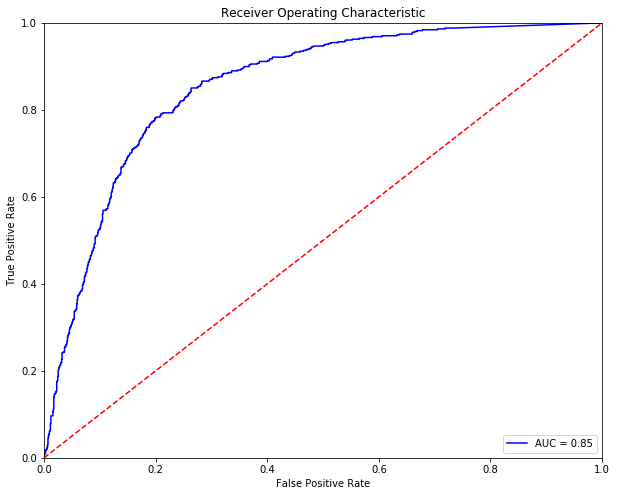

Optimal Threshold is 0.289455825289
Accuracy of Logistic Model on training data is: 0.790205562273


Predicted   0.0  1.0  __all__
Actual                       
0.0         906  240     1146
1.0         107  401      508
__all__    1013  641     1654

In [247]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [248]:
table_80_70_PCA_0_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_0_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [249]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False          False                0.7       100  multinomial   

             6       7      8  
index  penalty  solver    tol  
0           l2     sag  0.001

Accuracy of the  Logistic  model for the training data is: 0.800634824667

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3749   894     4643
1           425  1548     1973
__all__    4174  2442     6616

Accuracy of the  Logistic  model for test data is: 0.799274486094

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           926  220     1146
1           112  396      508
__all__    1038  616     1654

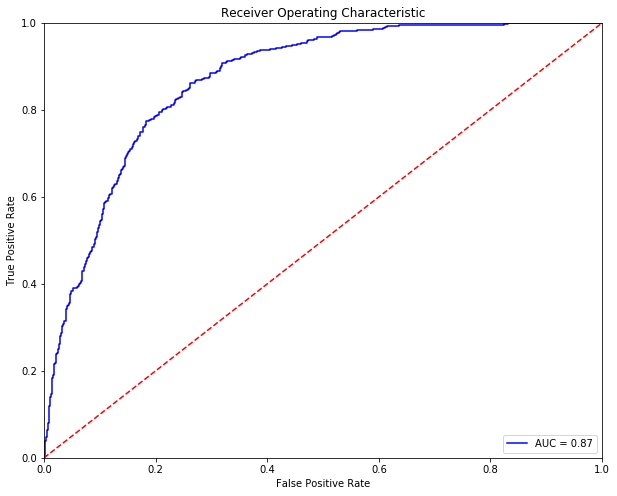

Optimal Threshold is 0.47938288598
Accuracy of Logistic Model on training data is: 0.79322853688


Predicted   0.0  1.0  __all__
Actual                       
0.0         909  237     1146
1.0         105  403      508
__all__    1014  640     1654

In [250]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [251]:
table_80_70_PCA_0_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_0_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [252]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[2000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1          2000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.701783555018

Confusion Matrix for Training data is:


Predicted     0  1  __all__
Actual                     
0          4643  0     4643
1          1973  0     1973
__all__    6616  0     6616

Accuracy of the  Random Forest Trees  model for test data is: 0.692865779927

Confusion Matrix for test data is:


Predicted     0  1  __all__
Actual                     
0          1146  0     1146
1           508  0      508
__all__    1654  0     1654

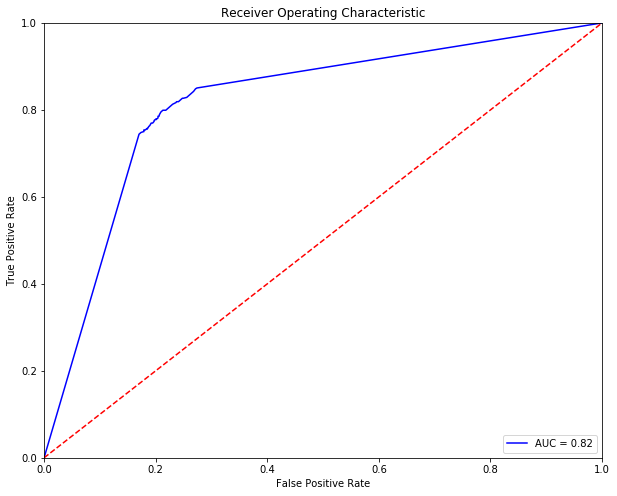

Optimal Threshold is 0.263892133322
Accuracy of Logistic Model on training data is: 0.791414752116


Predicted   0.0  1.0  __all__
Actual                       
0.0         910  236     1146
1.0         109  399      508
__all__    1019  635     1654

In [253]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [254]:
table_80_70_PCA_0_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_0_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

4643
0
0
4643
1973
0
0
1973
1.0
0.0
0.0
1.0
1146
0
0
1146
508
0
0
508
1.0
0.0
0.0
1.0


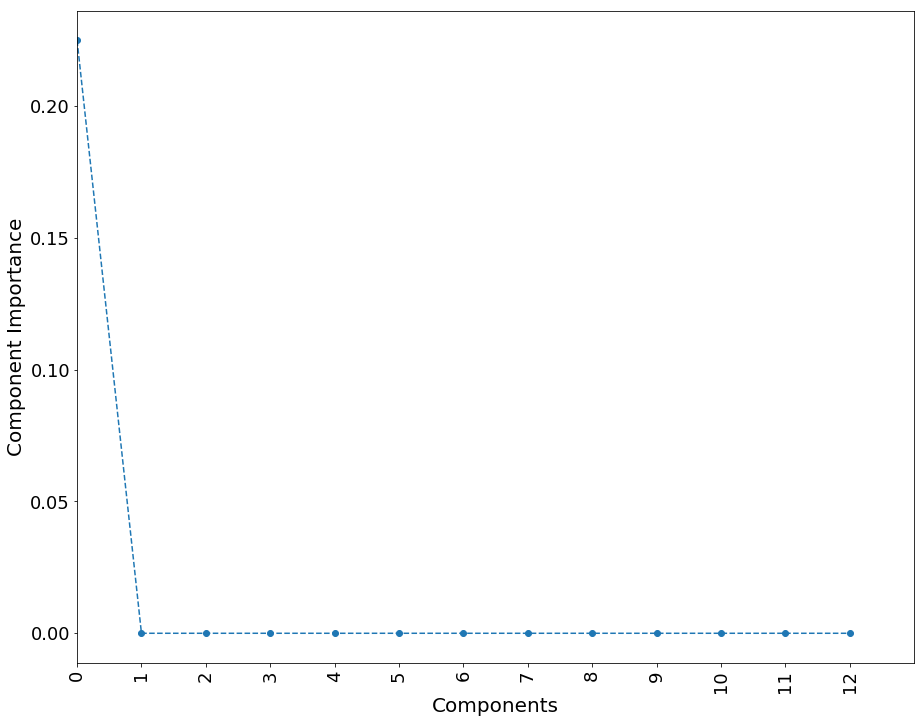

In [255]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [256]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME            0.5           400             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.809854897219

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3910   733     4643
1           525  1448     1973
__all__    4435  2181     6616

Accuracy of the  AdaBoostClassifier  model for test data is: 0.798065296252

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           955  191     1146
1           143  365      508
__all__    1098  556     1654

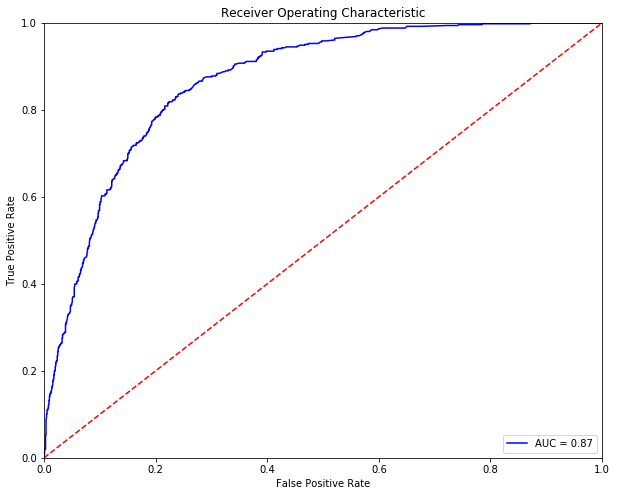

Optimal Threshold is 0.477024200298
Accuracy of Logistic Model on training data is: 0.791414752116


Predicted   0.0  1.0  __all__
Actual                       
0.0         907  239     1146
1.0         106  402      508
__all__    1013  641     1654

In [257]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [258]:
table_80_70_PCA_0_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_0_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

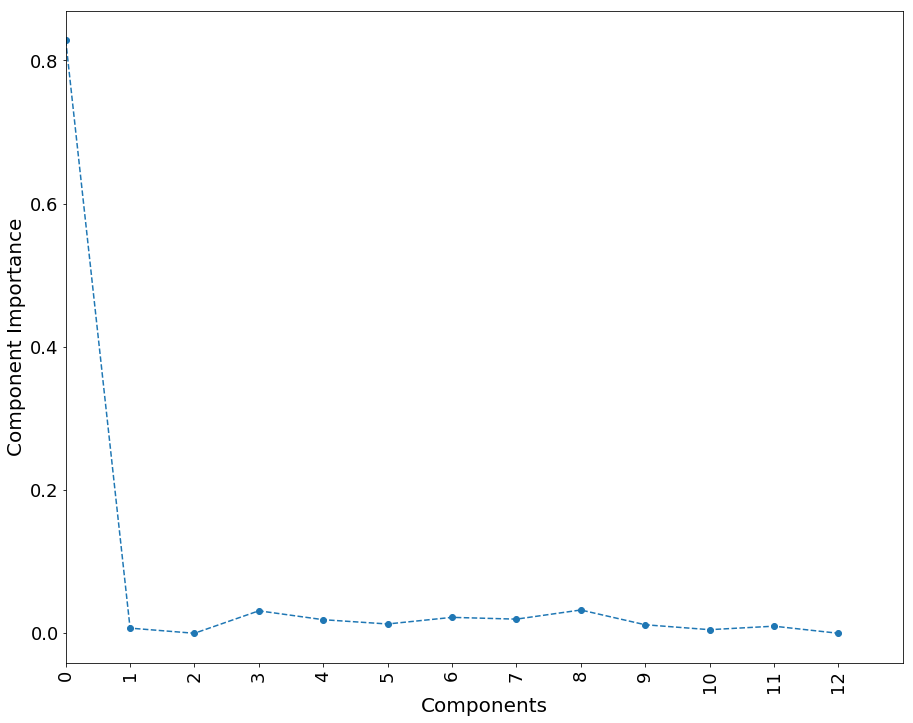

In [259]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [260]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse           0.05  exponential                20   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.3           150             0          1

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.820133010883

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4027   616     4643
1           574  1399     1973
__all__    4601  2015     6616

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.807134220073

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           984  162     1146
1           157  351      508
__all__    1141  513     1654

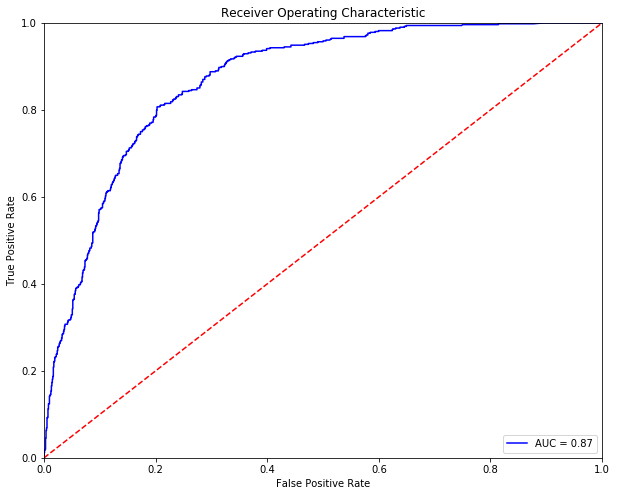

Optimal Threshold is 0.345321158759
Accuracy of Logistic Model on training data is: 0.798065296252


Predicted   0.0  1.0  __all__
Actual                       
0.0         915  231     1146
1.0         103  405      508
__all__    1018  636     1654

In [261]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [262]:
table_80_70_PCA_0_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_0_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

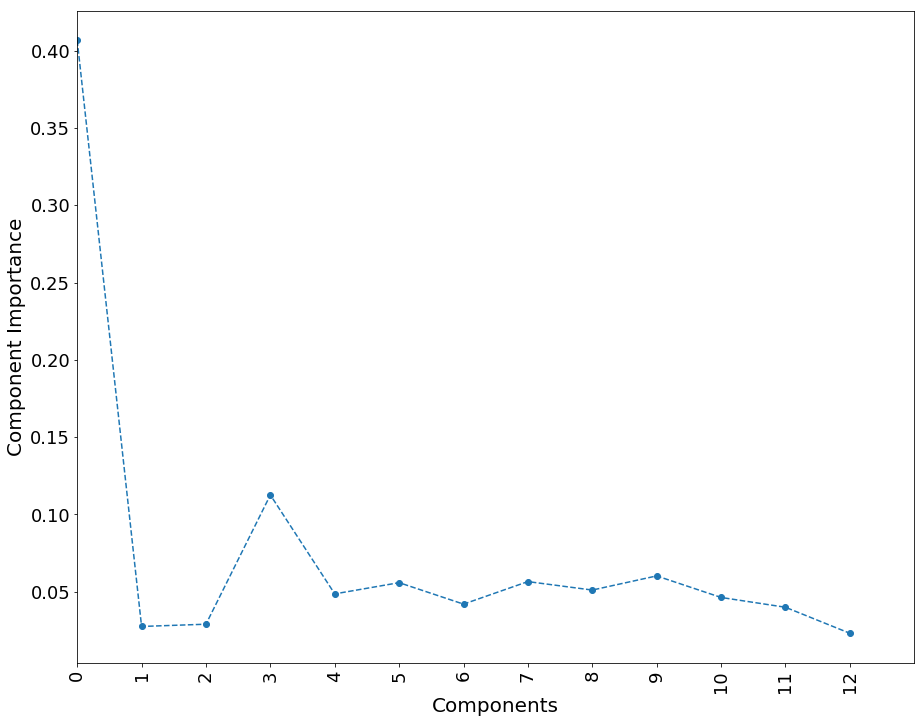

In [263]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [264]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0           gini         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.794588875453

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3913   730     4643
1           629  1344     1973
__all__    4542  2074     6616

Accuracy of the  Extra Decision Tree  model for test data is: 0.773276904474

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           956  190     1146
1           185  323      508
__all__    1141  513     1654

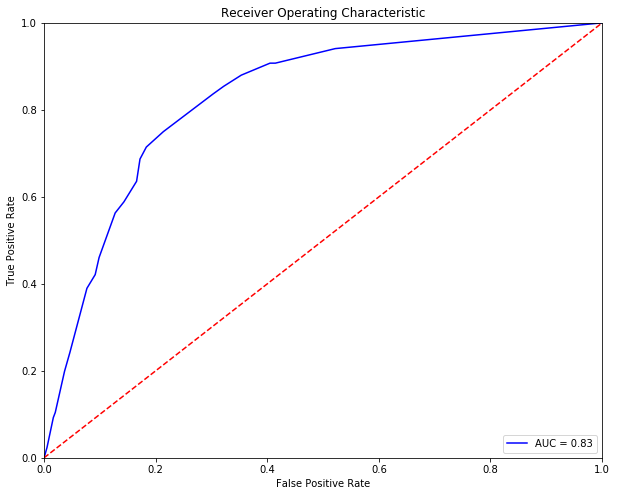

Optimal Threshold is 0.268907563025
Accuracy of Logistic Model on training data is: 0.785368802902


Predicted   0.0  1.0  __all__
Actual                       
0.0         936  210     1146
1.0         145  363      508
__all__    1081  573     1654

In [265]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [266]:
table_80_70_PCA_0_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [267]:
%%capture
table_80_70_PCA_0_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

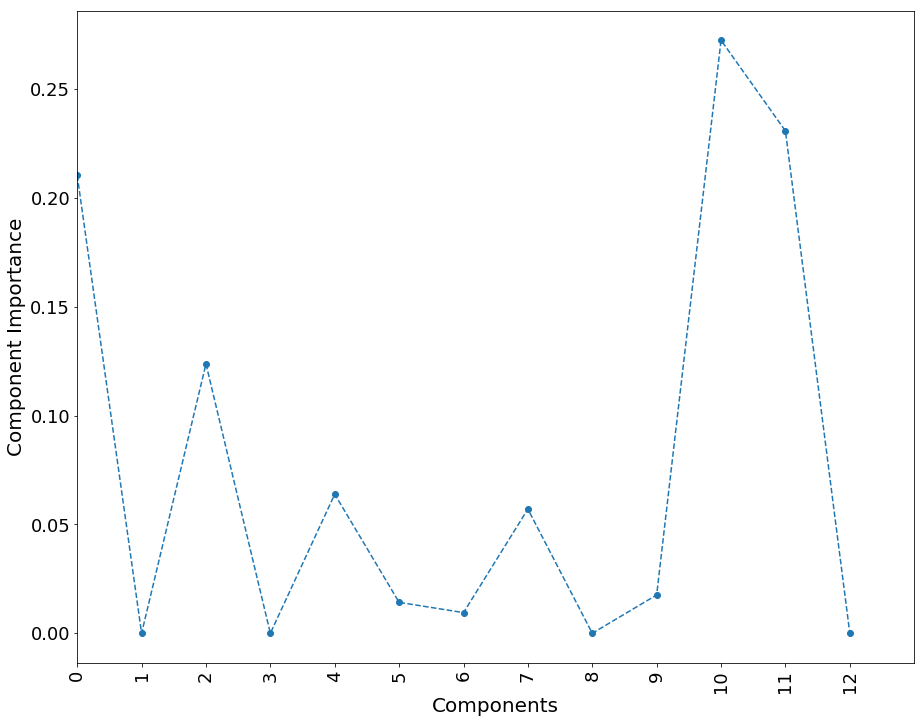

In [268]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [269]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.4           500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.961457073761

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4606    37     4643
1           218  1755     1973
__all__    4824  1792     6616

Accuracy of the  Bagging  model for test data is: 0.792019347037

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           998  148     1146
1           196  312      508
__all__    1194  460     1654

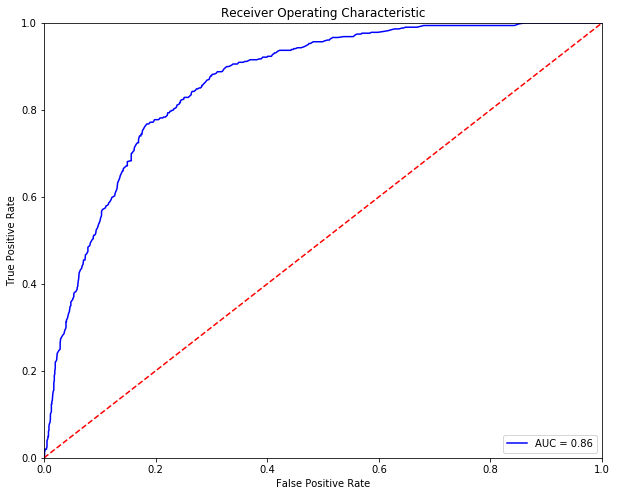

Optimal Threshold is 0.386
Accuracy of Logistic Model on training data is: 0.784159613059


Predicted   0.0  1.0  __all__
Actual                       
0.0         899  247     1146
1.0         110  398      508
__all__    1009  645     1654

In [270]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [271]:
table_80_70_PCA_0_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_0_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [272]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.945284159613


Predicted     0     1  __all__
Actual                        
0          4610    33     4643
1           329  1644     1973
__all__    4939  1677     6616

The test accuracy is: 0.791414752116


Predicted     0    1  __all__
Actual                       
0          1024  122     1146
1           223  285      508
__all__    1247  407     1654

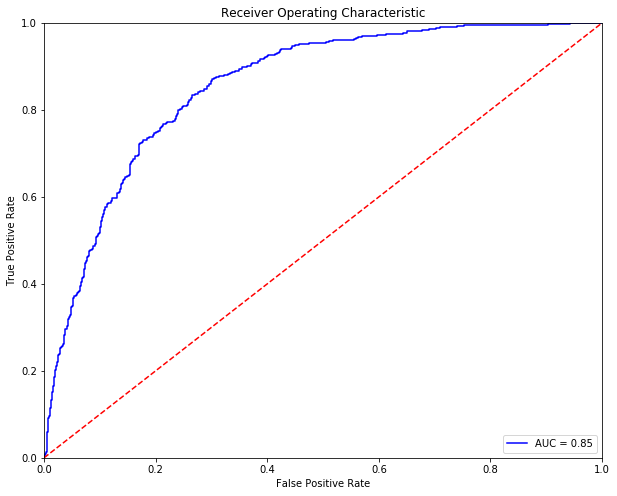

Optimal Threshold is 0.354501362407
Accuracy of Logistic Model on training data is: 0.770253929867


Predicted  0.0  1.0  __all__
Actual                      
0.0        882  264     1146
1.0        116  392      508
__all__    998  656     1654

In [273]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [274]:
table_80_70_PCA_0_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_0_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [275]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.852025392915


Predicted     0     1  __all__
Actual                        
0          4099   544     4643
1           435  1538     1973
__all__    4534  2082     6616

The accuracy of the model on test data is: 0.784764207981


Predicted     0    1  __all__
Actual                       
0           952  194     1146
1           162  346      508
__all__    1114  540     1654

1312/1654 [======================>.......] - ETA: 0s

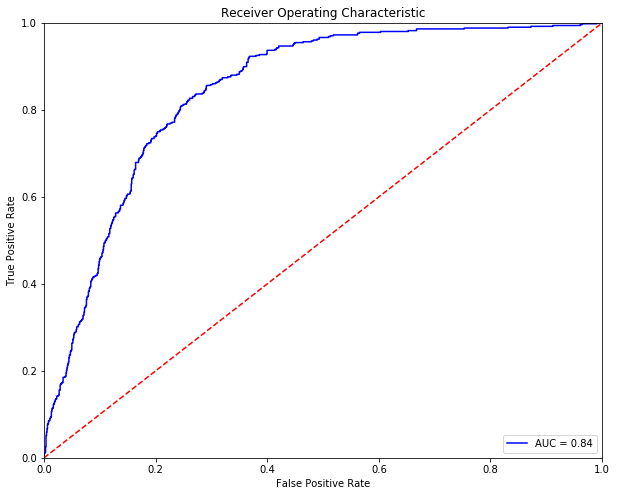

Optimal Threshold is 0.393205
Accuracy of Logistic Model on training data is: 0.770858524788


Predicted   0.0  1.0  __all__
Actual                       
0.0         884  262     1146
1.0         117  391      508
__all__    1001  653     1654

In [276]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [277]:
table_80_70_PCA_0_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_0_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [278]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  7.0min finished


The accuracy of the model on training data is: 0.813935912938


Predicted     0     1  __all__
Actual                        
0          3884   759     4643
1           472  1501     1973
__all__    4356  2260     6616

The accuracy of the model on test data is: 0.802297460701


Predicted     0    1  __all__
Actual                       
0           952  194     1146
1           133  375      508
__all__    1085  569     1654

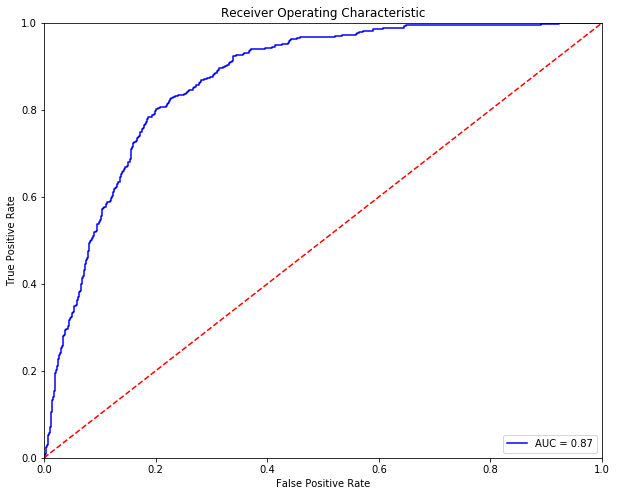

Optimal Threshold is 0.392106
Accuracy of Logistic Model on training data is: 0.799879081016


Predicted   0.0  1.0  __all__
Actual                       
0.0         917  229     1146
1.0         102  406      508
__all__    1019  635     1654

In [279]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [280]:
table_80_70_PCA_0_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_0_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [281]:
table_80_70_PCA_0_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_PCA_0_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_PCA_0_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_70_PCA_0_test.set_index(['index'],drop=True,inplace=True)
table_80_70_PCA_0_train.set_index(['index'],drop=True,inplace=True)
table_80_70_PCA_0_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_70_PCA_0_train)

print("Comparision Table for Test Accuracies:")
display(table_80_70_PCA_0_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_70_PCA_0_test_roc)

Comparision Table for Training Accuracies:


accuracy           TP           TN           FP  \
index                                                                         
KNeighborsClassifier        1.000000  1973.000000  4643.000000     0.000000   
LogisticRegression          0.800635  1548.000000  3749.000000   894.000000   
RandomForestClassifier      0.701784  3258.381046  1384.618954  1384.618954   
AdaBoostClassifier          0.809855  1448.000000  3910.000000   733.000000   
GradientBoostingClassifier  0.820133  1399.000000  4027.000000   616.000000   
ExtraTreeClassifier         0.794589  1344.000000  3913.000000   730.000000   
BaggingClassifier           0.961457  1755.000000  4606.000000    37.000000   
VotingClassifier            0.945284  1644.000000  4610.000000    33.000000   
Neural Network-1            0.852025  1538.000000  4099.000000   544.000000   
Neural-Network-2            0.813936  1501.000000  3884.000000   759.000000   

                                    FN       FPR       FNR  
index                                                       
KNeighborsClassifier          0.000000  0.000000  0.000000  
LogisticRegression          425.000000  0.192548  0.215408  
RandomForestClassifier      588.381046  0.701784  0.298216  
AdaBoostClassifier          525.000000  0.157872  0.266092  
GradientBoostingClassifier  574.000000  0.132673  0.290928  
ExtraTreeClassifier         629.000000  0.157226  0.318804  
BaggingClassifier           218.000000  0.007969  0.110492  
VotingClassifier            329.000000  0.007107  0.166751  
Neural Network-1            435.000000  0.117166  0.220476  
Neural-Network-2            472.000000  0.163472  0.239230

Comparision Table for Test Accuracies:


accuracy          TP           TN          FP  \
index                                                                       
KNeighborsClassifier        0.787183  273.000000  1029.000000  117.000000   
LogisticRegression          0.799274  396.000000   926.000000  220.000000   
RandomForestClassifier      0.692866  794.024184   351.975816  351.975816   
AdaBoostClassifier          0.798065  365.000000   955.000000  191.000000   
GradientBoostingClassifier  0.807134  351.000000   984.000000  162.000000   
ExtraTreeClassifier         0.773277  323.000000   956.000000  190.000000   
BaggingClassifier           0.792019  312.000000   998.000000  148.000000   
VotingClassifier            0.791415  285.000000  1024.000000  122.000000   
Neural Network-1            0.784764  346.000000   952.000000  194.000000   
Neural-Network-2            0.802297  375.000000   952.000000  194.000000   

                                    FN       FPR       FNR  
index                                                       
KNeighborsClassifier        235.000000  0.102094  0.462598  
LogisticRegression          112.000000  0.191972  0.220472  
RandomForestClassifier      156.024184  0.692866  0.307134  
AdaBoostClassifier          143.000000  0.166667  0.281496  
GradientBoostingClassifier  157.000000  0.141361  0.309055  
ExtraTreeClassifier         185.000000  0.165794  0.364173  
BaggingClassifier           196.000000  0.129145  0.385827  
VotingClassifier            223.000000  0.106457  0.438976  
Neural Network-1            162.000000  0.169284  0.318898  
Neural-Network-2            133.000000  0.169284  0.261811

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.790206  401.0  906.0  240.0  107.0  0.209424   
LogisticRegression          0.793229  403.0  909.0  237.0  105.0  0.206806   
RandomForestClassifier      0.791415  399.0  910.0  236.0  109.0  0.205934   
AdaBoostClassifier          0.791415  402.0  907.0  239.0  106.0  0.208551   
GradientBoostingClassifier  0.798065  405.0  915.0  231.0  103.0  0.201571   
ExtraTreeClassifier         0.785369  363.0  936.0  210.0  145.0  0.183246   
BaggingClassifier           0.784160  398.0  899.0  247.0  110.0  0.215532   
VotingClassifier            0.770254  392.0  882.0  264.0  116.0  0.230366   
Neural Network-1            0.770859  391.0  884.0  262.0  117.0  0.228621   
Neural-Network-2            0.799879  406.0  917.0  229.0  102.0  0.199825   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.210630   0.289456  0.854071  
LogisticRegression          0.206693   0.479383  0.869642  
RandomForestClassifier      0.214567   0.263892  0.818058  
AdaBoostClassifier          0.208661   0.477024  0.867499  
GradientBoostingClassifier  0.202756   0.345321  0.868699  
ExtraTreeClassifier         0.285433   0.268908  0.828549  
BaggingClassifier           0.216535   0.386000  0.862925  
VotingClassifier            0.228346   0.354501  0.854594  
Neural Network-1            0.230315   0.393205  0.844209  
Neural-Network-2            0.200787   0.392106  0.866860

#### Random State 10

In [282]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_10.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())

X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.2)

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  3030  230.950495   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...   599  158.008347   

                                                          PAS        LEN  \
Source_User                                                                
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  80.524092  84.155116   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  57.856427  82.028381   

                                                            BYS  \
Source_User                                                       
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  9686.861716   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  6161.512521   

                                                              BYR      SP  \
Source_User                                                                 
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  287727.528383  2741.0   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  198461.532554   587.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  11.0    40   63  820   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  12.0    30   70  210   

                                                            TDIF  0000  0100  \
Source_User                                                                    
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   2395.224422   195   256   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  12098.198664     0     3   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   110    55    63    53   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     3     2     4     2   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...    56    31    79    81   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     0    34    70    92   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...    39    75    98    81   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...   117    30    10    14   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   159   264   181   142   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     7     5    25    37   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   177   135   120   184   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...    61    27    27    25   

                                                    2200  2300  
Source_User                                                     
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   240   156  
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     1     3

1 -> Infected
0 -> Uninfected


Source_User
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3449af4e82e30f9f87    0
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce851fca5724939971862    1
06fe39332e5261ed8a5f1bb9d62559deb0de1620963ebbded14eecf78b8a0a20    0
5455eddbb8ee814c41a27e8676a6cc34faa6fc295c6e92588fc75dbe7f61369b    0
47a99c45d555e42658dbf94be7417ec6c327ecfc05ed5c57eaac1de3bd43bb86    1
60ff3ff13bb2e6a16dc866bc314964cc6d60b1e9891d805e7d9e99b1864ae896    1
a4244338cc086f69de152063f5b11482be2d007a5da089331dc2fe778e459e26    1
70de2ff22d8dd1433aa38947470f94f455bcbdabb1789e81332ba5c390408acc    1
6c49763f6a507ebf7aff12e40a61cfe3624fca5d5ac9dc1b86ac38c68ca4b1ba    0
ab60d8ea5924263ddfde9661ee4a4081f95679c77492da4479cd0350f56c7de3    0
Name: Target, dtype: int64

Variance explained using 13 components is: 0.915617452326
The train/test split ratio is 80:20


In [283]:
display(X_pca_13[0:1])

array([[ 0.1092487 ,  0.09758928, -0.52784745,  0.50560657, -0.430521  ,
        -0.43954403,  0.08248622,  0.03391669, -0.09021769,  0.28432751,
         0.05267798, -0.86988474, -0.07038592]])

In [284]:
## Table to store training and test measures
table_80_70_PCA_10_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_PCA_10_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_PCA_10_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [285]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  euclidean           50  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4647     0     4647
1             0  1969     1969
__all__    4647  1969     6616

Accuracy of the  KNN  model for test data is: 0.790205562273

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1006  136     1142
1           211  301      512
__all__    1217  437     1654

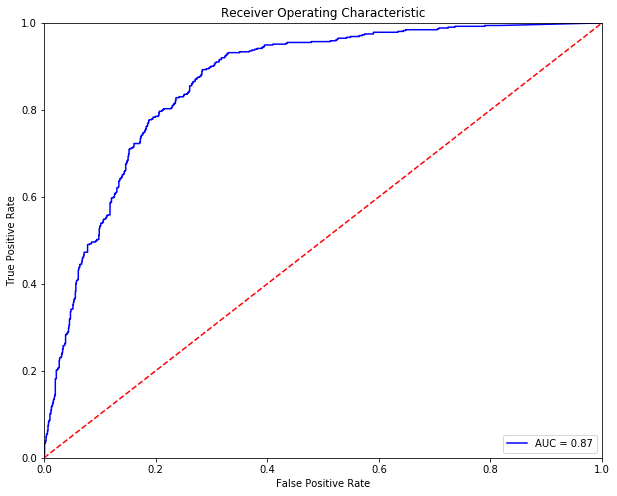

Optimal Threshold is 0.307780102703
Accuracy of Logistic Model on training data is: 0.793833131802


Predicted   0.0  1.0  __all__
Actual                       
0.0         907  235     1142
1.0         106  406      512
__all__    1013  641     1654

In [286]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [287]:
table_80_70_PCA_10_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_10_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [288]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False          False                0.5        50  multinomial   

             6          7      8  
index  penalty     solver    tol  
0           l2  newton-cg  1e-05

Accuracy of the  Logistic  model for the training data is: 0.797158403869

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3780   867     4647
1           475  1494     1969
__all__    4255  2361     6616

Accuracy of the  Logistic  model for test data is: 0.80169286578

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           920  222     1142
1           106  406      512
__all__    1026  628     1654

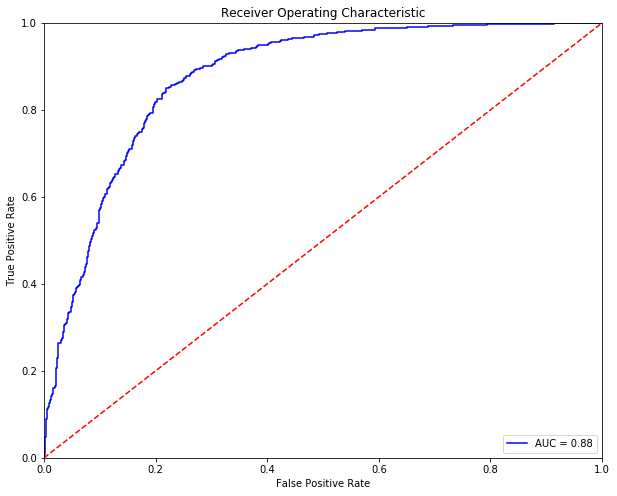

Optimal Threshold is 0.496067850355
Accuracy of Logistic Model on training data is: 0.804715840387


Predicted   0.0  1.0  __all__
Actual                       
0.0         919  223     1142
1.0         100  412      512
__all__    1019  635     1654

In [289]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [290]:
table_80_70_PCA_10_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_10_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [291]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[2000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1          2000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.70238814994

Confusion Matrix for Training data is:


Predicted     0  1  __all__
Actual                     
0          4647  0     4647
1          1969  0     1969
__all__    6616  0     6616

Accuracy of the  Random Forest Trees  model for test data is: 0.690447400242

Confusion Matrix for test data is:


Predicted     0  1  __all__
Actual                     
0          1142  0     1142
1           512  0      512
__all__    1654  0     1654

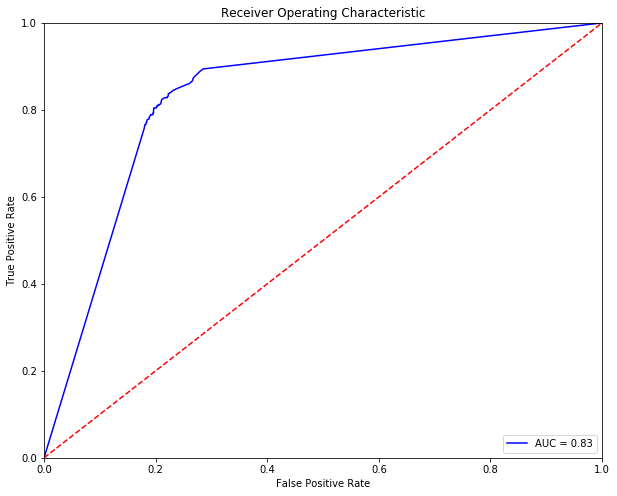

Optimal Threshold is 0.31327286378
Accuracy of Logistic Model on training data is: 0.802297460701


Predicted   0.0  1.0  __all__
Actual                       
0.0         918  224     1142
1.0         103  409      512
__all__    1021  633     1654

In [292]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [293]:
table_80_70_PCA_10_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_10_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

4647
0
0
4647
1969
0
0
1969
1.0
0.0
0.0
1.0
1142
0
0
1142
512
0
0
512
1.0
0.0
0.0
1.0


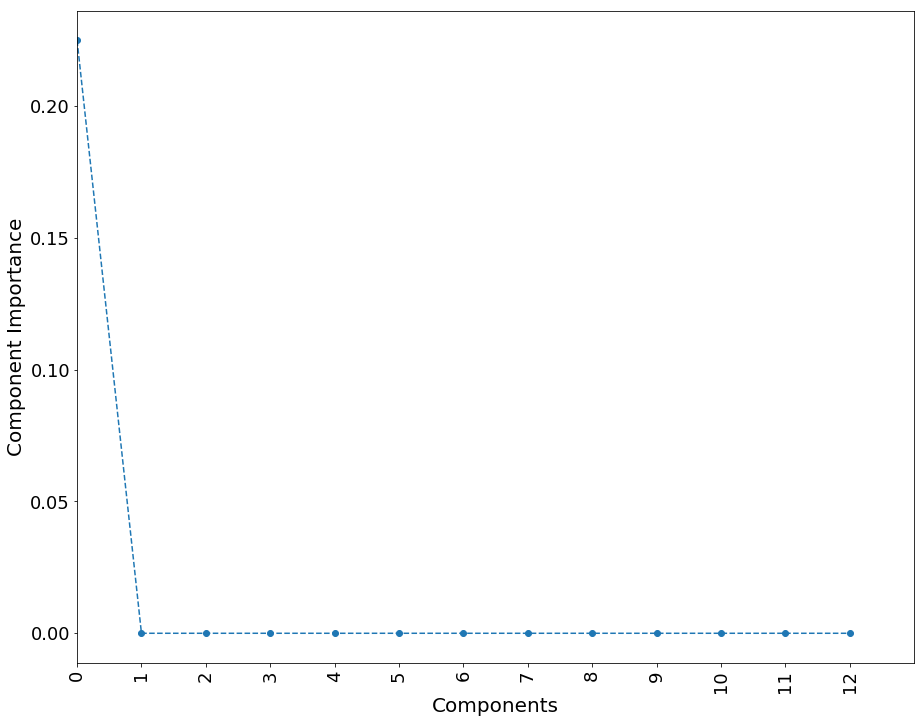

In [294]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [295]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME            0.5           150             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.795495767836

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3817   830     4647
1           523  1446     1969
__all__    4340  2276     6616

Accuracy of the  AdaBoostClassifier  model for test data is: 0.801088270859

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           930  212     1142
1           117  395      512
__all__    1047  607     1654

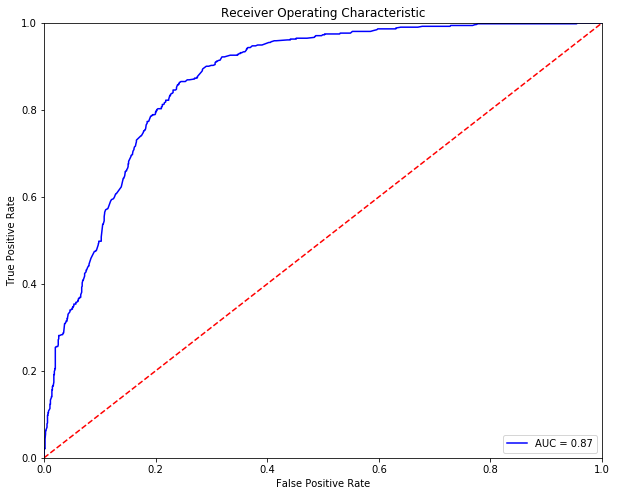

Optimal Threshold is 0.478783188272
Accuracy of Logistic Model on training data is: 0.798065296252


Predicted   0.0  1.0  __all__
Actual                       
0.0         912  230     1142
1.0         104  408      512
__all__    1016  638     1654

In [296]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [297]:
table_80_70_PCA_10_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_10_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

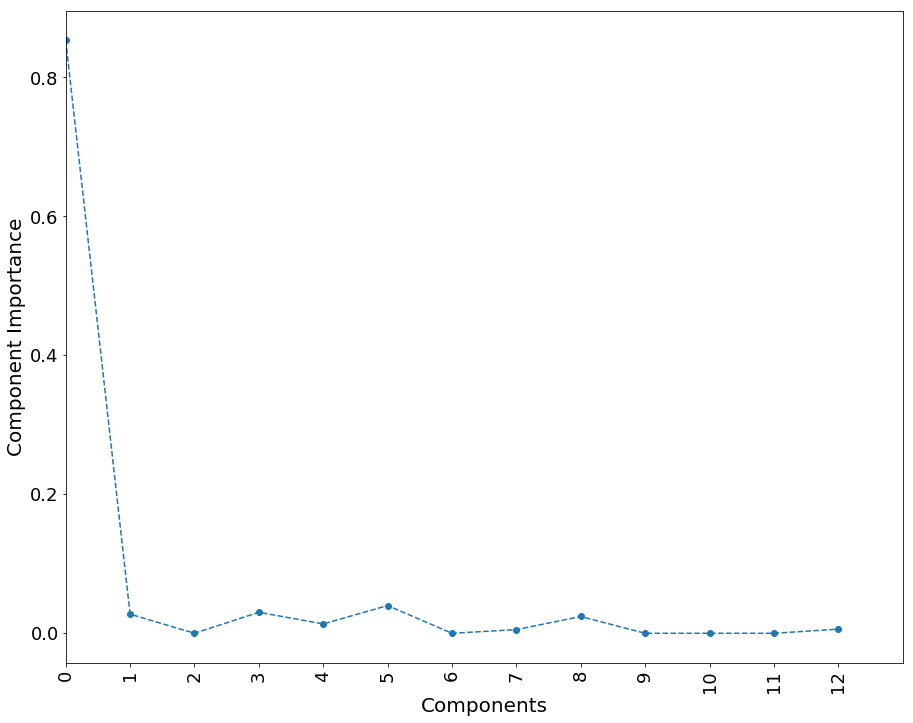

In [298]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [299]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse           0.05  exponential                15   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.2           150             0        0.5

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.809099153567

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3995   652     4647
1           611  1358     1969
__all__    4606  2010     6616

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.802297460701

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           965  177     1142
1           150  362      512
__all__    1115  539     1654

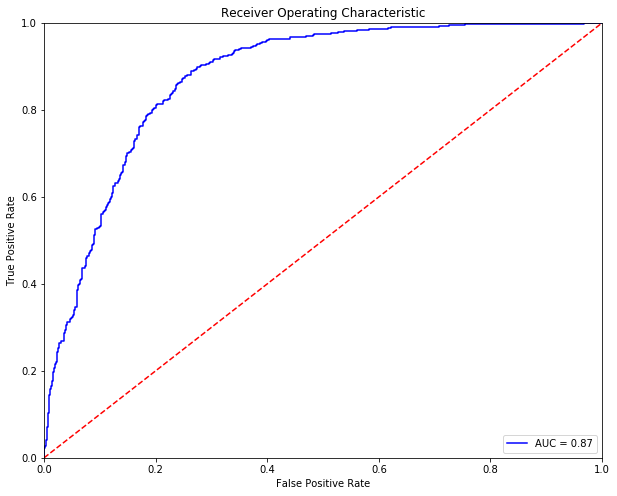

Optimal Threshold is 0.392783528232
Accuracy of Logistic Model on training data is: 0.803506650544


Predicted   0.0  1.0  __all__
Actual                       
0.0         918  224     1142
1.0         101  411      512
__all__    1019  635     1654

In [300]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [301]:
table_80_70_PCA_10_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_10_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

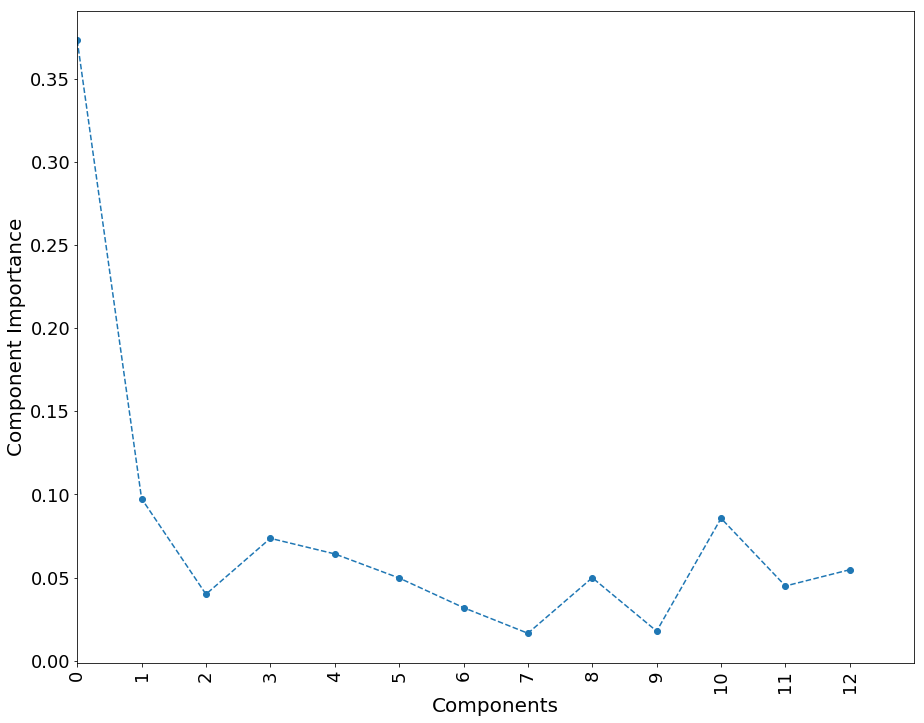

In [302]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [303]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0        entropy         20          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     5                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.799123337364

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4000   647     4647
1           682  1287     1969
__all__    4682  1934     6616

Accuracy of the  Extra Decision Tree  model for test data is: 0.772067714631

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           957  185     1142
1           192  320      512
__all__    1149  505     1654

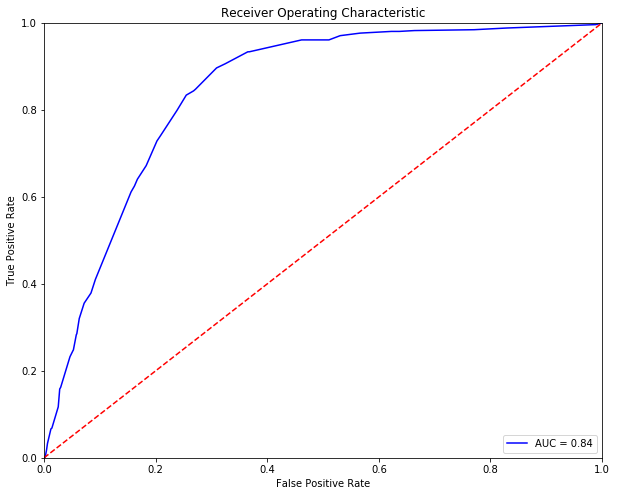

Optimal Threshold is 0.375415282392
Accuracy of Logistic Model on training data is: 0.77569528416


Predicted   0.0  1.0  __all__
Actual                       
0.0         904  238     1142
1.0         133  379      512
__all__    1037  617     1654

In [304]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [305]:
table_80_70_PCA_10_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [306]:
%%capture
table_80_70_PCA_10_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

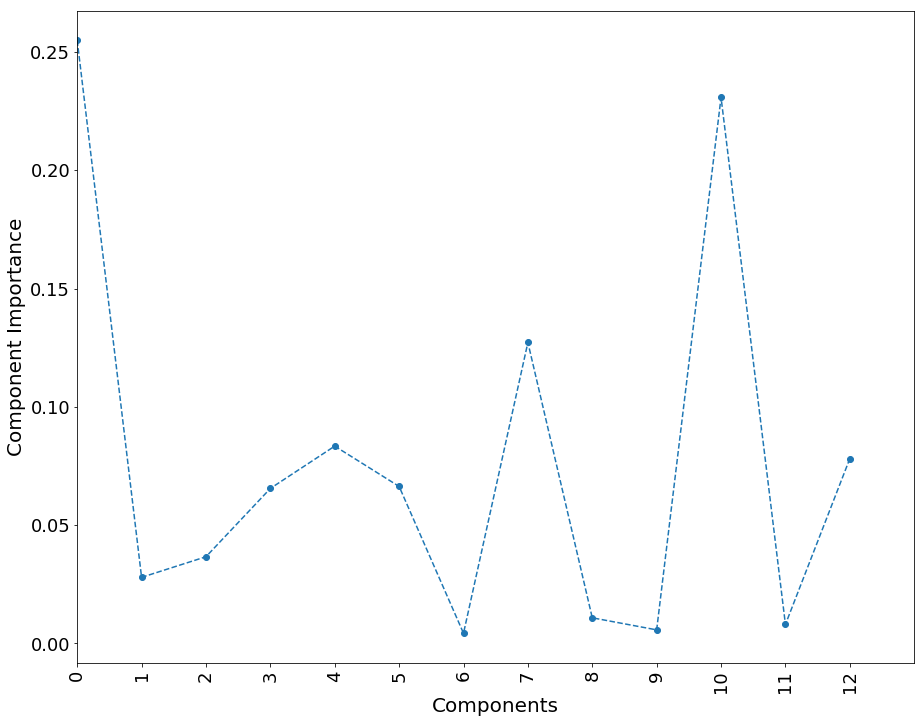

In [307]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [308]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.4          1500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.962363966143

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4614    33     4647
1           216  1753     1969
__all__    4830  1786     6616

Accuracy of the  Bagging  model for test data is: 0.798669891173

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           992  150     1142
1           183  329      512
__all__    1175  479     1654

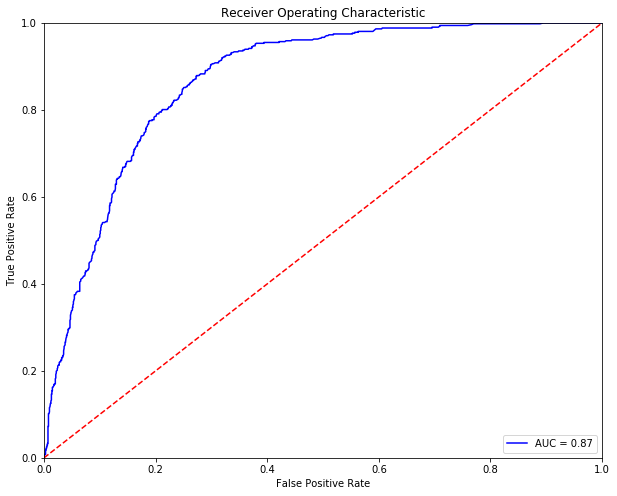

Optimal Threshold is 0.408
Accuracy of Logistic Model on training data is: 0.79322853688


Predicted   0.0  1.0  __all__
Actual                       
0.0         907  235     1142
1.0         107  405      512
__all__    1014  640     1654

In [309]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [310]:
table_80_70_PCA_10_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_10_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [311]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.942412333736


Predicted     0     1  __all__
Actual                        
0          4617    30     4647
1           351  1618     1969
__all__    4968  1648     6616

The test accuracy is: 0.787182587666


Predicted     0    1  __all__
Actual                       
0          1001  141     1142
1           211  301      512
__all__    1212  442     1654

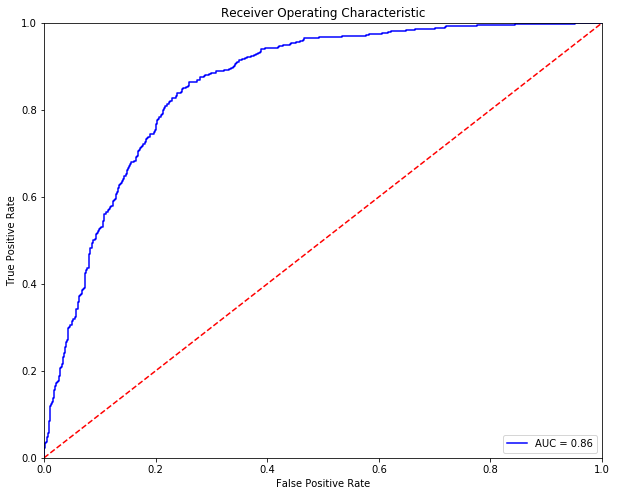

Optimal Threshold is 0.389356219128
Accuracy of Logistic Model on training data is: 0.78899637243


Predicted   0.0  1.0  __all__
Actual                       
0.0         902  240     1142
1.0         109  403      512
__all__    1011  643     1654

In [312]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [313]:
table_80_70_PCA_10_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_10_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [314]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.859280531971


Predicted     0     1  __all__
Actual                        
0          4213   434     4647
1           497  1472     1969
__all__    4710  1906     6616

The accuracy of the model on test data is: 0.781136638452


Predicted     0    1  __all__
Actual                       
0           957  185     1142
1           177  335      512
__all__    1134  520     1654

1504/1654 [==========================>...] - ETA: 0s

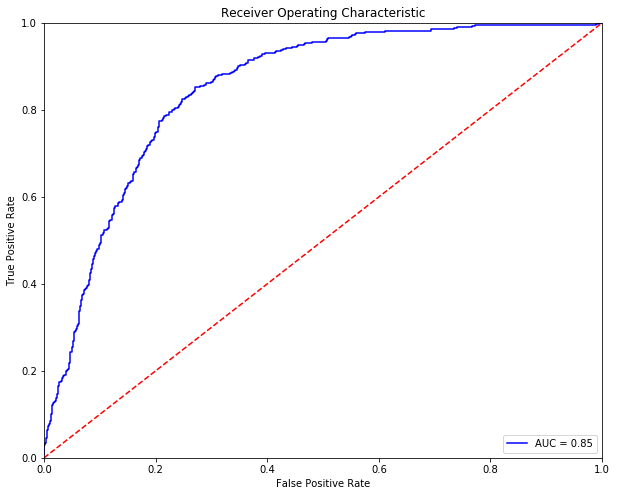

Optimal Threshold is 0.385542
Accuracy of Logistic Model on training data is: 0.784159613059


Predicted   0.0  1.0  __all__
Actual                       
0.0         896  246     1142
1.0         111  401      512
__all__    1007  647     1654

In [315]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [316]:
table_80_70_PCA_10_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_10_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [317]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  7.6min finished


The accuracy of the model on training data is: 0.810761789601


Predicted     0     1  __all__
Actual                        
0          3901   746     4647
1           506  1463     1969
__all__    4407  2209     6616

The accuracy of the model on test data is: 0.802902055623


Predicted     0    1  __all__
Actual                       
0           933  209     1142
1           117  395      512
__all__    1050  604     1654

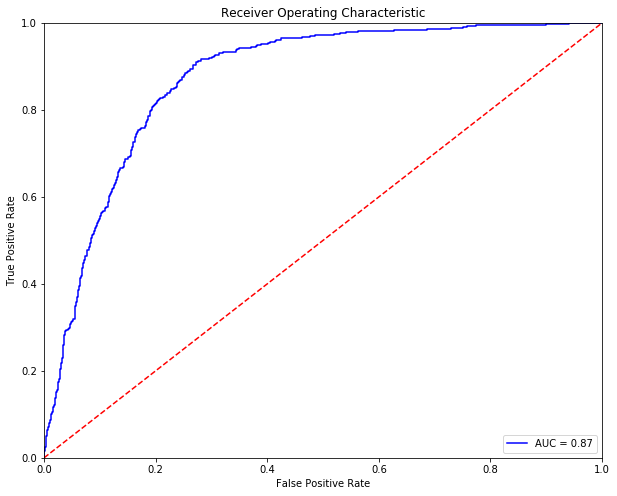

Optimal Threshold is 0.412112
Accuracy of Logistic Model on training data is: 0.80592503023


Predicted   0.0  1.0  __all__
Actual                       
0.0         921  221     1142
1.0         100  412      512
__all__    1021  633     1654

In [318]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [319]:
table_80_70_PCA_10_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_10_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [320]:
table_80_70_PCA_10_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_PCA_10_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_PCA_10_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_70_PCA_10_test.set_index(['index'],drop=True,inplace=True)
table_80_70_PCA_10_train.set_index(['index'],drop=True,inplace=True)
table_80_70_PCA_10_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_70_PCA_10_train)

print("Comparision Table for Test Accuracies:")
display(table_80_70_PCA_10_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_70_PCA_10_test_roc)

Comparision Table for Training Accuracies:


accuracy           TP           TN           FP  \
index                                                                         
KNeighborsClassifier        1.000000  1969.000000  4647.000000     0.000000   
LogisticRegression          0.797158  1494.000000  3780.000000   867.000000   
RandomForestClassifier      0.702388  3263.997733  1383.002267  1383.002267   
AdaBoostClassifier          0.795496  1446.000000  3817.000000   830.000000   
GradientBoostingClassifier  0.809099  1358.000000  3995.000000   652.000000   
ExtraTreeClassifier         0.799123  1287.000000  4000.000000   647.000000   
BaggingClassifier           0.962364  1753.000000  4614.000000    33.000000   
VotingClassifier            0.942412  1618.000000  4617.000000    30.000000   
Neural Network-1            0.859281  1472.000000  4213.000000   434.000000   
Neural-Network-2            0.810762  1463.000000  3901.000000   746.000000   

                                    FN       FPR       FNR  
index                                                       
KNeighborsClassifier          0.000000  0.000000  0.000000  
LogisticRegression          475.000000  0.186572  0.241239  
RandomForestClassifier      585.997733  0.702388  0.297612  
AdaBoostClassifier          523.000000  0.178610  0.265617  
GradientBoostingClassifier  611.000000  0.140306  0.310310  
ExtraTreeClassifier         682.000000  0.139230  0.346369  
BaggingClassifier           216.000000  0.007101  0.109700  
VotingClassifier            351.000000  0.006456  0.178263  
Neural Network-1            497.000000  0.093394  0.252412  
Neural-Network-2            506.000000  0.160534  0.256983

Comparision Table for Test Accuracies:


accuracy          TP           TN          FP  \
index                                                                       
KNeighborsClassifier        0.790206  301.000000  1006.000000  136.000000   
LogisticRegression          0.801693  406.000000   920.000000  222.000000   
RandomForestClassifier      0.690447  788.490931   353.509069  353.509069   
AdaBoostClassifier          0.801088  395.000000   930.000000  212.000000   
GradientBoostingClassifier  0.802297  362.000000   965.000000  177.000000   
ExtraTreeClassifier         0.772068  320.000000   957.000000  185.000000   
BaggingClassifier           0.798670  329.000000   992.000000  150.000000   
VotingClassifier            0.787183  301.000000  1001.000000  141.000000   
Neural Network-1            0.781137  335.000000   957.000000  185.000000   
Neural-Network-2            0.802902  395.000000   933.000000  209.000000   

                                    FN       FPR       FNR  
index                                                       
KNeighborsClassifier        211.000000  0.119089  0.412109  
LogisticRegression          106.000000  0.194396  0.207031  
RandomForestClassifier      158.490931  0.690447  0.309553  
AdaBoostClassifier          117.000000  0.185639  0.228516  
GradientBoostingClassifier  150.000000  0.154991  0.292969  
ExtraTreeClassifier         192.000000  0.161996  0.375000  
BaggingClassifier           183.000000  0.131349  0.357422  
VotingClassifier            211.000000  0.123468  0.412109  
Neural Network-1            177.000000  0.161996  0.345703  
Neural-Network-2            117.000000  0.183012  0.228516

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.793833  406.0  907.0  235.0  106.0  0.205779   
LogisticRegression          0.804716  412.0  919.0  223.0  100.0  0.195271   
RandomForestClassifier      0.802297  409.0  918.0  224.0  103.0  0.196147   
AdaBoostClassifier          0.798065  408.0  912.0  230.0  104.0  0.201401   
GradientBoostingClassifier  0.803507  411.0  918.0  224.0  101.0  0.196147   
ExtraTreeClassifier         0.775695  379.0  904.0  238.0  133.0  0.208406   
BaggingClassifier           0.793229  405.0  907.0  235.0  107.0  0.205779   
VotingClassifier            0.788996  403.0  902.0  240.0  109.0  0.210158   
Neural Network-1            0.784160  401.0  896.0  246.0  111.0  0.215412   
Neural-Network-2            0.805925  412.0  921.0  221.0  100.0  0.193520   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.207031   0.307780  0.865204  
LogisticRegression          0.195312   0.496068  0.876360  
RandomForestClassifier      0.201172   0.313273  0.833553  
AdaBoostClassifier          0.203125   0.478783  0.870250  
GradientBoostingClassifier  0.197266   0.392784  0.874584  
ExtraTreeClassifier         0.259766   0.375415  0.843513  
BaggingClassifier           0.208984   0.408000  0.867567  
VotingClassifier            0.212891   0.389356  0.859939  
Neural Network-1            0.216797   0.385542  0.848626  
Neural-Network-2            0.195312   0.412112  0.872789

#### Random State 20

In [321]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_20.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())

X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.2)

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   651   35.807988   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  4059  321.478197   

                                                           PAS         LEN  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   35.328725  108.442396   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  131.395910   73.695245   

                                                             BYS  \
Source_User                                                        
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   3976.233487   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  31586.025868   

                                                              BYR      SP  \
Source_User                                                                 
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   37072.858679   639.0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  413326.700419  3627.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   8.0    21   23  158   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  18.0    40   31  974   

                                                            TDIF  0000  0100  \
Source_User                                                                    
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...  11131.820276     6     0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   1803.300813   196   310   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     2     0     0     0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   532   308   202   101   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     0    13     8    34   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...    45   281    95    38   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    95    39    76    71   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...    93    95   206   102   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    74    66   114    27   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   104    84   194   144   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    14     0     0     7   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   116   161   158   138   

                                                    2200  2300  
Source_User                                                     
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     3     2  
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   159   197

1 -> Infected
0 -> Uninfected


Source_User
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d641329bc603046dfcc4    0
307c636564c5ec9897e5062605e2982daf781f0f82b0234f2cbc55919f8d04e2    0
11e8b7b973c885d9d2560baeec4673bc6b13aab08d9e49bc9c519727595e4d3e    1
41851f48304067368da8f12794e2f539330cc7ef6732c1440ed4c5eb06b9cc5d    0
08402d90e55ea64677880c21fc3850422ad2e08f730282d271027f0fea60b4b6    1
952aed50327c6ac4e19a033bb585959b33ea2ca897f985dc33a1bb6a1f3d7cc7    0
6b42f8e7f92d2fccc0fae12167ef5e929f394e87e9c70bb36ac160bf6d6cb0f4    0
c9140a85217daf0d18148d489fa6d3293cbe499584b12e28be0e381a20eeb737    1
647e8a6690cd21f7bae287782ec6a621cae3a5ba6f37b779d99f28a7851b1bfc    0
42d06643547a80b9343fa1a09ca32b0c3bb84caa31bfb45c629b6835072e364b    0
Name: Target, dtype: int64

Variance explained using 13 components is: 0.920535156414
The train/test split ratio is 80:20


In [322]:
display(X_pca_13[0:1])

array([[-0.5327557 , -0.05293468,  0.17489689, -0.0108528 ,  0.30105805,
         0.0389905 ,  0.13583015, -0.32384755,  0.65499101, -0.0822117 ,
         0.18802012,  0.15884271,  0.03627151]])

In [323]:
## Table to store training and test measures
table_80_70_PCA_20_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_PCA_20_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_PCA_20_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [324]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  manhattan           30  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4632     0     4632
1             0  1984     1984
__all__    4632  1984     6616

Accuracy of the  KNN  model for test data is: 0.799274486094

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1037  120     1157
1           212  285      497
__all__    1249  405     1654

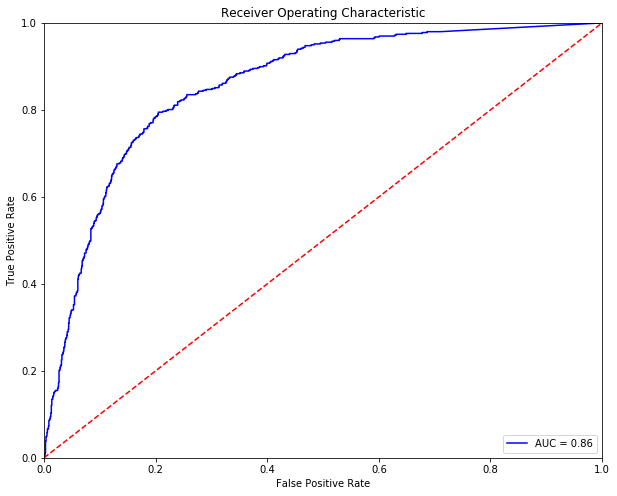

Optimal Threshold is 0.303673932814
Accuracy of Logistic Model on training data is: 0.794437726723


Predicted   0.0  1.0  __all__
Actual                       
0.0         920  237     1157
1.0         103  394      497
__all__    1023  631     1654

In [325]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [326]:
table_80_70_PCA_20_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_20_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [327]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False          False                0.5        50  multinomial   

             6          7      8  
index  penalty     solver    tol  
0           l2  newton-cg  1e-05

Accuracy of the  Logistic  model for the training data is: 0.800483675937

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3798   834     4632
1           486  1498     1984
__all__    4284  2332     6616

Accuracy of the  Logistic  model for test data is: 0.81015719468

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           957  200     1157
1           114  383      497
__all__    1071  583     1654

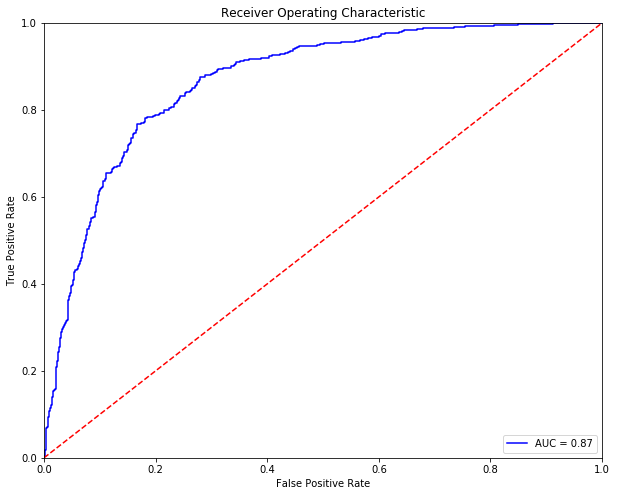

Optimal Threshold is 0.474446487422
Accuracy of Logistic Model on training data is: 0.792019347037


Predicted   0.0  1.0  __all__
Actual                       
0.0         917  240     1157
1.0         104  393      497
__all__    1021  633     1654

In [328]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [329]:
table_80_70_PCA_20_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_20_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [330]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[2000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1          2000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.700120918984

Confusion Matrix for Training data is:


Predicted     0  1  __all__
Actual                     
0          4632  0     4632
1          1984  0     1984
__all__    6616  0     6616

Accuracy of the  Random Forest Trees  model for test data is: 0.699516324063

Confusion Matrix for test data is:


Predicted     0  1  __all__
Actual                     
0          1157  0     1157
1           497  0      497
__all__    1654  0     1654

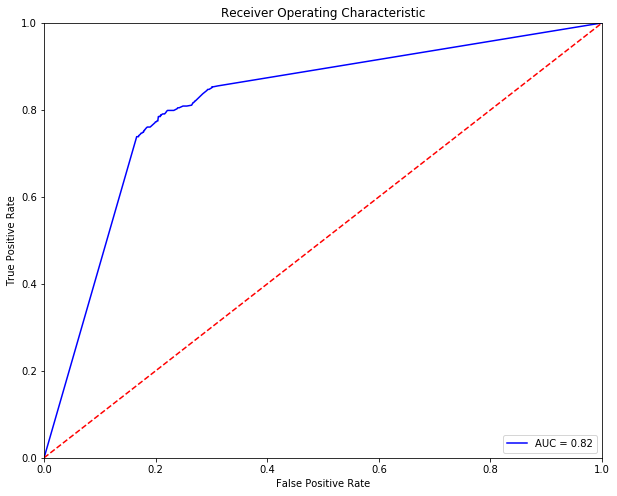

Optimal Threshold is 0.29931878823
Accuracy of Logistic Model on training data is: 0.790205562273


Predicted   0.0  1.0  __all__
Actual                       
0.0         915  242     1157
1.0         105  392      497
__all__    1020  634     1654

In [331]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [332]:
table_80_70_PCA_20_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_20_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

4632
0
0
4632
1984
0
0
1984
1.0
0.0
0.0
1.0
1157
0
0
1157
497
0
0
497
1.0
0.0
0.0
1.0


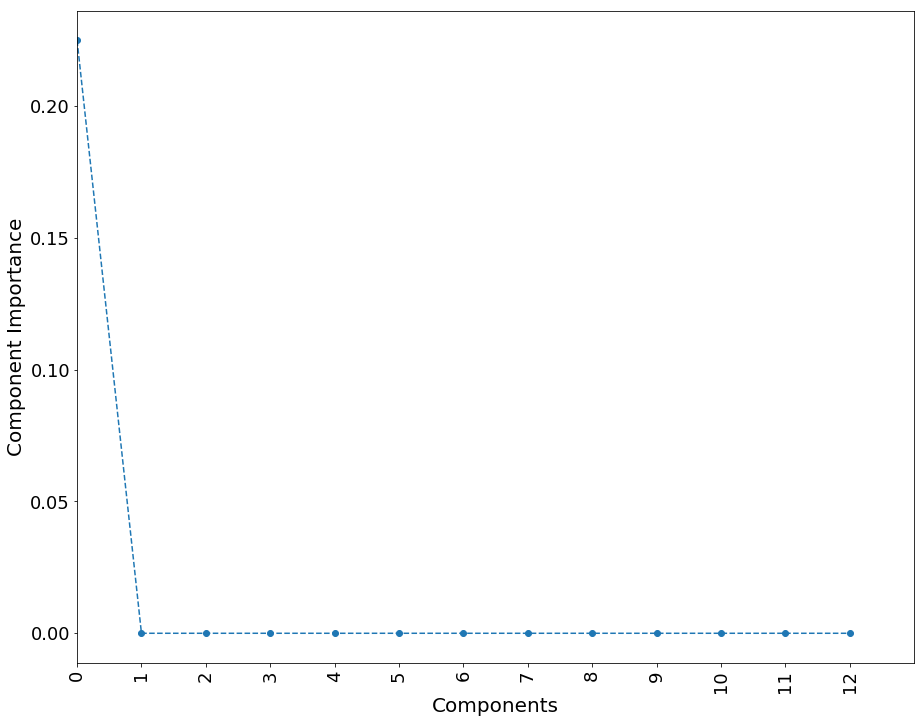

In [333]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [334]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME            1.5            50             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.809552599758

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4028   604     4632
1           656  1328     1984
__all__    4684  1932     6616

Accuracy of the  AdaBoostClassifier  model for test data is: 0.802902055623

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           996  161     1157
1           165  332      497
__all__    1161  493     1654

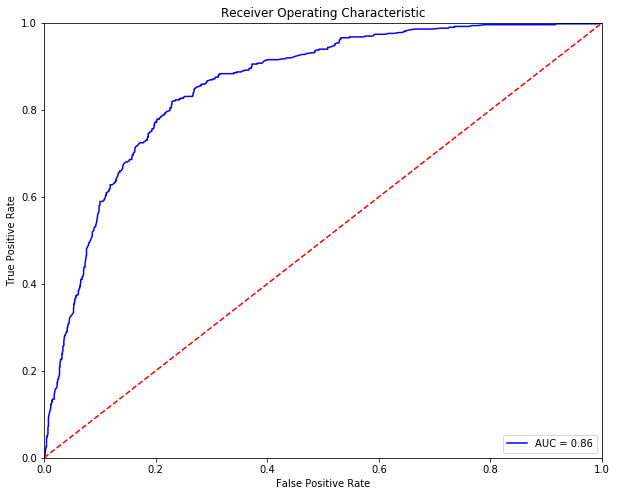

Optimal Threshold is 0.49014365763
Accuracy of Logistic Model on training data is: 0.787787182588


Predicted   0.0  1.0  __all__
Actual                       
0.0         912  245     1157
1.0         106  391      497
__all__    1018  636     1654

In [335]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [336]:
table_80_70_PCA_20_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_20_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

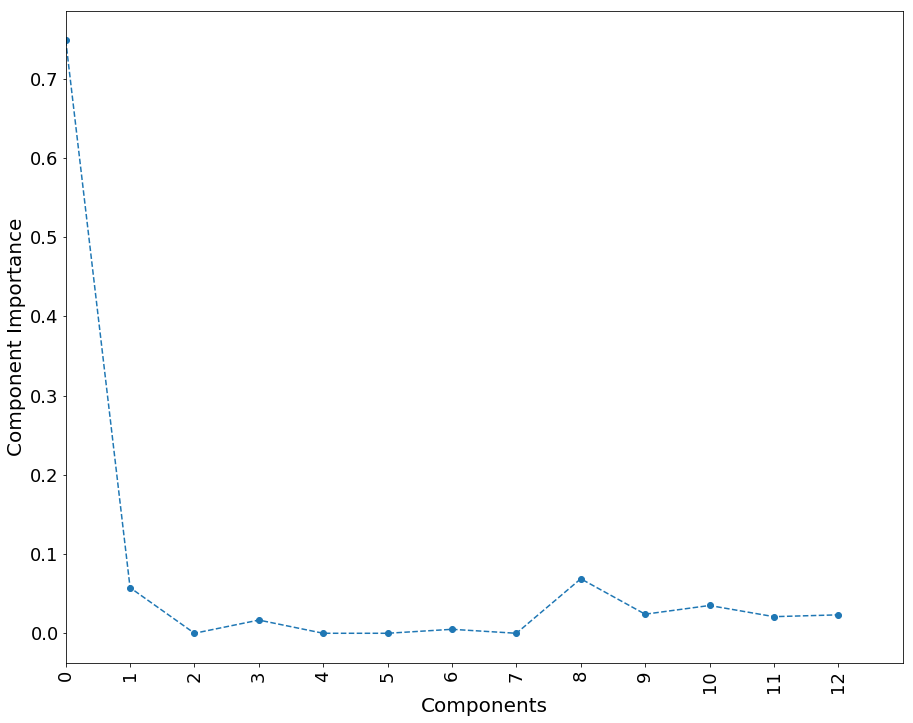

In [337]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [338]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse           0.05  exponential                20   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.2           150             0        0.7

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.815145102781

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3993   639     4632
1           584  1400     1984
__all__    4577  2039     6616

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.814993954051

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           998  159     1157
1           147  350      497
__all__    1145  509     1654

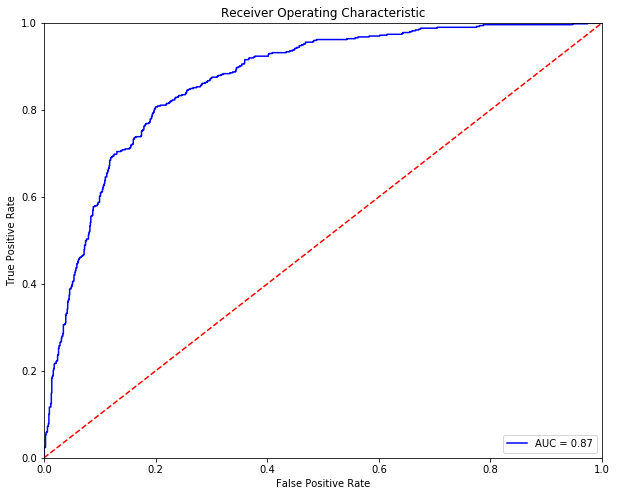

Optimal Threshold is 0.392399560601
Accuracy of Logistic Model on training data is: 0.80169286578


Predicted   0.0  1.0  __all__
Actual                       
0.0         928  229     1157
1.0          99  398      497
__all__    1027  627     1654

In [339]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [340]:
table_80_70_PCA_20_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_20_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

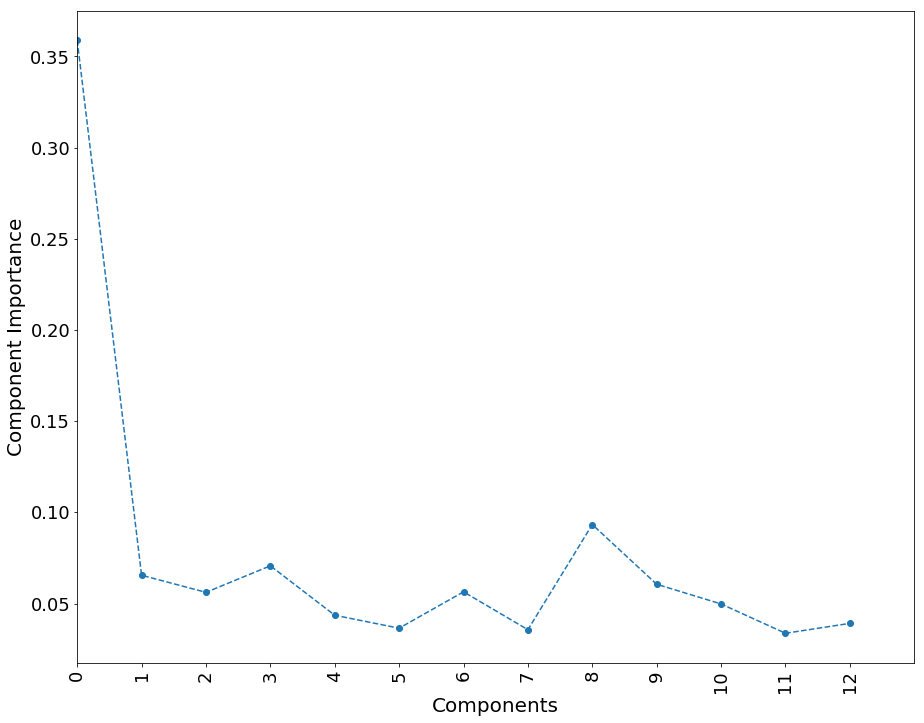

In [341]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [342]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0        entropy         20          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     3                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.803960096735

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3880   752     4632
1           545  1439     1984
__all__    4425  2191     6616

Accuracy of the  Extra Decision Tree  model for test data is: 0.781741233374

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           956  201     1157
1           160  337      497
__all__    1116  538     1654

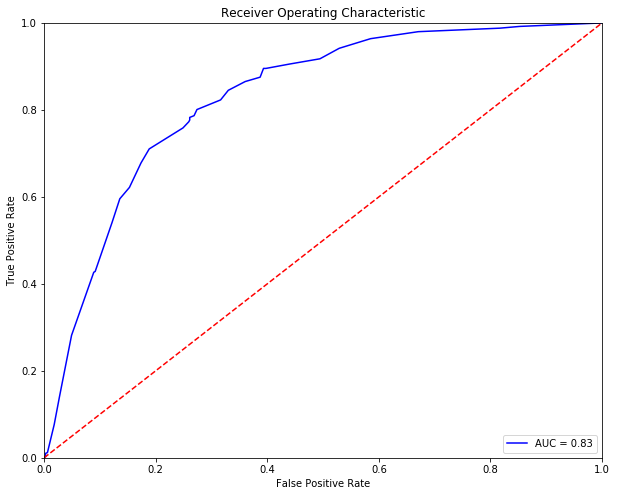

Optimal Threshold is 0.413173652695
Accuracy of Logistic Model on training data is: 0.781136638452


Predicted   0.0  1.0  __all__
Actual                       
0.0         939  218     1157
1.0         144  353      497
__all__    1083  571     1654

In [343]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [344]:
table_80_70_PCA_20_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [345]:
%%capture
table_80_70_PCA_20_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

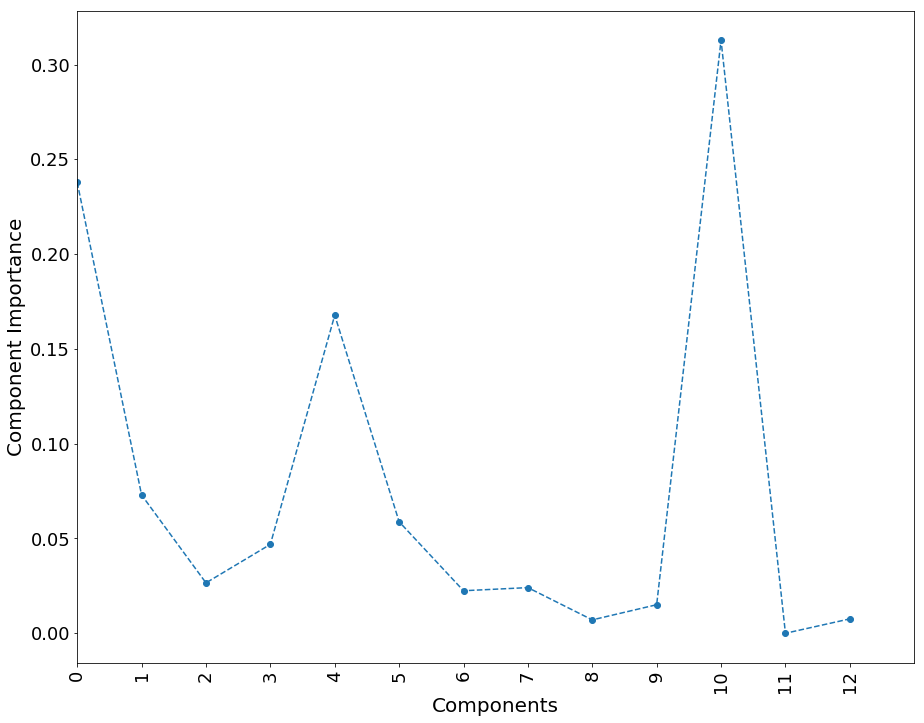

In [346]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [347]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.3          1000   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.935912938331

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4527   105     4632
1           319  1665     1984
__all__    4846  1770     6616

Accuracy of the  Bagging  model for test data is: 0.804111245466

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1005  152     1157
1           172  325      497
__all__    1177  477     1654

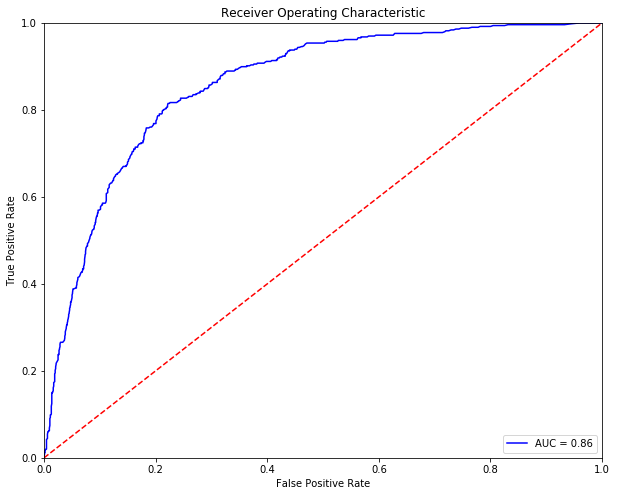

Optimal Threshold is 0.398
Accuracy of Logistic Model on training data is: 0.792623941959


Predicted   0.0  1.0  __all__
Actual                       
0.0         918  239     1157
1.0         104  393      497
__all__    1022  632     1654

In [348]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [349]:
table_80_70_PCA_20_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_20_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [350]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.947097944377


Predicted     0     1  __all__
Actual                        
0          4602    30     4632
1           320  1664     1984
__all__    4922  1694     6616

The test accuracy is: 0.805320435308


Predicted     0    1  __all__
Actual                       
0          1031  126     1157
1           196  301      497
__all__    1227  427     1654

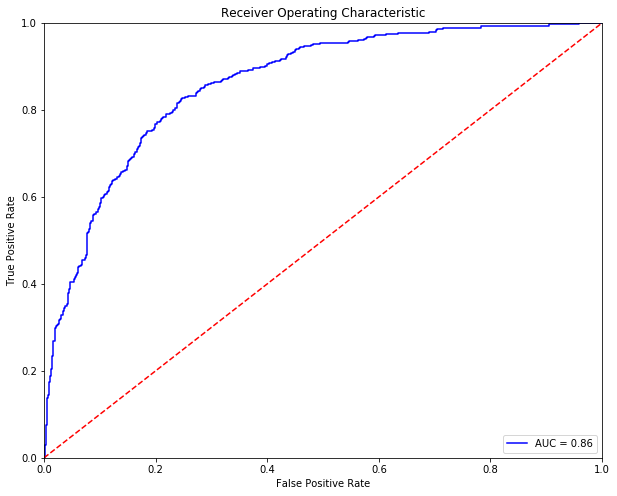

Optimal Threshold is 0.368187828863
Accuracy of Logistic Model on training data is: 0.783555018138


Predicted   0.0  1.0  __all__
Actual                       
0.0         907  250     1157
1.0         108  389      497
__all__    1015  639     1654

In [351]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [352]:
table_80_70_PCA_20_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_20_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [353]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.854746070061


Predicted     0     1  __all__
Actual                        
0          4248   384     4632
1           577  1407     1984
__all__    4825  1791     6616

The accuracy of the model on test data is: 0.79322853688


Predicted     0    1  __all__
Actual                       
0           996  161     1157
1           181  316      497
__all__    1177  477     1654

1088/1654 [==================>...........] - ETA: 0s

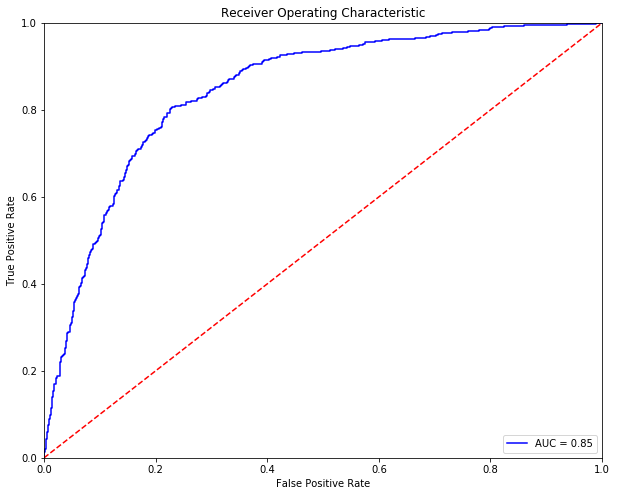

Optimal Threshold is 0.340277
Accuracy of Logistic Model on training data is: 0.784764207981


Predicted   0.0  1.0  __all__
Actual                       
0.0         909  248     1157
1.0         108  389      497
__all__    1017  637     1654

In [354]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [355]:
table_80_70_PCA_20_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_20_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [356]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  8.1min finished


The accuracy of the model on training data is: 0.811970979444


Predicted     0     1  __all__
Actual                        
0          3950   682     4632
1           562  1422     1984
__all__    4512  2104     6616

The accuracy of the model on test data is: 0.806529625151


Predicted     0    1  __all__
Actual                       
0           982  175     1157
1           145  352      497
__all__    1127  527     1654

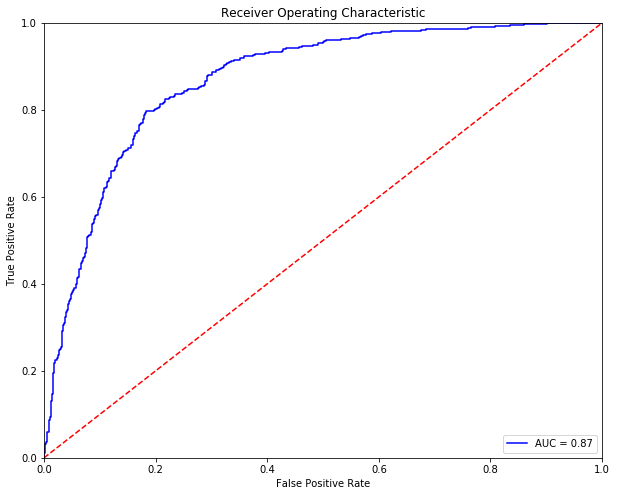

Optimal Threshold is 0.284348
Accuracy of Logistic Model on training data is: 0.80169286578


Predicted   0.0  1.0  __all__
Actual                       
0.0         928  229     1157
1.0          99  398      497
__all__    1027  627     1654

In [357]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [358]:
table_80_70_PCA_20_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_20_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [359]:
table_80_70_PCA_20_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_PCA_20_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_PCA_20_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_70_PCA_20_test.set_index(['index'],drop=True,inplace=True)
table_80_70_PCA_20_train.set_index(['index'],drop=True,inplace=True)
table_80_70_PCA_20_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_70_PCA_20_train)

print("Comparision Table for Test Accuracies:")
display(table_80_70_PCA_20_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_70_PCA_20_test_roc)

Comparision Table for Training Accuracies:


accuracy           TP           TN           FP  \
index                                                                         
KNeighborsClassifier        1.000000  1984.000000  4632.000000     0.000000   
LogisticRegression          0.800484  1498.000000  3798.000000   834.000000   
RandomForestClassifier      0.700121  3242.960097  1389.039903  1389.039903   
AdaBoostClassifier          0.809553  1328.000000  4028.000000   604.000000   
GradientBoostingClassifier  0.815145  1400.000000  3993.000000   639.000000   
ExtraTreeClassifier         0.803960  1439.000000  3880.000000   752.000000   
BaggingClassifier           0.935913  1665.000000  4527.000000   105.000000   
VotingClassifier            0.947098  1664.000000  4602.000000    30.000000   
Neural Network-1            0.854746  1407.000000  4248.000000   384.000000   
Neural-Network-2            0.811971  1422.000000  3950.000000   682.000000   

                                    FN       FPR       FNR  
index                                                       
KNeighborsClassifier          0.000000  0.000000  0.000000  
LogisticRegression          486.000000  0.180052  0.244960  
RandomForestClassifier      594.960097  0.700121  0.299879  
AdaBoostClassifier          656.000000  0.130397  0.330645  
GradientBoostingClassifier  584.000000  0.137953  0.294355  
ExtraTreeClassifier         545.000000  0.162349  0.274698  
BaggingClassifier           319.000000  0.022668  0.160786  
VotingClassifier            320.000000  0.006477  0.161290  
Neural Network-1            577.000000  0.082902  0.290827  
Neural-Network-2            562.000000  0.147237  0.283266

Comparision Table for Test Accuracies:


accuracy          TP           TN          FP  \
index                                                                       
KNeighborsClassifier        0.799274  285.000000  1037.000000  120.000000   
LogisticRegression          0.810157  383.000000   957.000000  200.000000   
RandomForestClassifier      0.699516  809.340387   347.659613  347.659613   
AdaBoostClassifier          0.802902  332.000000   996.000000  161.000000   
GradientBoostingClassifier  0.814994  350.000000   998.000000  159.000000   
ExtraTreeClassifier         0.781741  337.000000   956.000000  201.000000   
BaggingClassifier           0.804111  325.000000  1005.000000  152.000000   
VotingClassifier            0.805320  301.000000  1031.000000  126.000000   
Neural Network-1            0.793229  316.000000   996.000000  161.000000   
Neural-Network-2            0.806530  352.000000   982.000000  175.000000   

                                    FN       FPR       FNR  
index                                                       
KNeighborsClassifier        212.000000  0.103717  0.426559  
LogisticRegression          114.000000  0.172861  0.229376  
RandomForestClassifier      149.340387  0.699516  0.300484  
AdaBoostClassifier          165.000000  0.139153  0.331992  
GradientBoostingClassifier  147.000000  0.137424  0.295775  
ExtraTreeClassifier         160.000000  0.173725  0.321932  
BaggingClassifier           172.000000  0.131374  0.346076  
VotingClassifier            196.000000  0.108902  0.394366  
Neural Network-1            181.000000  0.139153  0.364185  
Neural-Network-2            145.000000  0.151253  0.291751

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.794438  394.0  920.0  237.0  103.0  0.204840   
LogisticRegression          0.792019  393.0  917.0  240.0  104.0  0.207433   
RandomForestClassifier      0.790206  392.0  915.0  242.0  105.0  0.209162   
AdaBoostClassifier          0.787787  391.0  912.0  245.0  106.0  0.211755   
GradientBoostingClassifier  0.801693  398.0  928.0  229.0   99.0  0.197926   
ExtraTreeClassifier         0.781137  353.0  939.0  218.0  144.0  0.188418   
BaggingClassifier           0.792624  393.0  918.0  239.0  104.0  0.206569   
VotingClassifier            0.783555  389.0  907.0  250.0  108.0  0.216076   
Neural Network-1            0.784764  389.0  909.0  248.0  108.0  0.214347   
Neural-Network-2            0.801693  398.0  928.0  229.0   99.0  0.197926   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.207243   0.303674  0.856059  
LogisticRegression          0.209256   0.474446  0.868021  
RandomForestClassifier      0.211268   0.299319  0.816551  
AdaBoostClassifier          0.213280   0.490144  0.856976  
GradientBoostingClassifier  0.199195   0.392400  0.868843  
ExtraTreeClassifier         0.289738   0.413174  0.828931  
BaggingClassifier           0.209256   0.398000  0.859092  
VotingClassifier            0.217304   0.368188  0.860652  
Neural Network-1            0.217304   0.340277  0.846192  
Neural-Network-2            0.199195   0.284348  0.868742

### <a id='1.D' style="text-decoration : none; color : #000000;">D. 70:30 Train Test split with PCA </a>

#### Random State 0

In [360]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_0.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())

X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.3)

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC        PAR  \
Source_User                                                           
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  4607  77.507923   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   169   5.840237   

                                                          PAS         LEN  \
Source_User                                                                 
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  40.245713  100.283265   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   5.597633  149.763314   

                                                            BYS           BYR  \
Source_User                                                                     
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  6930.568483  89947.788800   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...  1016.976331   3222.147929   

                                                        SP     DP  NAPP  SIP  \
Source_User                                                                    
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  3901.0  113.0    58   86   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   168.0    4.0     9   11   

                                                     DIP          TDIF  0000  \
Source_User                                                                    
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  1116   1646.597569   167   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...    16  40005.674556     0   

                                                    0100  0200  0300  0400  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   295   328   198   223   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0     0   

                                                    0500  0600  0700  0800  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   135   144   145   194   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0     8   

                                                    0900  1000  1100  1200  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   197   196   178   120   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     8     0     0    39   

                                                    1300  1400  1500  1600  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   145   118   224   172   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...    48    40    10     4   

                                                    1700  1800  1900  2000  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   241   246   151   165   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     4     2     6     0   

                                                    2100  2200  2300  
Source_User                                                           
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   177   134   314  
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0

1 -> Infected
0 -> Uninfected


Source_User
bb98d45a9bd0c40362a3ec37503c10b8238194752d355742cd3ea35221dc98b1    1
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e215137c4ad8c46fc5    0
56a003f863f8cc9342216fa01a3ab0aebf4a04ed0dd8d5b89a95f779cc707dd5    1
f894aec69ce612e29505d6d3cd9112bbe39d6a46e7da2682d14a1cbd9c4cd297    0
9aadb359b9763e3d68e62ad3c406245fcf0bc4919395dbf42532e49d8b5aa02d    1
dbea3804991397c518e0198f2b63ecab35cbf38083cb5e19bb9d4b4f4bacaa2d    1
f2327a8577d940bf7100353fce41bbde184c6e4ead193ab60986bb3ef2551718    1
d815eb7ef3af2a56e8260b0b3a6bb3c1bf70c625619caa930cff27beced41ea1    1
ae3fe786080d0c4a0d3520152bb59d60836d2ae6fdb4870a1879b98ea7ec02fc    1
45b5cf89d8e8ff70ce05570a97d5ff05783283281eade7d8b736c94a24cfb16c    1
Name: Target, dtype: int64

Variance explained using 13 components is: 0.922348229056
The train/test split ratio is 70:30


In [361]:
display(X_pca_13[0:1])

array([[ 0.51069587, -0.17479937, -0.18757661, -0.21230661, -0.83309263,
         0.55899882,  0.157608  , -0.1043382 ,  0.82023985, -0.32529949,
         0.30768313, -0.3310058 , -1.04421636]])

In [362]:
## Table to store training and test measures
table_70_70_PCA_0_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_PCA_0_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_PCA_0_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [363]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  euclidean           30  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4078     0     4078
1             0  1711     1711
__all__    4078  1711     5789

Accuracy of the  KNN  model for test data is: 0.7843611447

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1537  174     1711
1           361  409      770
__all__    1898  583     2481

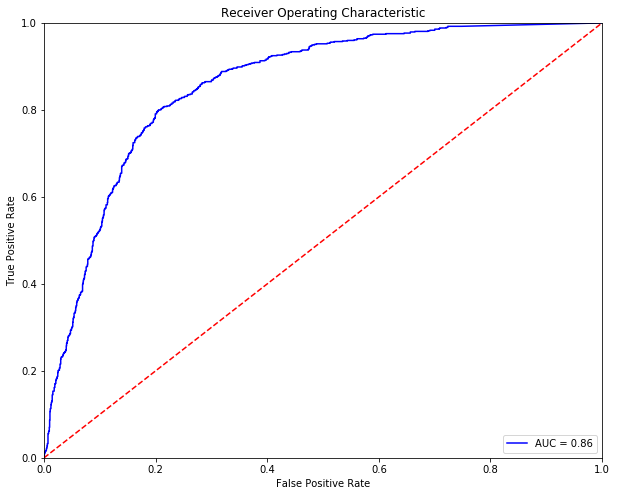

Optimal Threshold is 0.269483786617
Accuracy of Logistic Model on training data is: 0.796453043128


Predicted   0.0  1.0  __all__
Actual                       
0.0        1363  348     1711
1.0         157  613      770
__all__    1520  961     2481

In [364]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [365]:
table_70_70_PCA_0_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_0_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [366]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.7  False           True                0.5        50  multinomial   

             6          7      8  
index  penalty     solver    tol  
0           l2  newton-cg  1e-05

Accuracy of the  Logistic  model for the training data is: 0.798410779064

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3637   441     4078
1           726   985     1711
__all__    4363  1426     5789

Accuracy of the  Logistic  model for test data is: 0.792422410318

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1529  182     1711
1           333  437      770
__all__    1862  619     2481

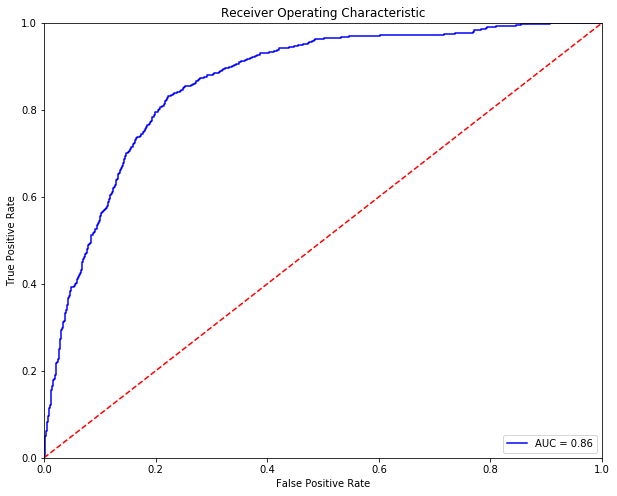

Optimal Threshold is 0.395164569432
Accuracy of Logistic Model on training data is: 0.796453043128


Predicted   0.0  1.0  __all__
Actual                       
0.0        1363  348     1711
1.0         157  613      770
__all__    1520  961     2481

In [367]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [368]:
table_70_70_PCA_0_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_0_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [369]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[2000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1          2000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.704439454137

Confusion Matrix for Training data is:


Predicted     0  1  __all__
Actual                     
0          4078  0     4078
1          1711  0     1711
__all__    5789  0     5789

Accuracy of the  Random Forest Trees  model for test data is: 0.68964127368

Confusion Matrix for test data is:


Predicted     0  1  __all__
Actual                     
0          1711  0     1711
1           770  0      770
__all__    2481  0     2481

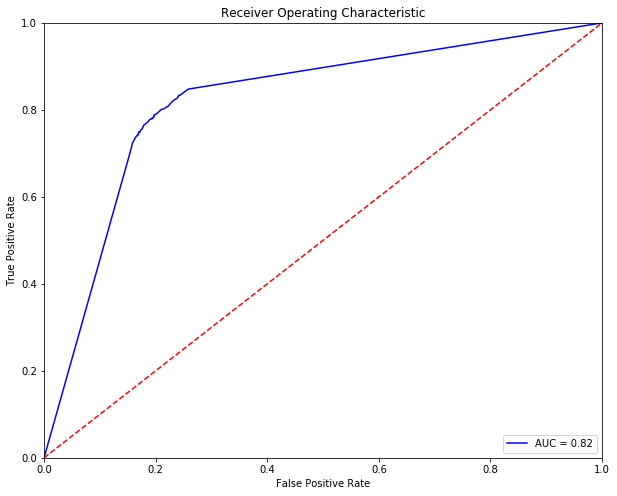

Optimal Threshold is 0.26036545095
Accuracy of Logistic Model on training data is: 0.797662232971


Predicted   0.0  1.0  __all__
Actual                       
0.0        1372  339     1711
1.0         163  607      770
__all__    1535  946     2481

In [370]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [371]:
table_70_70_PCA_0_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_0_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

4078
0
0
4078
1711
0
0
1711
1.0
0.0
0.0
1.0
1711
0
0
1711
770
0
0
770
1.0
0.0
0.0
1.0


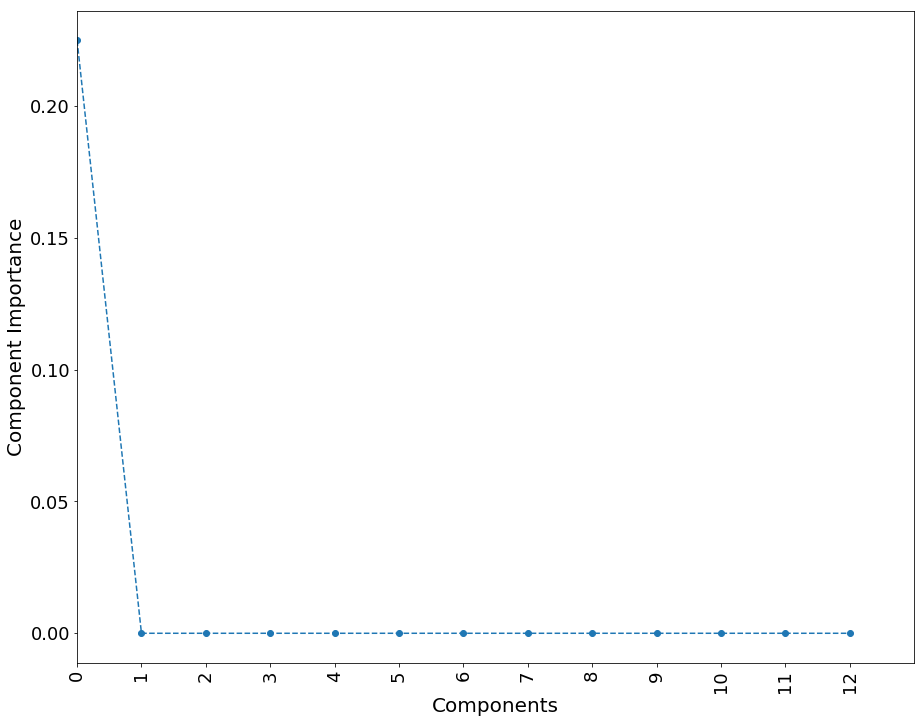

In [372]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [373]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME            0.5           400             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.809120746243

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3448   630     4078
1           475  1236     1711
__all__    3923  1866     5789

Accuracy of the  AdaBoostClassifier  model for test data is: 0.80612656187

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1450  261     1711
1           220  550      770
__all__    1670  811     2481

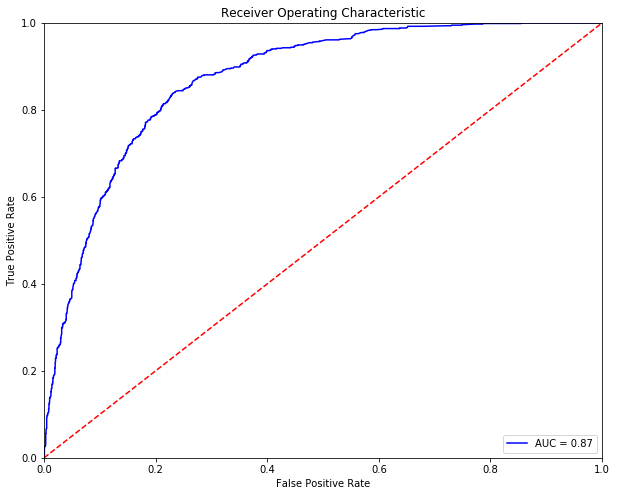

Optimal Threshold is 0.476123654157
Accuracy of Logistic Model on training data is: 0.795243853285


Predicted   0.0  1.0  __all__
Actual                       
0.0        1361  350     1711
1.0         158  612      770
__all__    1519  962     2481

In [374]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [375]:
table_70_70_PCA_0_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_0_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

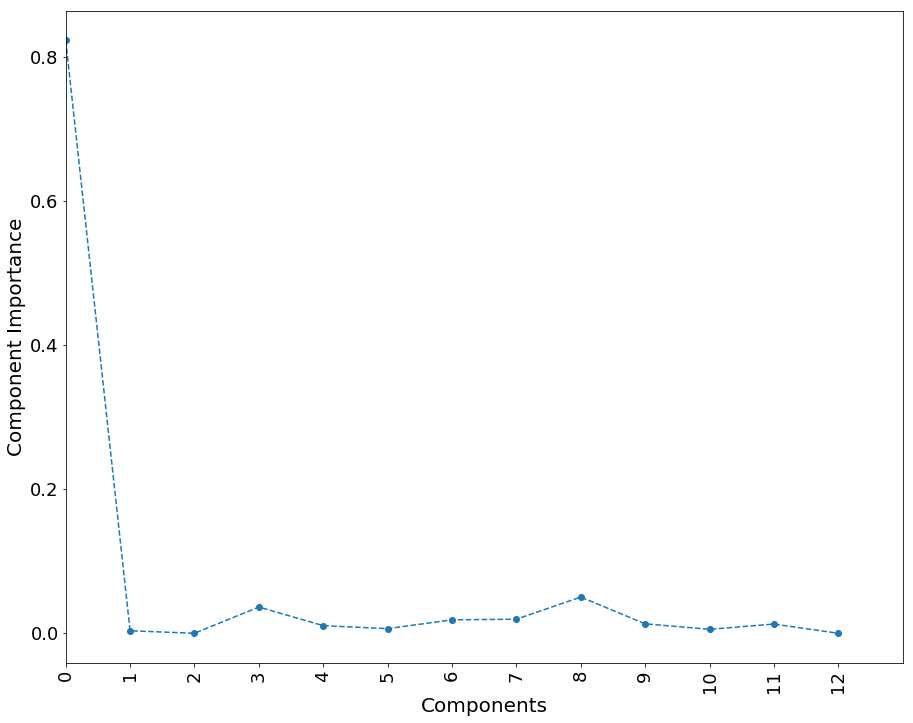

In [376]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [377]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1         2                 3  \
index  criterion  learning_rate      loss  min_samples_leaf   
0            mse           0.05  deviance                10   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1            50             0        0.7

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.811366384522

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3555   523     4078
1           569  1142     1711
__all__    4124  1665     5789

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.808141878275

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1496  215     1711
1           261  509      770
__all__    1757  724     2481

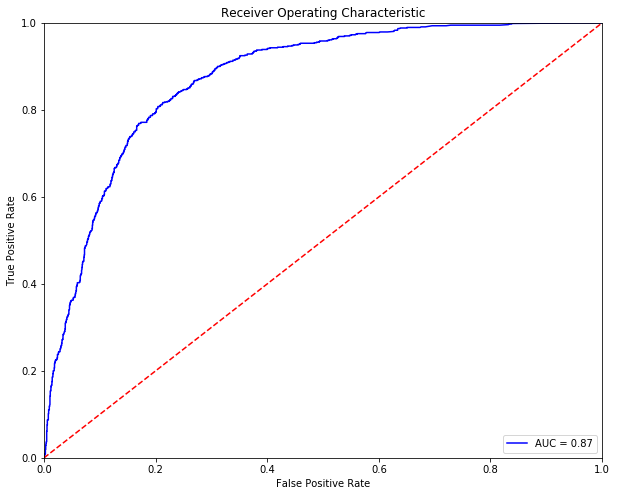

Optimal Threshold is 0.359216112197
Accuracy of Logistic Model on training data is: 0.798468359532


Predicted   0.0  1.0  __all__
Actual                       
0.0        1368  343     1711
1.0         157  613      770
__all__    1525  956     2481

In [378]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [379]:
table_70_70_PCA_0_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_0_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

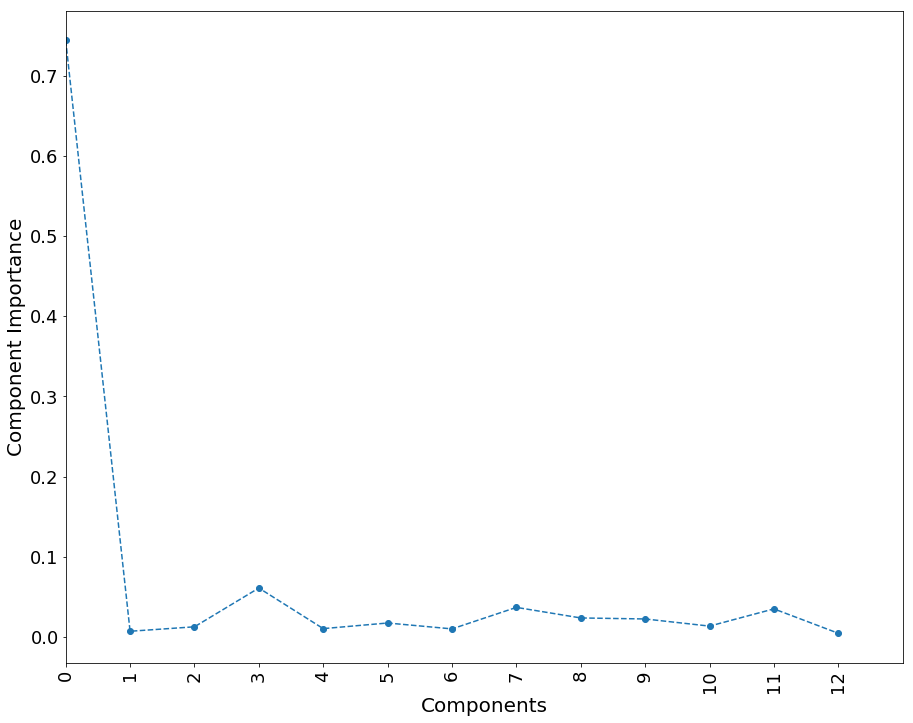

In [380]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [381]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0        entropy         20          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.808948004837

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3470   608     4078
1           498  1213     1711
__all__    3968  1821     5789

Accuracy of the  Extra Decision Tree  model for test data is: 0.800886739218

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1462  249     1711
1           245  525      770
__all__    1707  774     2481

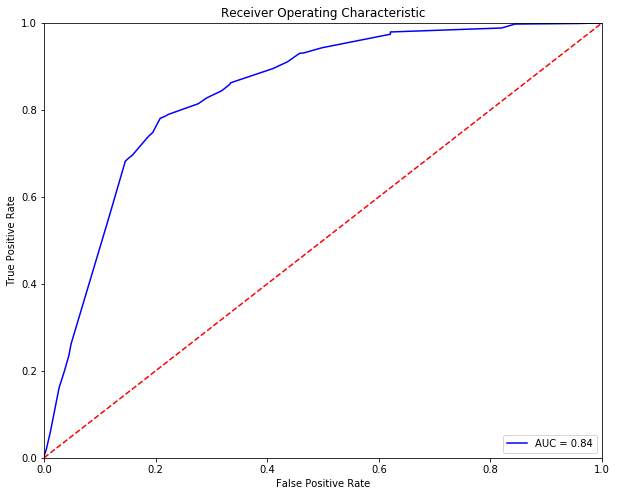

Optimal Threshold is 0.263157894737
Accuracy of Logistic Model on training data is: 0.788391777509


Predicted   0.0  1.0  __all__
Actual                       
0.0        1355  356     1711
1.0         169  601      770
__all__    1524  957     2481

In [382]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [383]:
table_70_70_PCA_0_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [384]:
%%capture
table_70_70_PCA_0_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

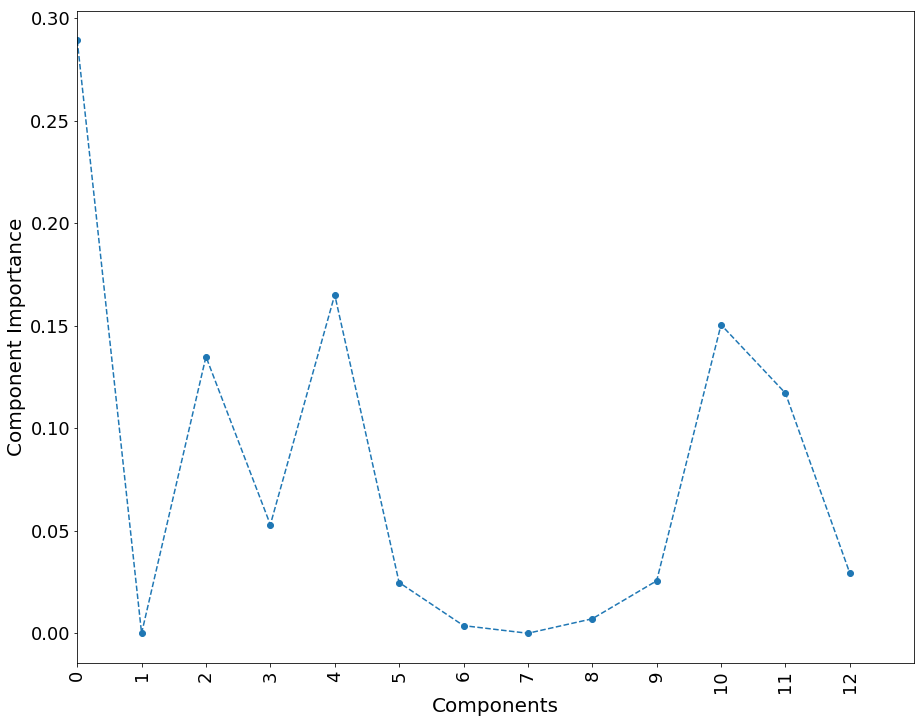

In [385]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [386]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.6          1500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.992399378131

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4078     0     4078
1            44  1667     1711
__all__    4122  1667     5789

Accuracy of the  Bagging  model for test data is: 0.796453043128

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1507  204     1711
1           301  469      770
__all__    1808  673     2481

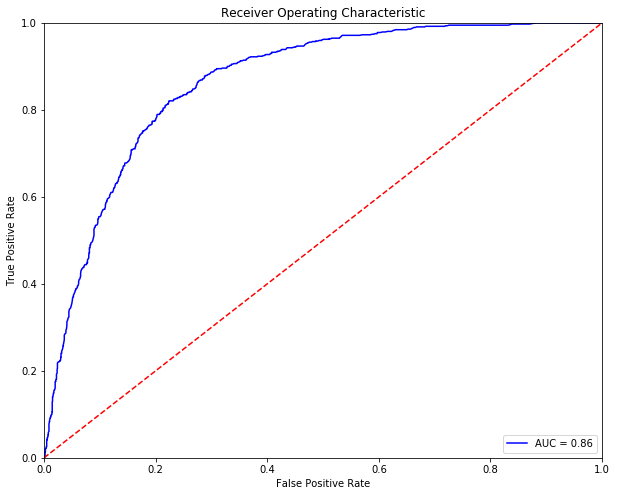

Optimal Threshold is 0.372666666667
Accuracy of Logistic Model on training data is: 0.792019347037


Predicted   0.0  1.0  __all__
Actual                       
0.0        1357  354     1711
1.0         162  608      770
__all__    1519  962     2481

In [387]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [388]:
table_70_70_PCA_0_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_0_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [389]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.946277422698


Predicted     0     1  __all__
Actual                        
0          4059    19     4078
1           292  1419     1711
__all__    4351  1438     5789

The test accuracy is: 0.784764207981


Predicted     0    1  __all__
Actual                       
0          1527  184     1711
1           350  420      770
__all__    1877  604     2481

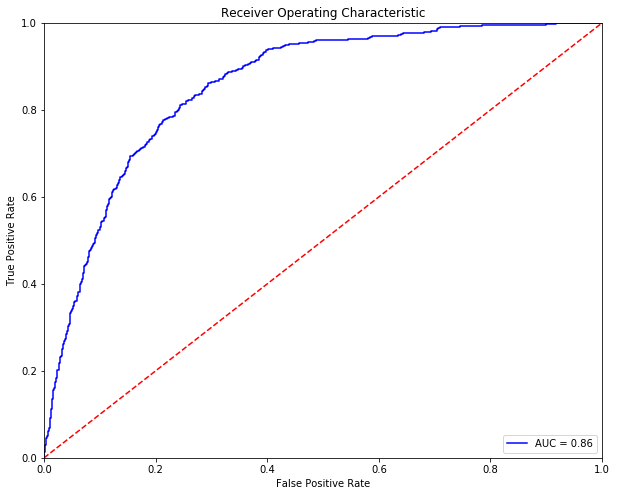

Optimal Threshold is 0.342896806469
Accuracy of Logistic Model on training data is: 0.779927448609


Predicted   0.0  1.0  __all__
Actual                       
0.0        1335  376     1711
1.0         170  600      770
__all__    1505  976     2481

In [390]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [391]:
table_70_70_PCA_0_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_0_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [392]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.869752979717


Predicted     0     1  __all__
Actual                        
0          3800   278     4078
1           476  1235     1711
__all__    4276  1513     5789

The accuracy of the model on test data is: 0.770656993148


Predicted     0    1  __all__
Actual                       
0          1493  218     1711
1           351  419      770
__all__    1844  637     2481

2048/2481 [=======================>......] - ETA: 0s

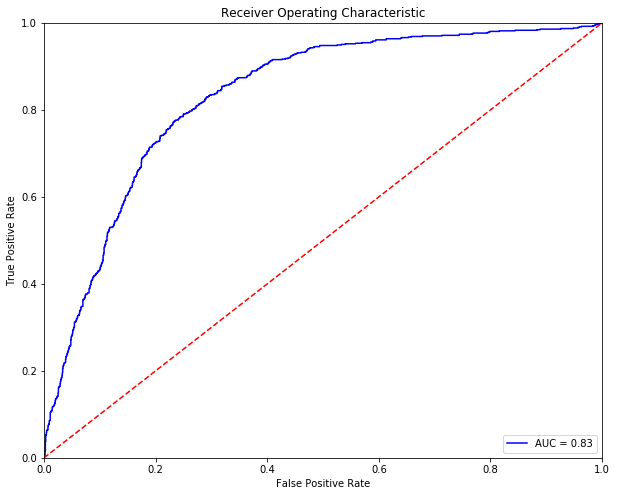

Optimal Threshold is 0.293434
Accuracy of Logistic Model on training data is: 0.769044740024


Predicted   0.0  1.0  __all__
Actual                       
0.0        1317  394     1711
1.0         179  591      770
__all__    1496  985     2481

In [393]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [394]:
table_70_70_PCA_0_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_0_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [395]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  7.9min finished


The accuracy of the model on training data is: 0.817412333736


Predicted     0     1  __all__
Actual                        
0          3497   581     4078
1           476  1235     1711
__all__    3973  1816     5789

The accuracy of the model on test data is: 0.812575574365


Predicted     0    1  __all__
Actual                       
0          1474  237     1711
1           228  542      770
__all__    1702  779     2481

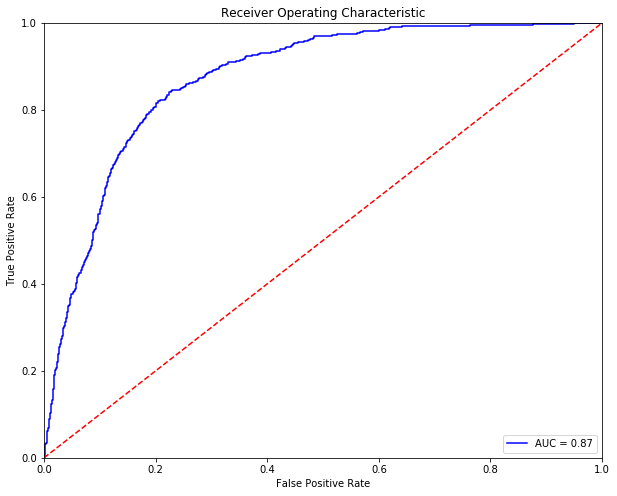

Optimal Threshold is 0.351002
Accuracy of Logistic Model on training data is: 0.804111245466


Predicted   0.0  1.0  __all__
Actual                       
0.0        1376  335     1711
1.0         151  619      770
__all__    1527  954     2481

In [396]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [397]:
table_70_70_PCA_0_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_0_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [398]:
table_70_70_PCA_0_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_PCA_0_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_PCA_0_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_70_70_PCA_0_test.set_index(['index'],drop=True,inplace=True)
table_70_70_PCA_0_train.set_index(['index'],drop=True,inplace=True)
table_70_70_PCA_0_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_70_PCA_0_train)

print("Comparision Table for Test Accuracies:")
display(table_70_70_PCA_0_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_70_PCA_0_test_roc)

Comparision Table for Training Accuracies:


accuracy           TP           TN           FP  \
index                                                                         
KNeighborsClassifier        1.000000  1711.000000  4078.000000     0.000000   
LogisticRegression          0.798411   985.000000  3637.000000   441.000000   
RandomForestClassifier      0.704439  2872.704094  1205.295906  1205.295906   
AdaBoostClassifier          0.809121  1236.000000  3448.000000   630.000000   
GradientBoostingClassifier  0.811366  1142.000000  3555.000000   523.000000   
ExtraTreeClassifier         0.808948  1213.000000  3470.000000   608.000000   
BaggingClassifier           0.992399  1667.000000  4078.000000     0.000000   
VotingClassifier            0.946277  1419.000000  4059.000000    19.000000   
Neural Network-1            0.869753  1235.000000  3800.000000   278.000000   
Neural-Network-2            0.817412  1235.000000  3497.000000   581.000000   

                                    FN       FPR       FNR  
index                                                       
KNeighborsClassifier          0.000000  0.000000  0.000000  
LogisticRegression          726.000000  0.108141  0.424313  
RandomForestClassifier      505.704094  0.704439  0.295561  
AdaBoostClassifier          475.000000  0.154487  0.277615  
GradientBoostingClassifier  569.000000  0.128249  0.332554  
ExtraTreeClassifier         498.000000  0.149093  0.291058  
BaggingClassifier            44.000000  0.000000  0.025716  
VotingClassifier            292.000000  0.004659  0.170660  
Neural Network-1            476.000000  0.068171  0.278200  
Neural-Network-2            476.000000  0.142472  0.278200

Comparision Table for Test Accuracies:


accuracy           TP           TN          FP  \
index                                                                        
KNeighborsClassifier        0.784361   409.000000  1537.000000  174.000000   
LogisticRegression          0.792422   437.000000  1529.000000  182.000000   
RandomForestClassifier      0.689641  1179.976219   531.023781  531.023781   
AdaBoostClassifier          0.806127   550.000000  1450.000000  261.000000   
GradientBoostingClassifier  0.808142   509.000000  1496.000000  215.000000   
ExtraTreeClassifier         0.800887   525.000000  1462.000000  249.000000   
BaggingClassifier           0.796453   469.000000  1507.000000  204.000000   
VotingClassifier            0.784764   420.000000  1527.000000  184.000000   
Neural Network-1            0.770657   419.000000  1493.000000  218.000000   
Neural-Network-2            0.812576   542.000000  1474.000000  237.000000   

                                    FN       FPR       FNR  
index                                                       
KNeighborsClassifier        361.000000  0.101695  0.468831  
LogisticRegression          333.000000  0.106371  0.432468  
RandomForestClassifier      238.976219  0.689641  0.310359  
AdaBoostClassifier          220.000000  0.152542  0.285714  
GradientBoostingClassifier  261.000000  0.125658  0.338961  
ExtraTreeClassifier         245.000000  0.145529  0.318182  
BaggingClassifier           301.000000  0.119229  0.390909  
VotingClassifier            350.000000  0.107539  0.454545  
Neural Network-1            351.000000  0.127411  0.455844  
Neural-Network-2            228.000000  0.138515  0.296104

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.796453  613.0  1363.0  348.0  157.0  0.203390   
LogisticRegression          0.796453  613.0  1363.0  348.0  157.0  0.203390   
RandomForestClassifier      0.797662  607.0  1372.0  339.0  163.0  0.198130   
AdaBoostClassifier          0.795244  612.0  1361.0  350.0  158.0  0.204559   
GradientBoostingClassifier  0.798468  613.0  1368.0  343.0  157.0  0.200468   
ExtraTreeClassifier         0.788392  601.0  1355.0  356.0  169.0  0.208065   
BaggingClassifier           0.792019  608.0  1357.0  354.0  162.0  0.206897   
VotingClassifier            0.779927  600.0  1335.0  376.0  170.0  0.219755   
Neural Network-1            0.769045  591.0  1317.0  394.0  179.0  0.230275   
Neural-Network-2            0.804111  619.0  1376.0  335.0  151.0  0.195792   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.203896   0.269484  0.856967  
LogisticRegression          0.203896   0.395165  0.864472  
RandomForestClassifier      0.211688   0.260365  0.821753  
AdaBoostClassifier          0.205195   0.476124  0.871484  
GradientBoostingClassifier  0.203896   0.359216  0.871997  
ExtraTreeClassifier         0.219481   0.263158  0.841437  
BaggingClassifier           0.210390   0.372667  0.864230  
VotingClassifier            0.220779   0.342897  0.855286  
Neural Network-1            0.232468   0.293434  0.831368  
Neural-Network-2            0.196104   0.351002  0.872588

#### Random State 10

In [399]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_10.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())

X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.3)

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  3030  230.950495   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...   599  158.008347   

                                                          PAS        LEN  \
Source_User                                                                
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  80.524092  84.155116   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  57.856427  82.028381   

                                                            BYS  \
Source_User                                                       
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  9686.861716   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  6161.512521   

                                                              BYR      SP  \
Source_User                                                                 
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  287727.528383  2741.0   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  198461.532554   587.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  11.0    40   63  820   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  12.0    30   70  210   

                                                            TDIF  0000  0100  \
Source_User                                                                    
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   2395.224422   195   256   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  12098.198664     0     3   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   110    55    63    53   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     3     2     4     2   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...    56    31    79    81   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     0    34    70    92   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...    39    75    98    81   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...   117    30    10    14   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   159   264   181   142   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     7     5    25    37   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   177   135   120   184   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...    61    27    27    25   

                                                    2200  2300  
Source_User                                                     
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   240   156  
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     1     3

1 -> Infected
0 -> Uninfected


Source_User
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3449af4e82e30f9f87    0
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce851fca5724939971862    1
06fe39332e5261ed8a5f1bb9d62559deb0de1620963ebbded14eecf78b8a0a20    0
5455eddbb8ee814c41a27e8676a6cc34faa6fc295c6e92588fc75dbe7f61369b    0
47a99c45d555e42658dbf94be7417ec6c327ecfc05ed5c57eaac1de3bd43bb86    1
60ff3ff13bb2e6a16dc866bc314964cc6d60b1e9891d805e7d9e99b1864ae896    1
a4244338cc086f69de152063f5b11482be2d007a5da089331dc2fe778e459e26    1
70de2ff22d8dd1433aa38947470f94f455bcbdabb1789e81332ba5c390408acc    1
6c49763f6a507ebf7aff12e40a61cfe3624fca5d5ac9dc1b86ac38c68ca4b1ba    0
ab60d8ea5924263ddfde9661ee4a4081f95679c77492da4479cd0350f56c7de3    0
Name: Target, dtype: int64

Variance explained using 13 components is: 0.915617452326
The train/test split ratio is 70:30


In [400]:
display(X_pca_13[0:1])

array([[ 0.1092487 ,  0.09758928, -0.52784745,  0.50560657, -0.430521  ,
        -0.43954403,  0.08248622,  0.03391669, -0.09021769,  0.28432751,
         0.05267798, -0.86988474, -0.07038592]])

In [401]:
## Table to store training and test measures
table_70_70_PCA_10_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_PCA_10_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_PCA_10_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [402]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  manhattan           50  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4059     0     4059
1             0  1730     1730
__all__    4059  1730     5789

Accuracy of the  KNN  model for test data is: 0.792019347037

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1539  191     1730
1           325  426      751
__all__    1864  617     2481

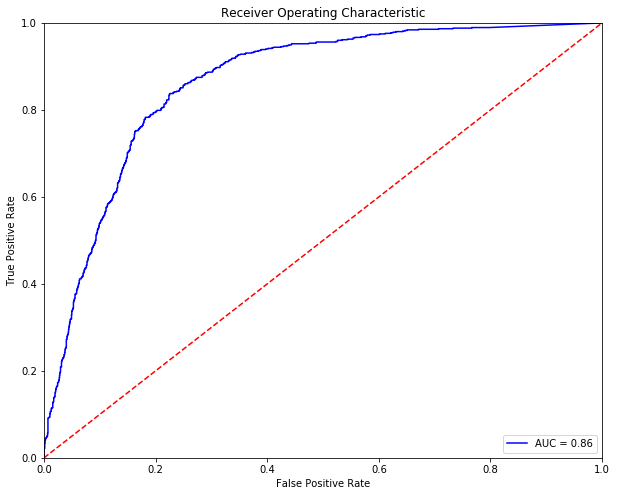

Optimal Threshold is 0.297667461809
Accuracy of Logistic Model on training data is: 0.798065296252


Predicted   0.0  1.0  __all__
Actual                       
0.0        1381  349     1730
1.0         152  599      751
__all__    1533  948     2481

In [403]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [404]:
table_70_70_PCA_10_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_10_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [405]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False          False                0.5        50          ovr   

             6       7      8  
index  penalty  solver    tol  
0           l2     sag  1e-05

Accuracy of the  Logistic  model for the training data is: 0.795128692348

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3296   763     4059
1           423  1307     1730
__all__    3719  2070     5789

Accuracy of the  Logistic  model for test data is: 0.807738814994

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1411  319     1730
1           158  593      751
__all__    1569  912     2481

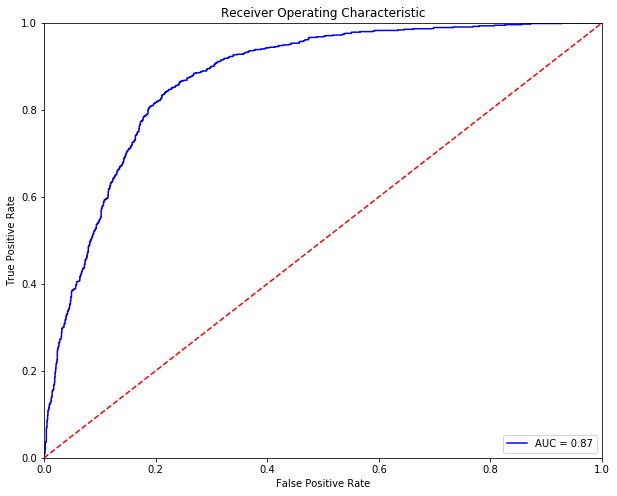

Optimal Threshold is 0.47498360736
Accuracy of Logistic Model on training data is: 0.808544941556


Predicted   0.0  1.0  __all__
Actual                       
0.0        1399  331     1730
1.0         144  607      751
__all__    1543  938     2481

In [406]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [407]:
table_70_70_PCA_10_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_10_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [408]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[2000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1          2000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.701157367421

Confusion Matrix for Training data is:


Predicted     0  1  __all__
Actual                     
0          4059  0     4059
1          1730  0     1730
__all__    5789  0     5789

Accuracy of the  Random Forest Trees  model for test data is: 0.697299476018

Confusion Matrix for test data is:


Predicted     0  1  __all__
Actual                     
0          1730  0     1730
1           751  0      751
__all__    2481  0     2481

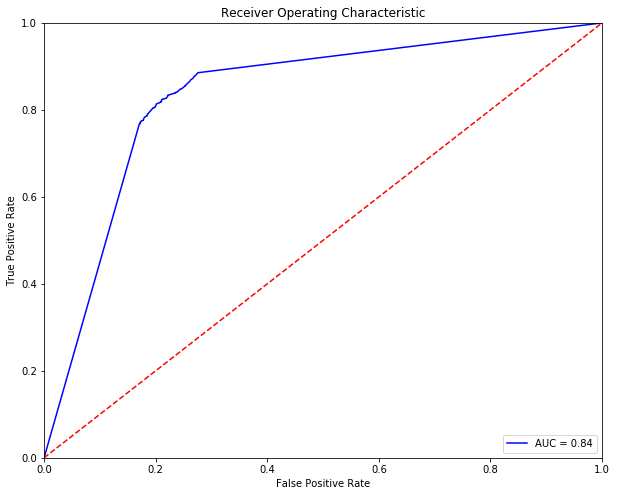

Optimal Threshold is 0.331885748674
Accuracy of Logistic Model on training data is: 0.804917372027


Predicted   0.0  1.0  __all__
Actual                       
0.0        1393  337     1730
1.0         147  604      751
__all__    1540  941     2481

In [409]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [410]:
table_70_70_PCA_10_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_10_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

4059
0
0
4059
1730
0
0
1730
1.0
0.0
0.0
1.0
1730
0
0
1730
751
0
0
751
1.0
0.0
0.0
1.0


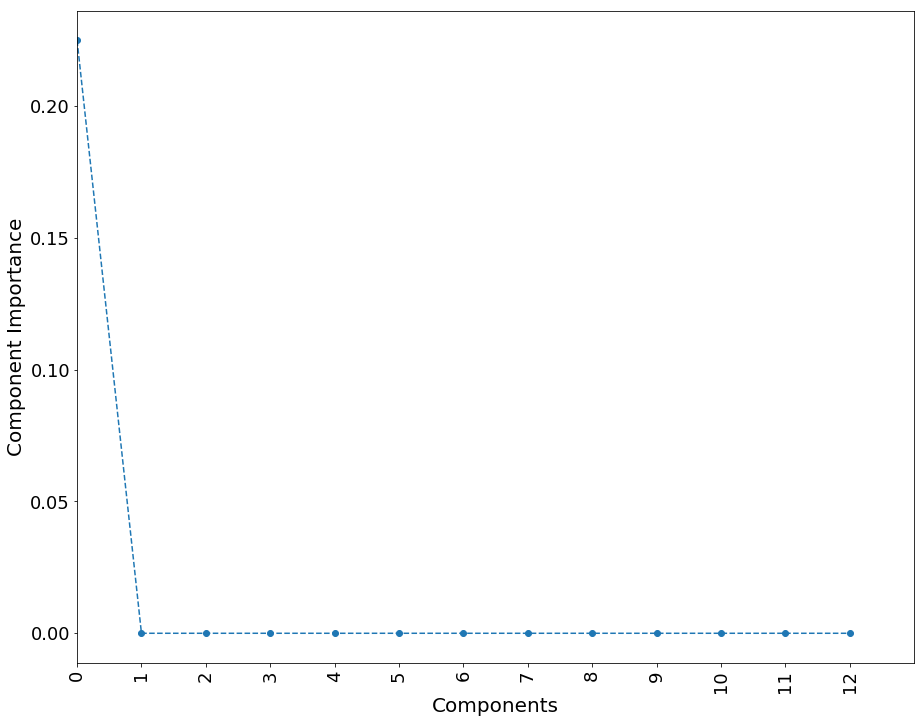

In [411]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [412]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME            0.5           400             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.802038348592

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3393   666     4059
1           480  1250     1730
__all__    3873  1916     5789

Accuracy of the  AdaBoostClassifier  model for test data is: 0.807335751713

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1431  299     1730
1           179  572      751
__all__    1610  871     2481

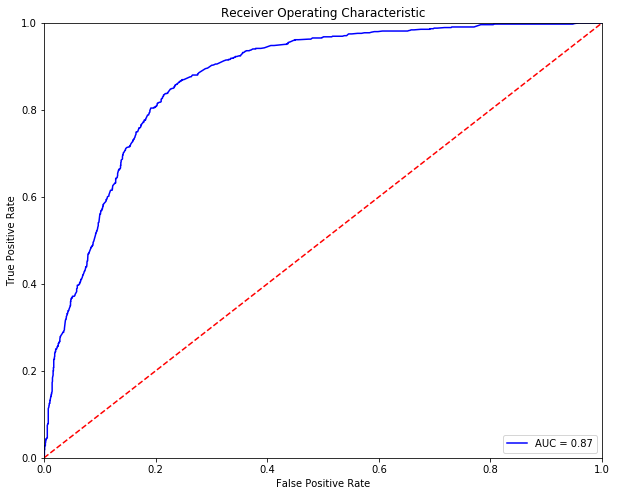

Optimal Threshold is 0.499508662882
Accuracy of Logistic Model on training data is: 0.805723498589


Predicted   0.0  1.0  __all__
Actual                       
0.0        1395  335     1730
1.0         147  604      751
__all__    1542  939     2481

In [413]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [414]:
table_70_70_PCA_10_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_10_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

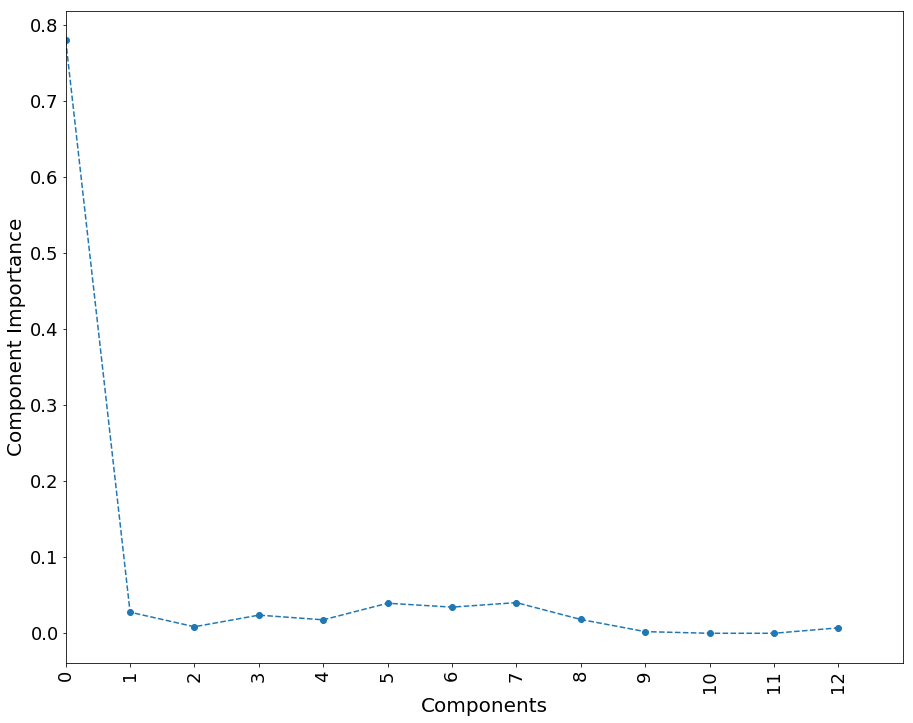

In [415]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [416]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1         2                 3  \
index  criterion  learning_rate      loss  min_samples_leaf   
0            mse           0.03  deviance                20   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1           150             0        0.7

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.810502677492

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3490   569     4059
1           528  1202     1730
__all__    4018  1771     5789

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.804514308746

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1463  267     1730
1           218  533      751
__all__    1681  800     2481

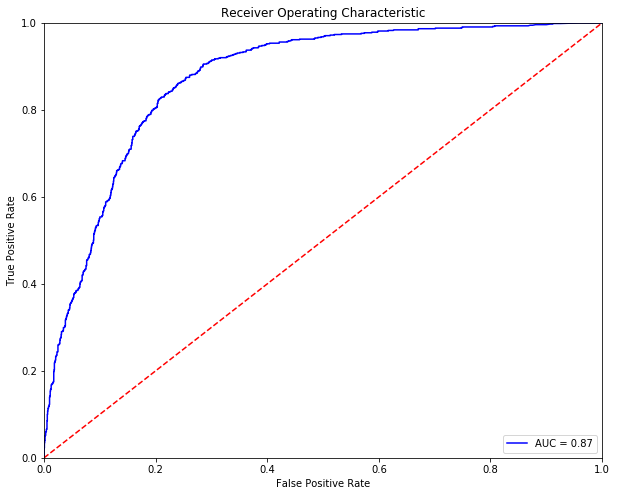

Optimal Threshold is 0.39133258436
Accuracy of Logistic Model on training data is: 0.802498992342


Predicted   0.0  1.0  __all__
Actual                       
0.0        1389  341     1730
1.0         149  602      751
__all__    1538  943     2481

In [417]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [418]:
table_70_70_PCA_10_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_10_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

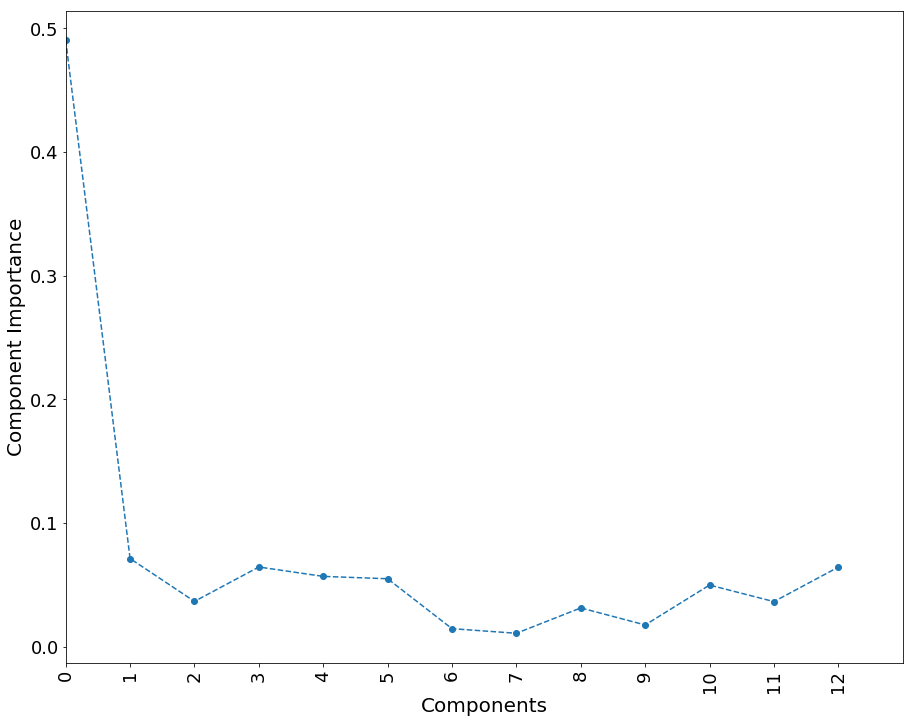

In [419]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [420]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0        entropy         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     3                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.807393332182

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3411   648     4059
1           467  1263     1730
__all__    3878  1911     5789

Accuracy of the  Extra Decision Tree  model for test data is: 0.791213220476

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1435  295     1730
1           223  528      751
__all__    1658  823     2481

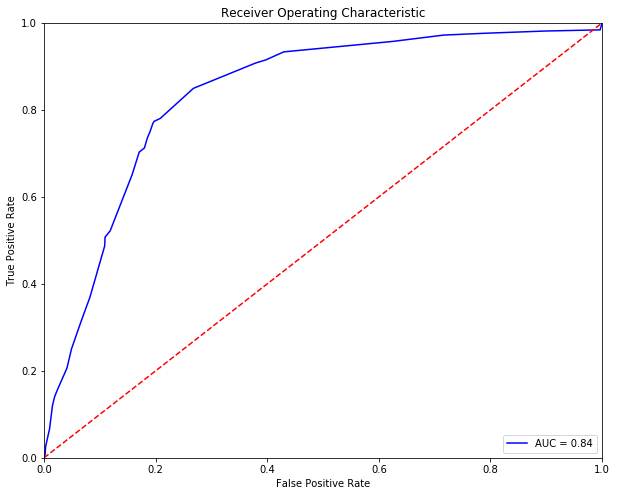

Optimal Threshold is 0.355555555556
Accuracy of Logistic Model on training data is: 0.794034663442


Predicted   0.0  1.0  __all__
Actual                       
0.0        1389  341     1730
1.0         170  581      751
__all__    1559  922     2481

In [421]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [422]:
table_70_70_PCA_10_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [423]:
%%capture
table_70_70_PCA_10_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

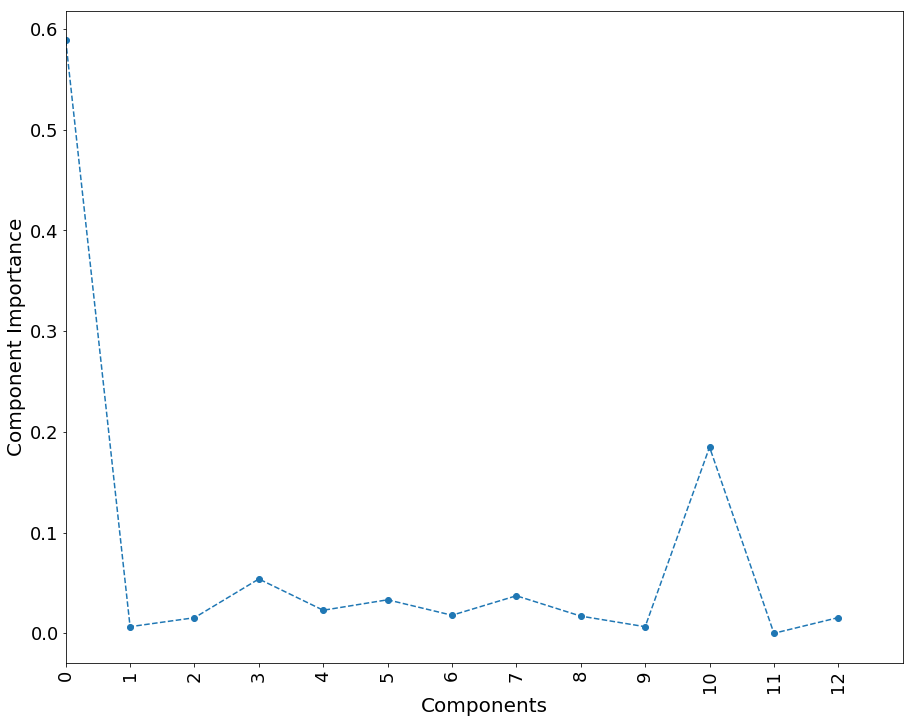

In [424]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [425]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.4           500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.961651407842

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4027    32     4059
1           190  1540     1730
__all__    4217  1572     5789

Accuracy of the  Bagging  model for test data is: 0.799677549375

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1506  224     1730
1           273  478      751
__all__    1779  702     2481

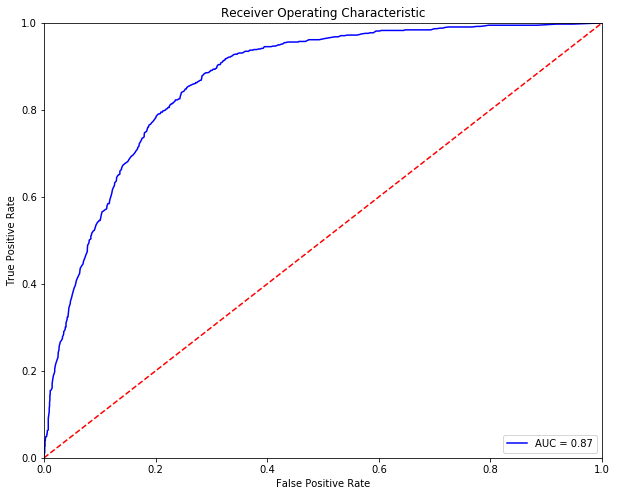

Optimal Threshold is 0.4
Accuracy of Logistic Model on training data is: 0.792019347037


Predicted   0.0  1.0  __all__
Actual                       
0.0        1371  359     1730
1.0         157  594      751
__all__    1528  953     2481

In [426]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [427]:
table_70_70_PCA_10_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_10_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [428]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.944722750043


Predicted     0     1  __all__
Actual                        
0          4037    22     4059
1           298  1432     1730
__all__    4335  1454     5789

The test accuracy is: 0.781136638452


Predicted     0    1  __all__
Actual                       
0          1534  196     1730
1           347  404      751
__all__    1881  600     2481

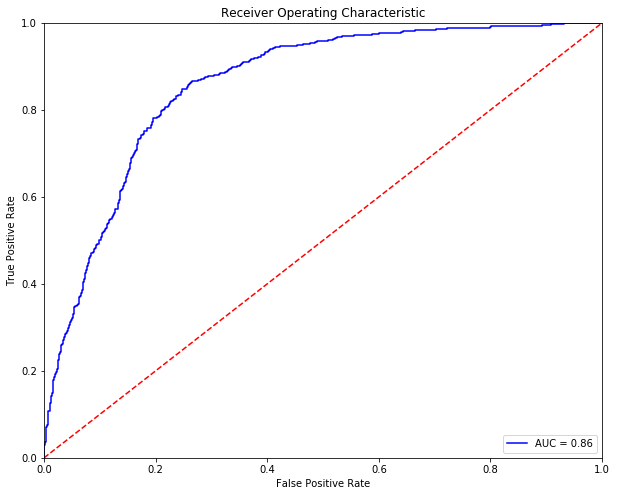

Optimal Threshold is 0.375023227933
Accuracy of Logistic Model on training data is: 0.791213220476


Predicted   0.0  1.0  __all__
Actual                       
0.0        1369  361     1730
1.0         157  594      751
__all__    1526  955     2481

In [429]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [430]:
table_70_70_PCA_10_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_10_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [431]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.869062014093


Predicted     0     1  __all__
Actual                        
0          3814   245     4059
1           513  1217     1730
__all__    4327  1462     5789

The accuracy of the model on test data is: 0.778315195486


Predicted     0    1  __all__
Actual                       
0          1499  231     1730
1           319  432      751
__all__    1818  663     2481

1952/2481 [======================>.......] - ETA: 0s

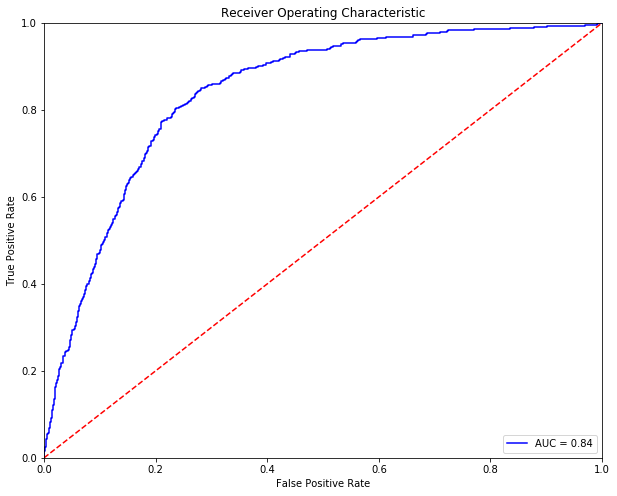

Optimal Threshold is 0.270908
Accuracy of Logistic Model on training data is: 0.779121322048


Predicted   0.0  1.0  __all__
Actual                       
0.0        1348  382     1730
1.0         166  585      751
__all__    1514  967     2481

In [432]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [433]:
table_70_70_PCA_10_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_10_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [434]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  8.4min finished


The accuracy of the model on training data is: 0.805838659527


Predicted     0     1  __all__
Actual                        
0          3386   673     4059
1           451  1279     1730
__all__    3837  1952     5789

The accuracy of the model on test data is: 0.806932688432


Predicted     0    1  __all__
Actual                       
0          1422  308     1730
1           171  580      751
__all__    1593  888     2481

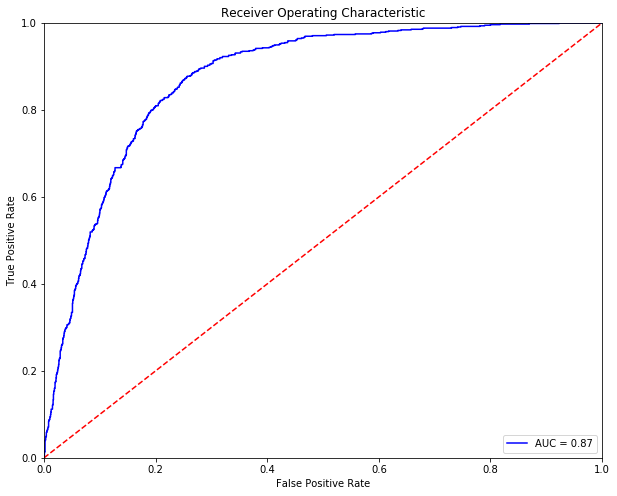

Optimal Threshold is 0.425791
Accuracy of Logistic Model on training data is: 0.803708182185


Predicted   0.0  1.0  __all__
Actual                       
0.0        1391  339     1730
1.0         148  603      751
__all__    1539  942     2481

In [435]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [436]:
table_70_70_PCA_10_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_10_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [437]:
table_70_70_PCA_10_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_PCA_10_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_PCA_10_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_70_70_PCA_10_test.set_index(['index'],drop=True,inplace=True)
table_70_70_PCA_10_train.set_index(['index'],drop=True,inplace=True)
table_70_70_PCA_10_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_70_PCA_10_train)

print("Comparision Table for Test Accuracies:")
display(table_70_70_PCA_10_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_70_PCA_10_test_roc)

Comparision Table for Training Accuracies:


accuracy           TP           TN           FP  \
index                                                                         
KNeighborsClassifier        1.000000  1730.000000  4059.000000     0.000000   
LogisticRegression          0.795129  1307.000000  3296.000000   763.000000   
RandomForestClassifier      0.701157  2845.997754  1213.002246  1213.002246   
AdaBoostClassifier          0.802038  1250.000000  3393.000000   666.000000   
GradientBoostingClassifier  0.810503  1202.000000  3490.000000   569.000000   
ExtraTreeClassifier         0.807393  1263.000000  3411.000000   648.000000   
BaggingClassifier           0.961651  1540.000000  4027.000000    32.000000   
VotingClassifier            0.944723  1432.000000  4037.000000    22.000000   
Neural Network-1            0.869062  1217.000000  3814.000000   245.000000   
Neural-Network-2            0.805839  1279.000000  3386.000000   673.000000   

                                    FN       FPR       FNR  
index                                                       
KNeighborsClassifier          0.000000  0.000000  0.000000  
LogisticRegression          423.000000  0.187977  0.244509  
RandomForestClassifier      516.997754  0.701157  0.298843  
AdaBoostClassifier          480.000000  0.164080  0.277457  
GradientBoostingClassifier  528.000000  0.140182  0.305202  
ExtraTreeClassifier         467.000000  0.159645  0.269942  
BaggingClassifier           190.000000  0.007884  0.109827  
VotingClassifier            298.000000  0.005420  0.172254  
Neural Network-1            513.000000  0.060360  0.296532  
Neural-Network-2            451.000000  0.165804  0.260694

Comparision Table for Test Accuracies:


accuracy           TP           TN          FP  \
index                                                                        
KNeighborsClassifier        0.792019   426.000000  1539.000000  191.000000   
LogisticRegression          0.807739   593.000000  1411.000000  319.000000   
RandomForestClassifier      0.697299  1206.328094   523.671906  523.671906   
AdaBoostClassifier          0.807336   572.000000  1431.000000  299.000000   
GradientBoostingClassifier  0.804514   533.000000  1463.000000  267.000000   
ExtraTreeClassifier         0.791213   528.000000  1435.000000  295.000000   
BaggingClassifier           0.799678   478.000000  1506.000000  224.000000   
VotingClassifier            0.781137   404.000000  1534.000000  196.000000   
Neural Network-1            0.778315   432.000000  1499.000000  231.000000   
Neural-Network-2            0.806933   580.000000  1422.000000  308.000000   

                                    FN       FPR       FNR  
index                                                       
KNeighborsClassifier        325.000000  0.110405  0.432756  
LogisticRegression          158.000000  0.184393  0.210386  
RandomForestClassifier      227.328094  0.697299  0.302701  
AdaBoostClassifier          179.000000  0.172832  0.238349  
GradientBoostingClassifier  218.000000  0.154335  0.290280  
ExtraTreeClassifier         223.000000  0.170520  0.296937  
BaggingClassifier           273.000000  0.129480  0.363515  
VotingClassifier            347.000000  0.113295  0.462051  
Neural Network-1            319.000000  0.133526  0.424767  
Neural-Network-2            171.000000  0.178035  0.227696

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.798065  599.0  1381.0  349.0  152.0  0.201734   
LogisticRegression          0.808545  607.0  1399.0  331.0  144.0  0.191329   
RandomForestClassifier      0.804917  604.0  1393.0  337.0  147.0  0.194798   
AdaBoostClassifier          0.805723  604.0  1395.0  335.0  147.0  0.193642   
GradientBoostingClassifier  0.802499  602.0  1389.0  341.0  149.0  0.197110   
ExtraTreeClassifier         0.794035  581.0  1389.0  341.0  170.0  0.197110   
BaggingClassifier           0.792019  594.0  1371.0  359.0  157.0  0.207514   
VotingClassifier            0.791213  594.0  1369.0  361.0  157.0  0.208671   
Neural Network-1            0.779121  585.0  1348.0  382.0  166.0  0.220809   
Neural-Network-2            0.803708  603.0  1391.0  339.0  148.0  0.195954   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.202397   0.297667  0.863766  
LogisticRegression          0.191744   0.474984  0.873712  
RandomForestClassifier      0.195739   0.331886  0.835402  
AdaBoostClassifier          0.195739   0.499509  0.872838  
GradientBoostingClassifier  0.198402   0.391333  0.873297  
ExtraTreeClassifier         0.226365   0.355556  0.836858  
BaggingClassifier           0.209055   0.400000  0.867948  
VotingClassifier            0.209055   0.375023  0.858165  
Neural Network-1            0.221039   0.270908  0.840177  
Neural-Network-2            0.197071   0.425791  0.873338

#### Random State 20

In [438]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_20.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())

X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.3)

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   651   35.807988   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  4059  321.478197   

                                                           PAS         LEN  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   35.328725  108.442396   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  131.395910   73.695245   

                                                             BYS  \
Source_User                                                        
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   3976.233487   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  31586.025868   

                                                              BYR      SP  \
Source_User                                                                 
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   37072.858679   639.0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  413326.700419  3627.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   8.0    21   23  158   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  18.0    40   31  974   

                                                            TDIF  0000  0100  \
Source_User                                                                    
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...  11131.820276     6     0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   1803.300813   196   310   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     2     0     0     0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   532   308   202   101   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     0    13     8    34   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...    45   281    95    38   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    95    39    76    71   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...    93    95   206   102   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    74    66   114    27   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   104    84   194   144   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    14     0     0     7   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   116   161   158   138   

                                                    2200  2300  
Source_User                                                     
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     3     2  
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   159   197

1 -> Infected
0 -> Uninfected


Source_User
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d641329bc603046dfcc4    0
307c636564c5ec9897e5062605e2982daf781f0f82b0234f2cbc55919f8d04e2    0
11e8b7b973c885d9d2560baeec4673bc6b13aab08d9e49bc9c519727595e4d3e    1
41851f48304067368da8f12794e2f539330cc7ef6732c1440ed4c5eb06b9cc5d    0
08402d90e55ea64677880c21fc3850422ad2e08f730282d271027f0fea60b4b6    1
952aed50327c6ac4e19a033bb585959b33ea2ca897f985dc33a1bb6a1f3d7cc7    0
6b42f8e7f92d2fccc0fae12167ef5e929f394e87e9c70bb36ac160bf6d6cb0f4    0
c9140a85217daf0d18148d489fa6d3293cbe499584b12e28be0e381a20eeb737    1
647e8a6690cd21f7bae287782ec6a621cae3a5ba6f37b779d99f28a7851b1bfc    0
42d06643547a80b9343fa1a09ca32b0c3bb84caa31bfb45c629b6835072e364b    0
Name: Target, dtype: int64

Variance explained using 13 components is: 0.920535156414
The train/test split ratio is 70:30


In [439]:
display(X_pca_13[0:1])

array([[-0.5327557 , -0.05293468,  0.17489689, -0.0108528 ,  0.30105805,
         0.0389905 ,  0.13583015, -0.32384755,  0.65499101, -0.0822117 ,
         0.18802012,  0.15884271,  0.03627151]])

In [440]:
## Table to store training and test measures
table_70_70_PCA_20_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_PCA_20_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_PCA_20_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [441]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  euclidean           20  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4039     0     4039
1             0  1750     1750
__all__    4039  1750     5789

Accuracy of the  KNN  model for test data is: 0.796453043128

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1576  174     1750
1           331  400      731
__all__    1907  574     2481

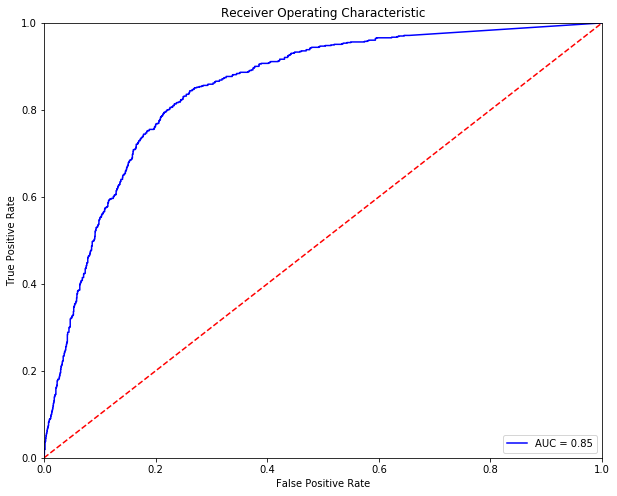

Optimal Threshold is 0.294521452973
Accuracy of Logistic Model on training data is: 0.787585650947


Predicted   0.0  1.0  __all__
Actual                       
0.0        1379  371     1750
1.0         156  575      731
__all__    1535  946     2481

In [442]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [443]:
table_70_70_PCA_20_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_20_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [444]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False          False                0.5        50  multinomial   

             6          7      8  
index  penalty     solver    tol  
0           l2  newton-cg  1e-05

Accuracy of the  Logistic  model for the training data is: 0.79858352047

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3287   752     4039
1           414  1336     1750
__all__    3701  2088     5789

Accuracy of the  Logistic  model for test data is: 0.81015719468

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1460  290     1750
1           181  550      731
__all__    1641  840     2481

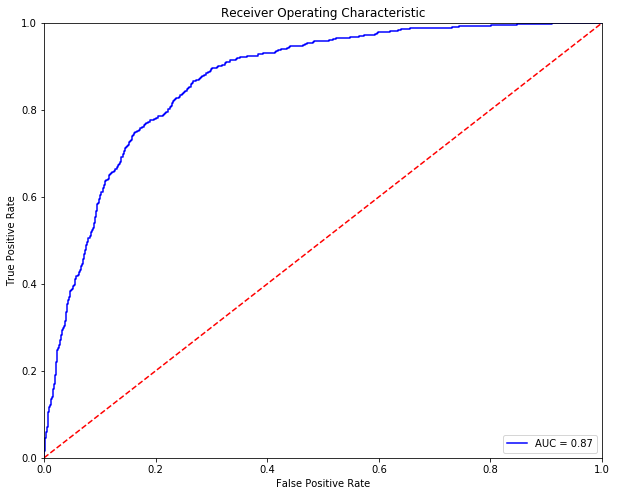

Optimal Threshold is 0.464737710426
Accuracy of Logistic Model on training data is: 0.786779524385


Predicted   0.0  1.0  __all__
Actual                       
0.0        1377  373     1750
1.0         156  575      731
__all__    1533  948     2481

In [445]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [446]:
table_70_70_PCA_20_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_20_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [447]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[2000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1          2000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.697702539299

Confusion Matrix for Training data is:


Predicted     0  1  __all__
Actual                     
0          4039  0     4039
1          1750  0     1750
__all__    5789  0     5789

Accuracy of the  Random Forest Trees  model for test data is: 0.705360741636

Confusion Matrix for test data is:


Predicted     0  1  __all__
Actual                     
0          1750  0     1750
1           731  0      731
__all__    2481  0     2481

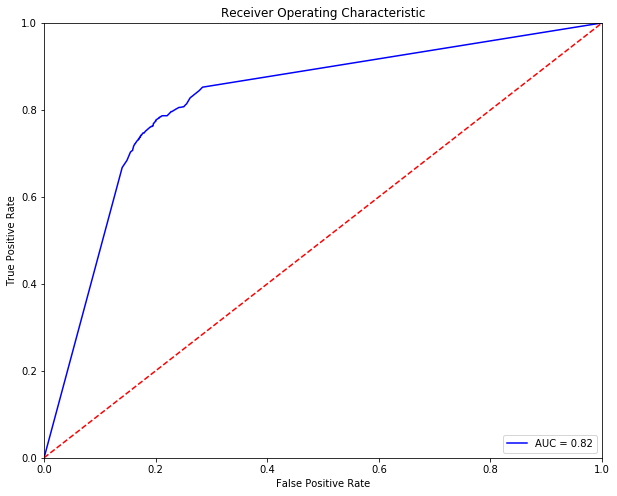

Optimal Threshold is 0.271346140423
Accuracy of Logistic Model on training data is: 0.78879484079


Predicted   0.0  1.0  __all__
Actual                       
0.0        1383  367     1750
1.0         157  574      731
__all__    1540  941     2481

In [448]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [449]:
table_70_70_PCA_20_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_20_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

4039
0
0
4039
1750
0
0
1750
1.0
0.0
0.0
1.0
1750
0
0
1750
731
0
0
731
1.0
0.0
0.0
1.0


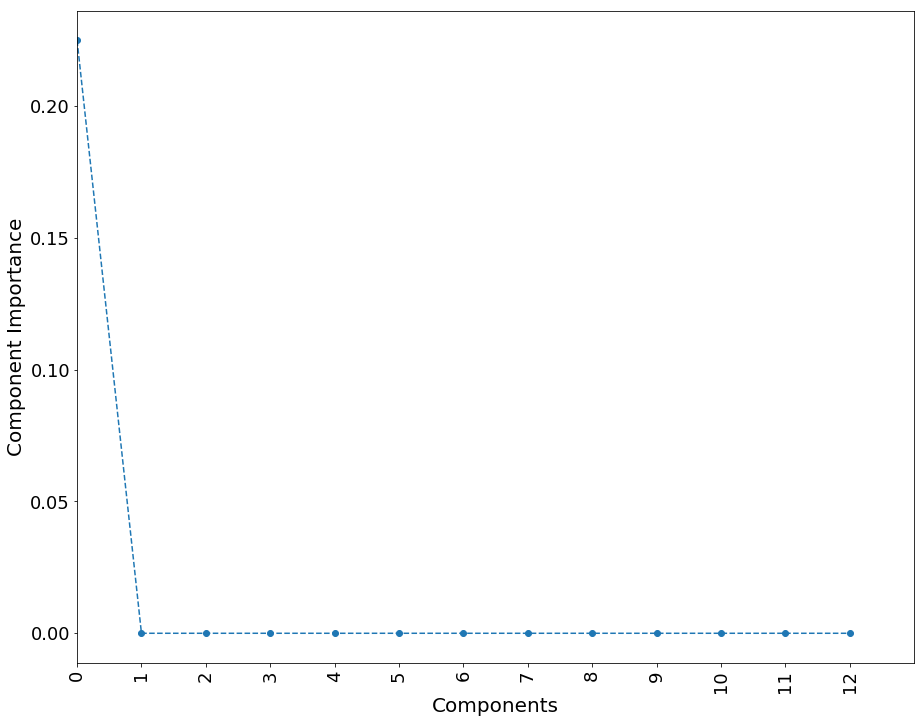

In [450]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [451]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME              1           400             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.806875107963

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3438   601     4039
1           517  1233     1750
__all__    3955  1834     5789

Accuracy of the  AdaBoostClassifier  model for test data is: 0.805320435308

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1506  244     1750
1           239  492      731
__all__    1745  736     2481

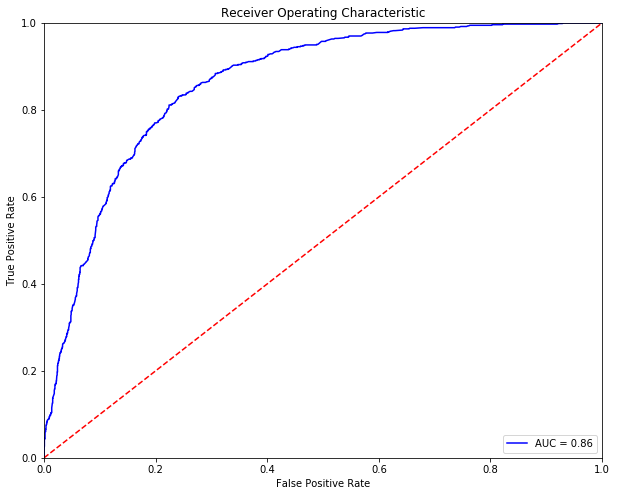

Optimal Threshold is 0.476656597972
Accuracy of Logistic Model on training data is: 0.785570334543


Predicted   0.0  1.0  __all__
Actual                       
0.0        1375  375     1750
1.0         157  574      731
__all__    1532  949     2481

In [452]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [453]:
table_70_70_PCA_20_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_20_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

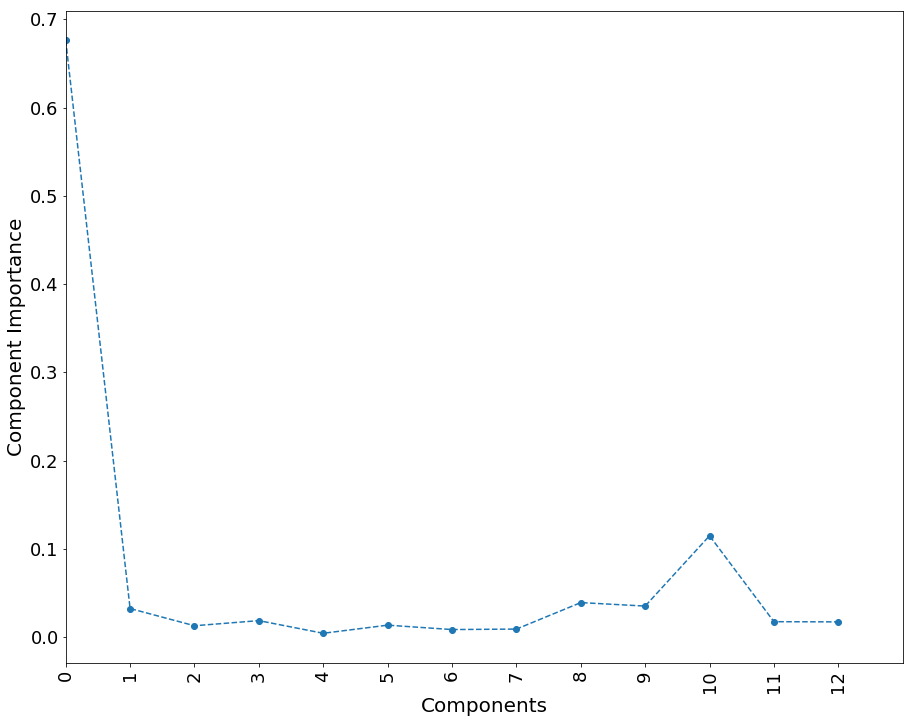

In [454]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [455]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse           0.05  exponential                10   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1           100             0        0.7

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.81326653999

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3456   583     4039
1           498  1252     1750
__all__    3954  1835     5789

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.815397017332

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1517  233     1750
1           225  506      731
__all__    1742  739     2481

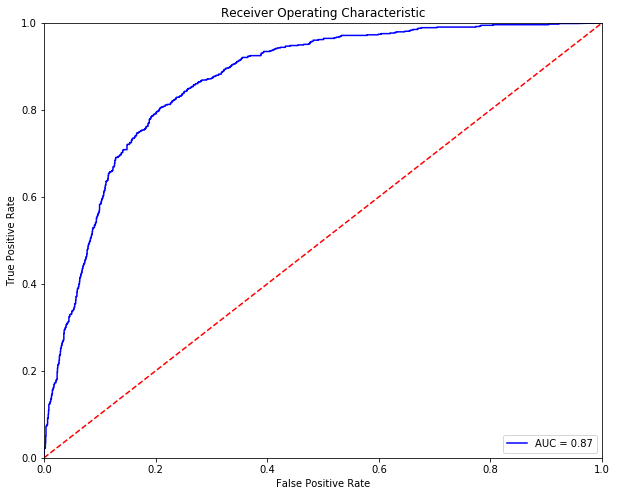

Optimal Threshold is 0.350113520458
Accuracy of Logistic Model on training data is: 0.796453043128


Predicted   0.0  1.0  __all__
Actual                       
0.0        1394  356     1750
1.0         149  582      731
__all__    1543  938     2481

In [456]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [457]:
table_70_70_PCA_20_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_20_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

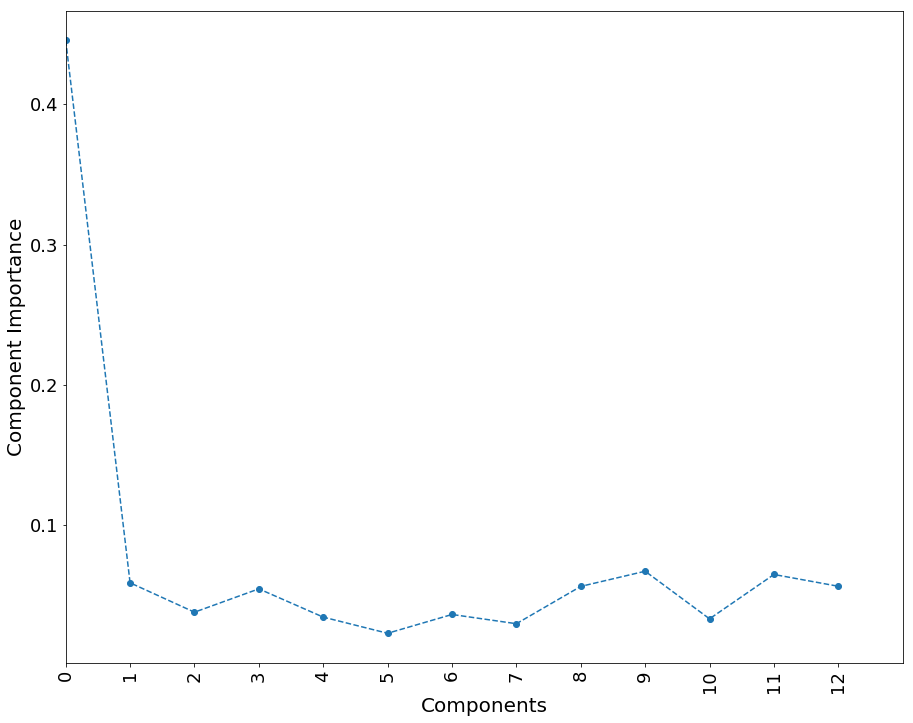

In [458]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [459]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0           gini         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.796510623596

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3255   784     4039
1           394  1356     1750
__all__    3649  2140     5789

Accuracy of the  Extra Decision Tree  model for test data is: 0.797662232971

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1432  318     1750
1           184  547      731
__all__    1616  865     2481

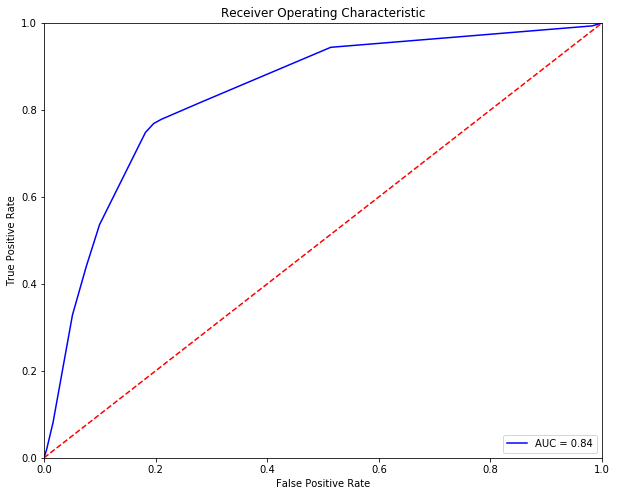

Optimal Threshold is 0.276923076923
Accuracy of Logistic Model on training data is: 0.79322853688


Predicted   0.0  1.0  __all__
Actual                       
0.0        1406  344     1750
1.0         169  562      731
__all__    1575  906     2481

In [460]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [461]:
table_70_70_PCA_20_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [462]:
%%capture
table_70_70_PCA_20_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

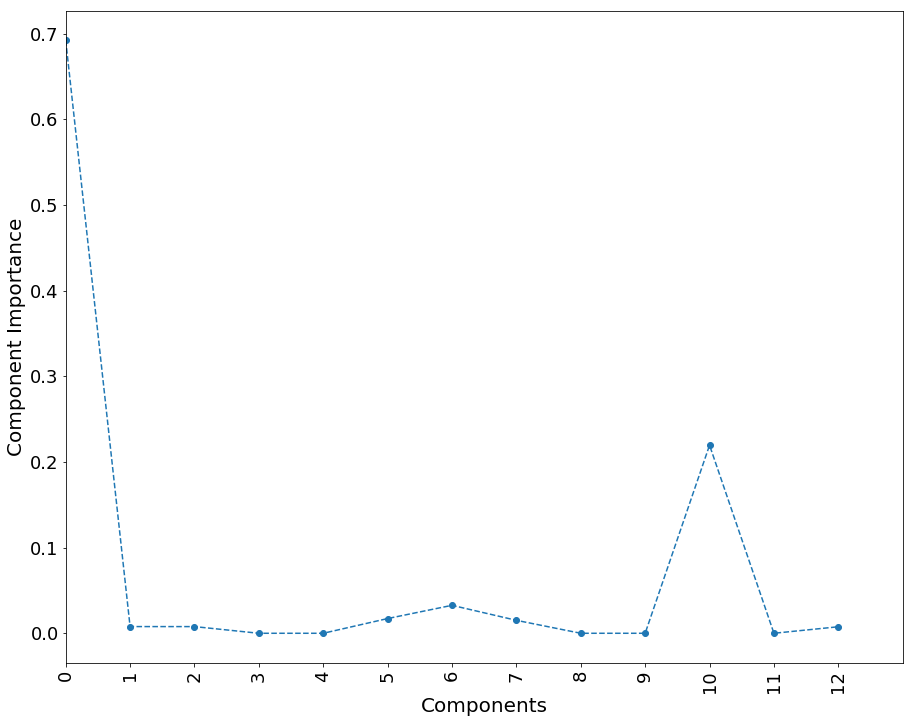

In [463]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [464]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.6           500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.991881153913

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4039     0     4039
1            47  1703     1750
__all__    4086  1703     5789

Accuracy of the  Bagging  model for test data is: 0.80169286578

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1535  215     1750
1           277  454      731
__all__    1812  669     2481

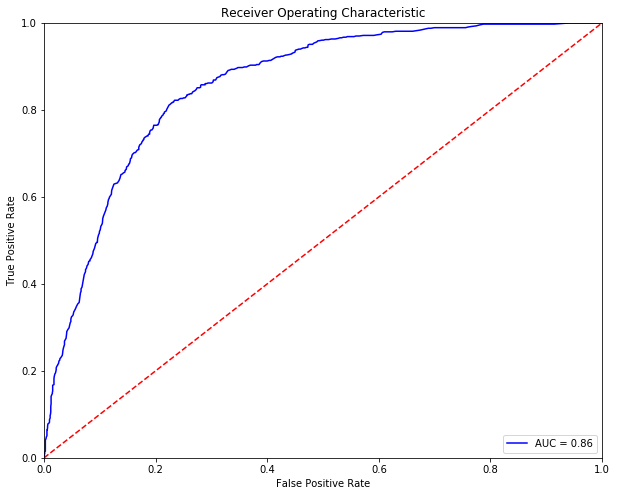

Optimal Threshold is 0.37
Accuracy of Logistic Model on training data is: 0.787988714228


Predicted   0.0  1.0  __all__
Actual                       
0.0        1380  370     1750
1.0         156  575      731
__all__    1536  945     2481

In [465]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [466]:
table_70_70_PCA_20_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_20_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [467]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.944377267231


Predicted     0     1  __all__
Actual                        
0          4010    29     4039
1           293  1457     1750
__all__    4303  1486     5789

The test accuracy is: 0.791213220476


Predicted     0    1  __all__
Actual                       
0          1553  197     1750
1           321  410      731
__all__    1874  607     2481

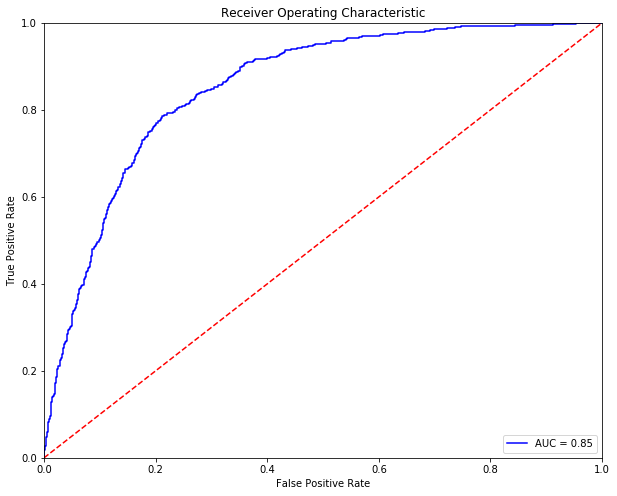

Optimal Threshold is 0.352343919018
Accuracy of Logistic Model on training data is: 0.787182587666


Predicted   0.0  1.0  __all__
Actual                       
0.0        1379  371     1750
1.0         157  574      731
__all__    1536  945     2481

In [468]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [469]:
table_70_70_PCA_20_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_20_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [470]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.868025565769


Predicted     0     1  __all__
Actual                        
0          3713   326     4039
1           438  1312     1750
__all__    4151  1638     5789

The accuracy of the model on test data is: 0.791213220476


Predicted     0    1  __all__
Actual                       
0          1519  231     1750
1           287  444      731
__all__    1806  675     2481

2368/2481 [===========================>..] - ETA: 0s

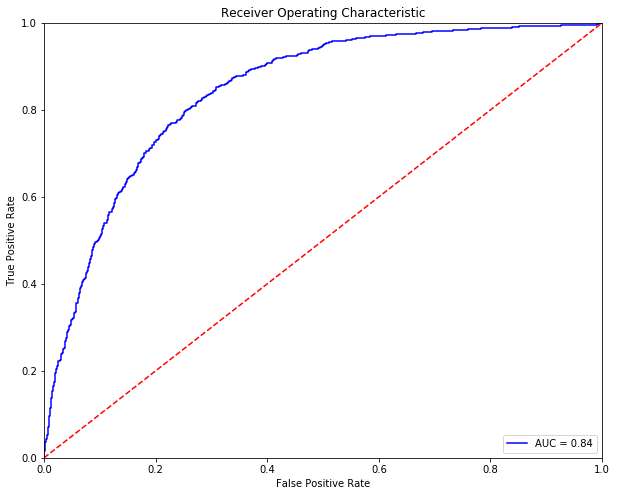

Optimal Threshold is 0.295966
Accuracy of Logistic Model on training data is: 0.766223297058


Predicted   0.0  1.0  __all__
Actual                       
0.0        1339  411     1750
1.0         169  562      731
__all__    1508  973     2481

In [471]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [472]:
table_70_70_PCA_20_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_20_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [473]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  9.0min finished


The accuracy of the model on training data is: 0.817066850924


Predicted     0     1  __all__
Actual                        
0          3473   566     4039
1           493  1257     1750
__all__    3966  1823     5789

The accuracy of the model on test data is: 0.81015719468


Predicted     0    1  __all__
Actual                       
0          1499  251     1750
1           220  511      731
__all__    1719  762     2481

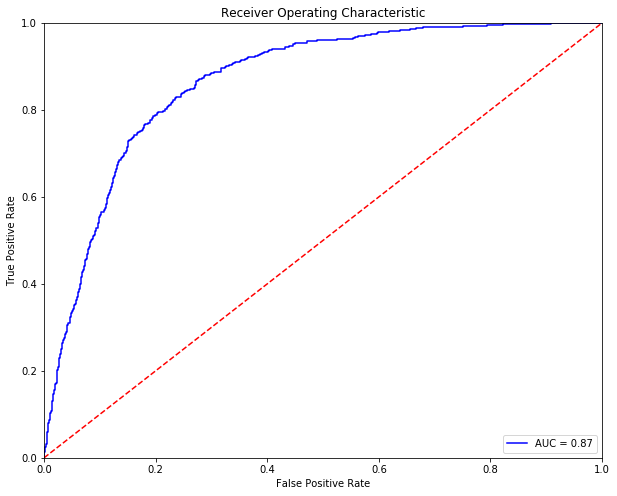

Optimal Threshold is 0.386583
Accuracy of Logistic Model on training data is: 0.794840790004


Predicted   0.0  1.0  __all__
Actual                       
0.0        1392  358     1750
1.0         151  580      731
__all__    1543  938     2481

In [474]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [475]:
table_70_70_PCA_20_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_20_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [476]:
table_70_70_PCA_20_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_PCA_20_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_PCA_20_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_70_70_PCA_20_test.set_index(['index'],drop=True,inplace=True)
table_70_70_PCA_20_train.set_index(['index'],drop=True,inplace=True)
table_70_70_PCA_20_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_70_PCA_20_train)

print("Comparision Table for Test Accuracies:")
display(table_70_70_PCA_20_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_70_PCA_20_test_roc)

Comparision Table for Training Accuracies:


accuracy           TP           TN           FP  \
index                                                                         
KNeighborsClassifier        1.000000  1750.000000  4039.000000     0.000000   
LogisticRegression          0.798584  1336.000000  3287.000000   752.000000   
RandomForestClassifier      0.697703  2818.020556  1220.979444  1220.979444   
AdaBoostClassifier          0.806875  1233.000000  3438.000000   601.000000   
GradientBoostingClassifier  0.813267  1252.000000  3456.000000   583.000000   
ExtraTreeClassifier         0.796511  1356.000000  3255.000000   784.000000   
BaggingClassifier           0.991881  1703.000000  4039.000000     0.000000   
VotingClassifier            0.944377  1457.000000  4010.000000    29.000000   
Neural Network-1            0.868026  1312.000000  3713.000000   326.000000   
Neural-Network-2            0.817067  1257.000000  3473.000000   566.000000   

                                    FN       FPR       FNR  
index                                                       
KNeighborsClassifier          0.000000  0.000000  0.000000  
LogisticRegression          414.000000  0.186185  0.236571  
RandomForestClassifier      529.020556  0.697703  0.302297  
AdaBoostClassifier          517.000000  0.148799  0.295429  
GradientBoostingClassifier  498.000000  0.144343  0.284571  
ExtraTreeClassifier         394.000000  0.194107  0.225143  
BaggingClassifier            47.000000  0.000000  0.026857  
VotingClassifier            293.000000  0.007180  0.167429  
Neural Network-1            438.000000  0.080713  0.250286  
Neural-Network-2            493.000000  0.140134  0.281714

Comparision Table for Test Accuracies:


accuracy           TP           TN          FP  \
index                                                                        
KNeighborsClassifier        0.796453   400.000000  1576.000000  174.000000   
LogisticRegression          0.810157   550.000000  1460.000000  290.000000   
RandomForestClassifier      0.705361  1234.381298   515.618702  515.618702   
AdaBoostClassifier          0.805320   492.000000  1506.000000  244.000000   
GradientBoostingClassifier  0.815397   506.000000  1517.000000  233.000000   
ExtraTreeClassifier         0.797662   547.000000  1432.000000  318.000000   
BaggingClassifier           0.801693   454.000000  1535.000000  215.000000   
VotingClassifier            0.791213   410.000000  1553.000000  197.000000   
Neural Network-1            0.791213   444.000000  1519.000000  231.000000   
Neural-Network-2            0.810157   511.000000  1499.000000  251.000000   

                                    FN       FPR       FNR  
index                                                       
KNeighborsClassifier        331.000000  0.099429  0.452804  
LogisticRegression          181.000000  0.165714  0.247606  
RandomForestClassifier      215.381298  0.705361  0.294639  
AdaBoostClassifier          239.000000  0.139429  0.326949  
GradientBoostingClassifier  225.000000  0.133143  0.307798  
ExtraTreeClassifier         184.000000  0.181714  0.251710  
BaggingClassifier           277.000000  0.122857  0.378933  
VotingClassifier            321.000000  0.112571  0.439124  
Neural Network-1            287.000000  0.132000  0.392613  
Neural-Network-2            220.000000  0.143429  0.300958

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.787586  575.0  1379.0  371.0  156.0  0.212000   
LogisticRegression          0.786780  575.0  1377.0  373.0  156.0  0.213143   
RandomForestClassifier      0.788795  574.0  1383.0  367.0  157.0  0.209714   
AdaBoostClassifier          0.785570  574.0  1375.0  375.0  157.0  0.214286   
GradientBoostingClassifier  0.796453  582.0  1394.0  356.0  149.0  0.203429   
ExtraTreeClassifier         0.793229  562.0  1406.0  344.0  169.0  0.196571   
BaggingClassifier           0.787989  575.0  1380.0  370.0  156.0  0.211429   
VotingClassifier            0.787183  574.0  1379.0  371.0  157.0  0.212000   
Neural Network-1            0.766223  562.0  1339.0  411.0  169.0  0.234857   
Neural-Network-2            0.794841  580.0  1392.0  358.0  151.0  0.204571   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.213406   0.294521  0.850016  
LogisticRegression          0.213406   0.464738  0.870055  
RandomForestClassifier      0.214774   0.271346  0.821432  
AdaBoostClassifier          0.214774   0.476657  0.861902  
GradientBoostingClassifier  0.203830   0.350114  0.867373  
ExtraTreeClassifier         0.231190   0.276923  0.836473  
BaggingClassifier           0.213406   0.370000  0.856890  
VotingClassifier            0.214774   0.352344  0.852353  
Neural Network-1            0.231190   0.295966  0.843791  
Neural-Network-2            0.206566   0.386583  0.865461

In [2]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')